This notebook describes the temporal fusion transformers [@lim2021temporal] architecture, and ports it over to keras 3 while making some punctual improvements, including bringing the notation closer to the one in the paper.

The original repository is [here](https://github.com/google-research/google-research/tree/master/tft).

In [6]:
#| output: false

from __future__ import annotations

import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from datetime import timedelta
from dateutil.relativedelta import relativedelta
from fastcore import docments
from nbdev.showdoc import show_doc
from sklearn.preprocessing import StandardScaler

2023-12-31 00:45:34.713012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Introduction

The main characteristics of TFT that make it interesting for nowcasting or forecasting purposes are:

- **multi-horizon forecasting**: the ability to output, at each point in time $t$, a sequence of forecasts for $t+h, h > 1$
- **quantile prediction**: each forecast is accompanied by a quantile band that communicates the amount of uncertainty around a prediction
- **flexible use of different types of inputs**: static inputs (akin to fixed effects), historical input and known future input (eg, important holidays, years that are known to have major sports events such as Olympic games, etc)
- **interpretability**: the model learns to select variables from the space of all input variables to retain only those that are globally meaningful, to assign attention to different parts of the time series, and to identify events of significance


# Preparing the data

The functions below will be tested with simulated and real data. The former helps to illustrate issues like dimensions and overall behaviour of a layer, whereas the latter will demonstrate on a real setting in economics how the input and output data relate to one another.

More specifically, the real data used will be a daily nowcasting exercise of monthly inflation. Note that the models will not necessarily perform well, since their use here is for illustration purposes and thus they are not optimised. Also, the dataset is not an ideal one for nowcasting: other variables could also be considered.

## Download economic data

This is a panel dataset. In addition to the time dimension, it can contain any number of categorical dimensions - for example, combine country and sector.

In [7]:
#| warning: false

df_all = pd.read_csv("data/nowcast_dataset_complete_Dec-08-2023.csv")
df_all['index'] = pd.to_datetime(df_all['index'])

/var/folders/b9/p8z57lqd55xfk68xz34dg0s40000gn/T/ipykernel_8654/384472896.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv("data/nowcast_dataset_complete_Dec-08-2023.csv")


## Prepare data

In [8]:
countries = ['AU', 'CA', 'DE', 'FR', 'GB', 'JP', 'US']

filter_freq_d = df_all['frequency'] == 'd'
filter_cty = df_all['country'].isin(countries)
filter_dates = df_all['index'] >= '1980-01-01'

In [9]:
df_input = df_all[filter_freq_d & filter_cty & filter_dates].copy()
df_input.drop (['Unnamed: 0', 'frequency'], axis=1, inplace=True)
df_input.set_index(['index', 'country'], inplace=True) 
df_input = df_input.unstack('country')
df_input.columns = ['__'.join(col).strip() for col in df_input.columns.values]
df_input.dropna(how='all', inplace=True)

In [10]:
target_var = 'CPIh'
df_target = df_all.loc[
    (df_all['frequency'] == 'm') & (df_all['country'].isin(countries)) & filter_dates,
    ['index', 'country'] + [target_var]
] \
    .set_index(['index', 'country']) \
    .unstack('country') \
    .droplevel(0, axis=1) \
    .dropna()

In [11]:
df_target_12m_pct = (100 * df_target.pct_change(12))
df_target_1m_pct = (100 * df_target.pct_change(1))

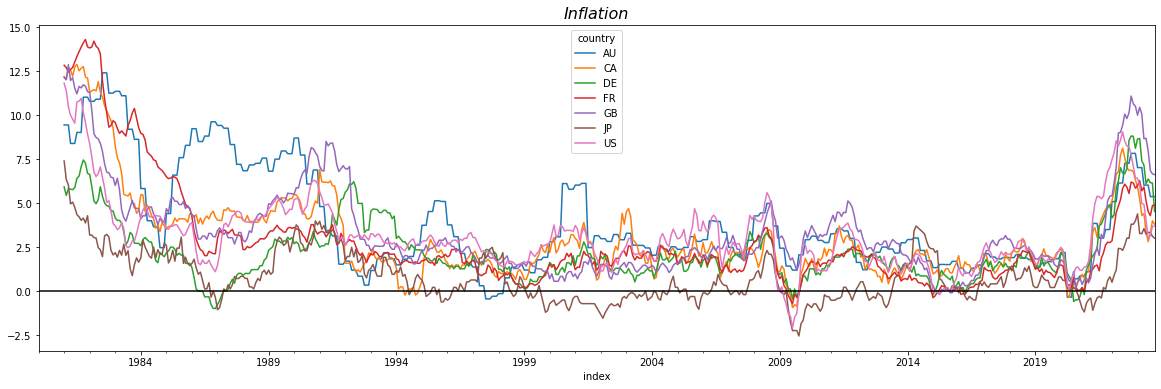

In [12]:
#| fig-align: center

ax = df_target_12m_pct.plot(figsize=(20, 6))
ax.axhline(y=0, color='black')
ax.set_title("Inflation", fontsize=16, fontstyle='italic')
plt.show()

## Date features

In addition to data provided by the user, the model automatically loads categorical features related to each date.

In [13]:
def date_features(
    date_range, # Range of dates for which to create date features
)->pd.DataFrame: # Categorical date features
    "Categorical features for each day in a range of dates"
    return pd.DataFrame({
        'Day of Week': date_range.dayofweek + 1, # This is the only date feature with zeros, which are masked out
        'Day of Month': date_range.day,
        'Day of Year': date_range.dayofyear,
        'Week of Month': (date_range.day - 1) // 7 + 1,
        'Week of Year': pd.Index(date_range.isocalendar().week).astype('int32'),
        'Month of Year': date_range.month
    })


In [14]:
#| output: asis
#| echo: false

show_doc(date_features, title_level=3)

---

### date_features

>      date_features (date_range)

Categorical features for each day in a range of dates

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| date_range |  | Range of dates for which to create date features |
| **Returns** | **pd.DataFrame** | **Categorical date features** |

#### Example usage, real data

In [15]:
#| code-fold: show

date_features(df_input.index)[:10]

,Day of Week,Day of Month,Day of Year,Week of Month,Week of Year,Month of Year
0,2,1,1,1,1,1
1,3,2,2,1,1,1
2,4,3,3,1,1,1
3,5,4,4,1,1,1
4,1,7,7,1,2,1
5,2,8,8,2,2,1
6,3,9,9,2,2,1
7,4,10,10,2,2,1
8,5,11,11,2,2,1
9,1,14,14,2,3,1


### Combining the date features in the main data

In [16]:
date_feat = date_features(df_input.index)
date_feat.index = df_input.index
df_input = pd.concat([df_input, date_feat], axis=1)

## Splitting the dataset

This step needs to be done somewhat differently than normal datasets: In the validation and test periods, the input data can very well be from the previous chunk (training and validation, respectively).

In practice, this means that we just need to split the **dates** at which the nowcasting will take place. Then, a data loading function (see Section @sec-dataloaders) can read from the whole time series to look back from that date as needed according to the desired time window.

In [17]:
start_date = df_input.index.min()
end_date = df_input.index.max()
cutoff_date_train = pd.to_datetime('2005-01-01')
cutoff_date_valid = pd.to_datetime('2020-01-01')

dates_train = pd.date_range(start_date, cutoff_date_train - timedelta(days=1))
dates_valid = pd.date_range(cutoff_date_train, cutoff_date_valid - timedelta(days=1))
dates_test = pd.date_range(cutoff_date_valid, end_date)

Now all input variables that are not available in the training dataset are removed, and only those with at least some information are kept.

In [18]:
keep_cols = df_input.loc[min(dates_train):max(dates_train)].dropna(axis=1, how='all').columns
df_input = df_input[keep_cols]

## Identifying continuous and categorical variables {#sec-contcat}

 The model distinguishes continuous from categorical variables if the user does not provide a list of variable names in a simple (simplistic) way: integer-valued variables that start with one are considered categorical, all other are continuous.

The criteria that categorical variables start with one is to ensure that the user does not unwarrantedly pass on categorical variables with zero, since zeros are considered to be a padding for variable-length input data.

For variables that are naturally valued in integers, such as the count of number of firms, etc, the user can either ensure there is a zero amongst the integer at any time of the **training** input data, or convert these values to floating numbers. Another alternative that might be relevant in some cases is to use the natural logarithm of that data.

In [19]:
int_cols = df_input.select_dtypes(include=['int']).columns
float_cols = df_input.select_dtypes(include=['float']).columns

# Columns that are float but actually contain integer values starting with one
cat_cols = []

for col in int_cols:
    if min(df_input[col]) > 0:
        cat_cols.append(col)

for col in float_cols:
    if (df_input[col] % 1 == 0).all() and min(df_input[col]) > 0:  # Check if the fractional part is 0 for all values and the lowest integer is 1
        cat_cols.append(col)

cont_cols = [c for c in df_input.columns if c not in cat_cols]

assert len(cont_cols) + len(cat_cols) == df_input.shape[1]

Further, the categorical variables require a dictionary that indicates the cardinality of each variable.

## Scaling the continuous variables

The input series need to be scaled, according to the training data mean and standard deviation.

The target series will not be scaled because it is already a small number close to zero that is not exploding in nature.

In [20]:
#| warning: false

scl = StandardScaler()
scl.fit(df_input.loc[dates_train.min():dates_train.max(), cont_cols])
df_input_scl = pd.DataFrame(
    scl.transform(df_input[cont_cols]),
    index=df_input.index,
    columns=cont_cols
    )
df_input_scl = pd.concat([df_input_scl, date_feat], axis=1)

assert df_input_scl.shape == df_input.shape

## Cardinality of categorical variables

Each categorical variable has its own cardinality. This value is important when creating the embedding layer for each variable; see Section @sec-input.

In [21]:
cat_card = {c: len(df_input_scl[c].unique()) for c in cat_cols}

cat_card

{'Day of Week': 5,
 'Day of Month': 31,
 'Day of Year': 366,
 'Week of Month': 5,
 'Week of Year': 53,
 'Month of Year': 12}

The cardinality of the static variable(s) must also be included:

In [22]:
country_enc_dict = {cty: idx + 1 for idx, cty in enumerate(df_target.columns)}
country_dec_dict = {idx + 1: cty for cty, idx in country_enc_dict.items()}

In [23]:
cat_card['Countries'] = len(country_enc_dict.keys())

## Padding missing data


Missing data is dealt with by replacing `nan`s in the input data with zeros. This has two effects:

* it prevents embedding categorical variables since zeros are masked out

* for the continuous data, the input layer weights do not pick up any information, and the constant (or "bias" in machine learning language) is responsible for conveying any information to subsequent neurons.

Obviously this step needs to be done after the input data is scaled, otherwise the zeros would be wrongly contributing to the mean and standard deviation values.

In [24]:
df_input_scl.fillna(0, inplace=True)

## Data loaders {#sec-dataloaders}

Ideally a data loader should:

* create a pair of input/target data

* the input data should contain:

    * continuous data from all countries

    * categorical date features

    * categorical feature of the country (ie, which country it is)

    * known future inputs

On the known future inputs: those will be essentially the categorical date features, broadcasted until the end of the desired month to be nowcasted (ie, either the current month or a future one). The nowcast will then be the value of inflation at the end of the "as-of" month.

> Note: so far, the only known future data used by the model are the categorical features from the dates up to the last day of the nowcasted/forecasted month. However, an important known future data for inflation are the central bank policy variables. These are not yet dealth with in this code, but a future version should incorporate an intelligent way for users to input a vector of policy variables, with the dates up until which they would be known. This could be done in a separate DataFrame with policy variables, which would arguably facilitate working with this data separately from all others.

In [25]:
def sample_data(
        day:[str|pd.DatetimeIndex], # Nowcasting date
        country:str, # Country for which nowcasting will be made
        n_days:int, # Maximum length of historical time window in days for input data
        df_input:pd.DataFrame, # DataFrame with daily input data
        df_target:pd.DataFrame, # DataFrame with monthly target data, with dates in index and countries in columns
        delta_month:[int|list]=0 # Which month to predict, relative to the input data's latest date
):
    "Retrieves input and target data for a certain date"

    current_date = pd.to_datetime(day) if isinstance(day, str) else day
    start_date = current_date - timedelta(days=n_days - 1)
    
    if type(delta_month) == int:
        target_month = current_date + relativedelta(months=delta_month)
        target_month = target_month.replace(day=1) # using the 1st day of the month to match the index of df_target
        end_nowcasted_month = target_month + pd.offsets.MonthEnd(0)
    else:
        target_month = [
            (current_date + relativedelta(months=d)).replace(day=1)
            for d in delta_month
        ]
        end_nowcasted_month = max(target_month) + pd.offsets.MonthEnd(0)

    # continuous historical
    X_cont_hist = df_input.loc[start_date:current_date, cont_cols]

    # categorical historical
    X_cat_hist = df_input.loc[start_date:current_date, cat_cols]

    # categorical static
    X_cat_stat = country_enc_dict[country] # lookup from the "country dictionary"

    # known future inputs - so far the date only       
    future_dates = pd.date_range(current_date, end_nowcasted_month)
    X_cat_fut = date_features(future_dates)
    
    # target
    y = df_target.loc[target_month][country]

    # note that the returned input series can have less rows than `n_days` because of weekends, etc
    return X_cont_hist, X_cat_hist, X_cat_stat, X_cat_fut, y 

In [26]:
#| output: asis
#| echo: false

show_doc(sample_data, title_level=3)

---

### sample_data

>      sample_data (day:[str|pandas.core.indexes.datetimes.DatetimeIndex],
>                   country:str, n_days:int,
>                   df_input:pandas.core.frame.DataFrame,
>                   df_target:pandas.core.frame.DataFrame,
>                   delta_month:[int|list]=0)

Retrieves input and target data for a certain date

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| day | [str \| pd.DatetimeIndex] |  | Nowcasting date |
| country | str |  | Country for which nowcasting will be made |
| n_days | int |  | Maximum length of historical time window in days for input data |
| df_input | pd.DataFrame |  | DataFrame with daily input data |
| df_target | pd.DataFrame |  | DataFrame with monthly target data, with dates in index and countries in columns |
| delta_month | [int \| list] | 0 | Which month to predict, relative to the input data's latest date |

#### Example usage, real data

In [27]:
#| code-fold: show

X_cont_hist, X_cat_hist, X_cat_stat, X_cat_fut, y = sample_data(
    day=pd.to_datetime('2009-02-14'), 
    country='GB',
    n_days=5, 
    df_input=df_input_scl, 
    df_target=df_target_1m_pct
)

In [28]:
#| code-fold: show

X_cat_hist

,Day of Week,Day of Month,Day of Year,Week of Month,Week of Year,Month of Year
index,,,,,,
2009-02-10,2,10,41,2,7,2
2009-02-11,3,11,42,2,7,2
2009-02-12,4,12,43,2,7,2
2009-02-13,5,13,44,2,7,2


In [29]:
#| code-fold: show

X_cat_fut

,Day of Week,Day of Month,Day of Year,Week of Month,Week of Year,Month of Year
0,6,14,45,2,7,2
1,7,15,46,3,7,2
2,1,16,47,3,8,2
3,2,17,48,3,8,2
4,3,18,49,3,8,2
5,4,19,50,3,8,2
6,5,20,51,3,8,2
7,6,21,52,3,8,2
8,7,22,53,4,8,2
9,1,23,54,4,9,2


For models that will nowcast/forecast more than one month, the argument `delta_month` needs to be a list:

In [30]:
#| code-fold: show

X_cont_hist, X_cat_hist, X_cat_stat, X_cat_fut, y = sample_data(
    day=pd.to_datetime('2009-02-14'), 
    country='GB',
    n_days=5, 
    df_input=df_input_scl, 
    df_target=df_target_1m_pct,
    delta_month=range(3)
)

Now the months for which to forecast are February (the current month of the sampled day), March and April, corresponding to the three months indicated in the argument.

In [31]:
#| code-fold: show

y

index
2009-02-01    0.824499
2009-03-01    0.233645
2009-04-01    0.233100
Name: GB, dtype: float64

In [32]:
def sample_batch (
    df_input:pd.DataFrame, # DataFrame with daily input data
    df_target:pd.DataFrame, # DataFrame with monthly target data, with dates in index and countries in columns
    date_split:str='train', # Either 'train', 'valid' or 'test'
    batch_size:int=100, # Number of instances in each batch
    min_n_days:int=15, # Minimum length of time in continuous input data for the whole batch
    max_n_days:int=90, # Maximum length of time in continuous input data for the whole batch
    delta_month:[int|list]=0, # Which month to predict, relative to the input data's latest date
    random_seed:int=12345 # Random seed
):
    "Creates one batch of sampled data"

    if date_split == 'train':
        dates_to_sample = dates_train
    elif date_split == 'valid':
        dates_to_sample = dates_valid
    elif date_split == 'test':
        dates_to_sample = dates_test
    else:
        raise ValueError

    countries_to_sample = df_target.columns.to_list()

    random.seed(random_seed)
    rdm_n_days = random.choice(range(min_n_days, max_n_days))

    batch_items = []
    for _ in range(batch_size):
        batch_items.append(
            sample_data(
                day=random.choice(dates_to_sample),
                country=random.choice(countries_to_sample),
                n_days=rdm_n_days,
                df_input=df_input, 
                df_target=df_target,
                delta_month=delta_month
            )
        )
    # some items might have different time window lengths because of dates that are weekends, etc
    # because time length needs to be standardised per batch, all batch items should be as long as
    # the smallest item
    n_min_hist = min(X_cont_hist.shape[0] for X_cont_hist, _, _, _, _ in batch_items)
    n_min_fut = min(X_cont_hist.shape[0] for _, _, _, X_cat_fut, _ in batch_items)
    batch_items = [
        (
            X_cont_hist.tail(n_min_hist), 
            X_cat_hist.tail(n_min_hist),
            X_cat_stat,
            X_cat_fut.tail(n_min_fut),
            y
        ) 
        for X_cont_hist, X_cat_hist, X_cat_stat, X_cat_fut, y in batch_items
    ]

    return batch_items

In [33]:
#| output: asis
#| echo: false

show_doc(sample_batch, title_level=3)

---

### sample_batch

>      sample_batch (df_input:pandas.core.frame.DataFrame,
>                    df_target:pandas.core.frame.DataFrame,
>                    date_split:str='train', batch_size:int=100,
>                    min_n_days:int=15, max_n_days:int=90,
>                    delta_month:[int|list]=0, random_seed:int=12345)

Creates one batch of sampled data

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df_input | pd.DataFrame |  | DataFrame with daily input data |
| df_target | pd.DataFrame |  | DataFrame with monthly target data, with dates in index and countries in columns |
| date_split | str | train | Either 'train', 'valid' or 'test' |
| batch_size | int | 100 | Number of instances in each batch |
| min_n_days | int | 15 | Minimum length of time in continuous input data for the whole batch |
| max_n_days | int | 90 | Maximum length of time in continuous input data for the whole batch |
| delta_month | [int \| list] | 0 | Which month to predict, relative to the input data's latest date |
| random_seed | int | 12345 | Random seed |

All historical time series in the same batch have the same length. This length varies beetween batches.

#### Example usage, real data

In [34]:
#| code-fold: show

batch = sample_batch(df_input=df_input_scl, df_target=df_target_1m_pct, batch_size=8, delta_month=range(3), random_seed=1)

The target values for the first and fourth elements of the batch are, respectively:

In [35]:
batch[0][4], batch[3][4]

(index
 1982-10-01    0.475059
 1982-11-01    0.236407
 1982-12-01    0.235849
 Name: DE, dtype: float64,
 index
 1997-01-01    0.315259
 1997-02-01    0.314268
 1997-03-01    0.250627
 Name: US, dtype: float64)

Since the data is taken up in batches, but separately according to the type of input (continuous historical, categorical historical, categorical static, categorical future), the next function takes in a batch and breaks it down into batches of these types of data.

In [36]:
def batch_breakdown(
    batch, # Batch (list of [X_cont_hist, X_cat_hist, X_cat_stat, X_cont_fut, X_cat_fut, y]) to be broken down into batches of each input component
    as_numpy:bool=True # Should the input values be transformed into a batch_size X item dimensions numpy array?
):
    batch_cont_hist = []
    batch_cat_hist = []
    batch_cat_stat = []
    # batch_cont_fut = []
    batch_cat_fut = []
    batch_y = []

    for i in range(len(batch)):
        X_cont_hist, X_cat_hist, X_cat_stat, X_cat_fut, y = batch[i]
        batch_cont_hist.append(X_cont_hist)
        batch_cat_hist.append(X_cat_hist)
        batch_cat_stat.append(X_cat_stat)
        # batch_cont_fut.append(X_cont_fut)
        batch_cat_fut.append(X_cat_fut)
        batch_y.append(y)
            
    if as_numpy:
        batch_cont_hist = np.stack([df.to_numpy() for df in batch_cont_hist])
        batch_cat_hist = np.stack(batch_cat_hist)
        batch_cat_stat = np.stack(batch_cat_stat)
        if batch_cat_stat.ndim == 1:
            batch_cat_stat = batch_cat_stat.reshape(-1, 1)
        # batch_cont_fut = np.stack([df.to_numpy() for df in batch_cont_fut])
        batch_cat_fut = np.stack(batch_cat_fut)
        batch_y = np.stack(batch_y)
        if batch_y.ndim == 1:
            batch_y = batch_y.reshape(-1, 1)

    return batch_cont_hist, batch_cat_hist, batch_cat_stat, batch_cat_fut, batch_y

In [37]:
#| output: asis
#| echo: false

show_doc(batch_breakdown, title_level=3)

---

### batch_breakdown

>      batch_breakdown (batch, as_numpy:bool=True)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| batch |  |  | Batch (list of [X_cont_hist, X_cat_hist, X_cat_stat, X_cont_fut, X_cat_fut, y]) to be broken down into batches of each input component |
| as_numpy | bool | True | Should the input values be transformed into a batch_size X item dimensions numpy array? |

#### Example usage, real data

In [38]:
#| code-fold: show

batch_cont_hist, batch_cat_hist, batch_cat_stat, batch_cat_fut, batch_y = batch_breakdown(batch)
print("Continuous historical data: (batch size / num time steps / num covariates):", batch_cont_hist.shape)
print("categorical historical data: (batch size / num time steps / num categorical features):", batch_cat_hist.shape)
print("categorical static data: (batch size / num categorical variables):", batch_cat_stat.shape)
print("categorical future data: (batch size / num future time steps / num categorical features):", batch_cat_fut.shape)
print("target data: (batch size / num targets):", batch_y.shape)

Continuous historical data: (batch size / num time steps / num covariates): (8, 22, 469)
categorical historical data: (batch size / num time steps / num categorical features): (8, 22, 6)
categorical static data: (batch size / num categorical variables): (8, 1)
categorical future data: (batch size / num future time steps / num categorical features): (8, 4, 6)
target data: (batch size / num targets): (8, 3)


# Notation

* unique entities: $i \in (1, \dots\, I)$
* time periods $t \in [0, T_i]$
  * $k \geq 1$ lags
  * $h \geq 1$ forecasting period
* set of entity-level static covariates: $s_i \in \mathbf{R}^{m_s}$
* set of temporal inputs: $\chi_{i, t} \in \mathbf{R}^{m_\chi}$
  * $\chi_{i,t} = [z_{i,t}, x_{i,t}]$
    * $z_{i,t} \in \mathbf{R}^{m_z}$ are historical inputs
    * $x_{i,t} \in \mathbf{R}^{m_z}$ are a priori known inputs (eg, days of the week or years that have major sports events)
  * $m_\chi$ is the number of total input variables, where $m_\chi = m_z + m_x$
* target scalars: $y_{i,t}$
  * $\hat{y}_{i,t,q} = f_q(y_{i,t-k:t}, z_{i,t-k:t}, x_{i,t-k:t+h}, s_i)$
* hidden unit size (common across all the TFT architecture for convenience): $d_{\text{model}}$
* transformed input of $j$-th variable at time $t$: $\xi_t^{(j)} \in \mathbf{R}^{d_{\text{model}}}$
  * $\Xi_t = [\xi_t^{(1)}, \dots, \xi_t^{(m_\chi)}]$

# Architecture

First, individual components are presented. Then at the end of this section, the whole model is put together.

## Dense layer

> dedicated implementation to better control use of time distribution on vanilla linear layer

$$
\mathbb{Y} = \phi(\mathbf{W} x + \mathbf{b}),
$$ {#eq-dense}

where $x$ is the input to `dense_layer()(x)`, $\mathbb{Y}$ is the output of `dense_layer()(x)`, $\phi$ is an activation function (or no activation function is `activation` is `None`), $\mathbf{W} \in \mathbf{R}^{(d_{\text{size}} \times d_{\text{inputs}})}$ is a matrix of weights and $\mathbf{b} \in \mathbf{R}^{d_{size}}$ is a vector of biases. Importantly, $\mathbf{W}$ and $\mathbf{b}$ are indexed with $_{\omega}$ to denote weight-sharing when the layer is time-distributed.

Below is a short description of the concept of *time distributed* layers:

* applies same layer to each of the time steps in the data
  * in other words, a layer with the exact same weights
* takes data organized the following way:
  * index 0: batch
  * index 1: time
  * indices 2, etc: data
* More info: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed

In [39]:
def dense_layer(
    size:int, # Output size
    activation:str|callable|None=None, # Activation function
    use_time_distributed:bool=False, # Apply the layer across all time steps?
    use_bias:bool=True # Include bias in the layer?
)->layers.Dense: # Dense layer
    "Dense layer"

    layer = layers.Dense(size, activation=activation, use_bias=use_bias)
    if use_time_distributed:
        layer = layers.TimeDistributed(layer)
    return layer

In [40]:
#| output: asis
#| echo: false

show_doc(dense_layer, title_level=3)

---

### dense_layer



Dense layer

#### Example usage

In [41]:
#| code-fold: show

batch_size = 2
n_timesteps = 5
n_features = 100
layer_size = 4

# input dimensions: batch size / timesteps / features
x = np.ones(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 

# dense layer
linear_td_true = dense_layer(size=layer_size, use_time_distributed=True)
linear_td_false = dense_layer(size=layer_size, use_time_distributed=False)

# output dimensions: batches / timesteps / layer size
assert linear_td_true(x).shape == [batch_size, n_timesteps, layer_size]
assert linear_td_false(x).shape == [batch_size, n_timesteps, layer_size]

Note that the time-distributed linear layer results in the same weights being applied to each time step:

In [42]:
#| code-fold: show

linear_td_true(x).shape, [batch_size, n_timesteps, layer_size]

(TensorShape([2, 5, 4]), [2, 5, 4])

In [43]:
#| code-fold: show

x = np.ones((1, n_timesteps, n_features))
timesteps_equal = []
for i in range(n_timesteps-1):
    timesteps_equal.append((np.array_equal(linear_td_true(x)[0,0,:], linear_td_true(x)[0,i+1,:])))

assert np.all(timesteps_equal)

linear_td_true(x)

<tf.Tensor: shape=(1, 5, 4), dtype=float32, numpy=
array([[[ 0.22436763, -2.1265557 , -0.7999874 , -0.11619931],
        [ 0.22436763, -2.1265557 , -0.7999874 , -0.11619931],
        [ 0.22436763, -2.1265557 , -0.7999874 , -0.11619931],
        [ 0.22436763, -2.1265557 , -0.7999874 , -0.11619931],
        [ 0.22436763, -2.1265557 , -0.7999874 , -0.11619931]]],
      dtype=float32)>

#### Example usage, real data

As seen above, this function takes in data in the format (batch size / timesteps / features).

In [44]:
#| code-fold: show 

batch_cont_hist, batch_cat_hist, batch_cat_stat, batch_cat_fut, batch_y = batch_breakdown(batch)

batch_cont_hist.shape

(8, 22, 469)

In [45]:
#| code-fold: show 

linear_td_true = dense_layer(size=layer_size, use_time_distributed=True)
linear_td_false = dense_layer(size=layer_size, use_time_distributed=False)

assert linear_td_true(batch_cont_hist).shape == [batch_cont_hist.shape[0], batch_cont_hist.shape[1], layer_size]
assert linear_td_false(batch_cont_hist).shape == [batch_cont_hist.shape[0], batch_cont_hist.shape[1], layer_size]

## Categorical embeddings

> Embeds categorical variables

Most categorical economic variables do not have more than a few dozen different categories, unlike in natural language processing, where vocabulary sizes are counted in the tens of thousands. For this reason, the default number of categories is set at 50. However, this can be adjusted by the user in case there are more unique categories in a variable.

Note that this function takes in batches of static or time series of categorical variables.

In [46]:
def cat_embed(
    hidden_layer_size:int, # Dimension of the embeddings
    n_categories:int=50 # Number of different categories
)->keras.KerasTensor: # $\xi^{(j)}$ with dimensions (batch_size, num time steps, hidden layer size)
    "Embedding for the categorical variables"
    return keras.Sequential([
        layers.Embedding(
            input_dim=n_categories,
            output_dim=hidden_layer_size,
            mask_zero=True
        )
    ])

In [47]:
#| output: asis
#| echo: false

show_doc(cat_embed, title_level=3)

---

### cat_embed

>      cat_embed (hidden_layer_size:int, n_categories:int=50)

Embedding for the categorical variables

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| hidden_layer_size | int |  | Dimension of the embeddings |
| n_categories | int | 50 | Number of different categories |
| **Returns** | **keras.KerasTensor** |  | **$\xi\^{(j)}$ with dimensions (batch_size, num time steps, hidden layer size)** |

Note that this function masks out the data whenever categories are set to zero. This is to ensure that the model can take in variable-sized inputs. Because of this, the model requires inputted categorical data to be added 1.

The dimension of the embeddings, `hidden_layer_size`, is usually set to $d_{\text{model}}$ to keep the hyperparameter space relatively simple.

#### Example usage

In the code below, the array `x` is created with distinct integers that stand for different categories.

Also, for pedagogical purposes the example code below uses the same number of different categories as potentially exist in the data.

In [48]:
#| code-fold: show

batch_size = 3
n_timesteps = 8
hidden_layer_size = 4
num_diff_categories = 6

temporal_cat_input = np.random.randint(low=0, high=num_diff_categories-1, size=(batch_size, n_timesteps))
static_cat_input = np.random.randint(low=0, high=num_diff_categories-1, size=(batch_size, 1))

embedded_xi_temp = cat_embed(hidden_layer_size=hidden_layer_size, n_categories=num_diff_categories)(temporal_cat_input)
print("Shape of embedded temporal xi_t:", embedded_xi_temp.shape)

embedded_xi_stat = cat_embed(hidden_layer_size=hidden_layer_size, n_categories=num_diff_categories)(static_cat_input)
print("Shape of embedded static xi_t:", embedded_xi_stat.shape)

# inspecting the first batch of temporal variables and all static input; note that same integers have the same embeddings
temporal_cat_input[0], embedded_xi_temp[0], static_cat_input, embedded_xi_stat

Shape of embedded temporal xi_t: (3, 8, 4)
Shape of embedded static xi_t: (3, 1, 4)


(array([2, 0, 0, 4, 1, 0, 4, 3]),
 <tf.Tensor: shape=(8, 4), dtype=float32, numpy=
 array([[-0.03189259,  0.03313997,  0.04984239, -0.04386931],
        [ 0.00804866, -0.03852391,  0.0130749 , -0.01812882],
        [ 0.00804866, -0.03852391,  0.0130749 , -0.01812882],
        [-0.00454559, -0.00886058,  0.04588591, -0.01533512],
        [-0.0323078 ,  0.04413396,  0.04103297,  0.01876872],
        [ 0.00804866, -0.03852391,  0.0130749 , -0.01812882],
        [-0.00454559, -0.00886058,  0.04588591, -0.01533512],
        [-0.00475868, -0.03683082,  0.00285649, -0.0045046 ]],
       dtype=float32)>,
 array([[3],
        [3],
        [4]]),
 <tf.Tensor: shape=(3, 1, 4), dtype=float32, numpy=
 array([[[-0.00969267, -0.03683452,  0.02941171, -0.03189441]],
 
        [[-0.00969267, -0.03683452,  0.02941171, -0.03189441]],
 
        [[-0.03166249,  0.01970775,  0.02275259,  0.00015485]]],
       dtype=float32)>)

#### Example usage, real data

##### Categorical historical data

In [49]:
#| code-fold: show

hidden_layer_size = 4
num_diff_categories = 50

embedded_cat_hist = cat_embed(hidden_layer_size=hidden_layer_size, n_categories=num_diff_categories)(batch_cat_hist)

# inspecting the first batch below (first seven time steps only)
# note that same integers have the same embeddings
batch_cat_hist[0,:7,0], embedded_cat_hist[0,:7,0]

(array([4, 5, 1, 2, 3, 4, 5]),
 <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
 array([[ 0.0251277 , -0.01393209, -0.01774675, -0.04347542],
        [-0.01735954,  0.04371978,  0.03946259, -0.00145564],
        [-0.0032485 , -0.04385271,  0.04929248,  0.03329116],
        [-0.03245006, -0.01225274, -0.03995414,  0.04091744],
        [ 0.00949676,  0.01231829, -0.02462354,  0.01876222],
        [ 0.0251277 , -0.01393209, -0.01774675, -0.04347542],
        [-0.01735954,  0.04371978,  0.03946259, -0.00145564]],
       dtype=float32)>)

##### Categorical static data

In [50]:
#| code-fold: show

embedded_cat_stat = cat_embed(hidden_layer_size=hidden_layer_size, n_categories=num_diff_categories)(batch_cat_stat)

batch_cat_stat, embedded_cat_stat

(array([[3],
        [4],
        [4],
        [7],
        [1],
        [1],
        [4],
        [6]]),
 <tf.Tensor: shape=(8, 1, 4), dtype=float32, numpy=
 array([[[-0.02347237, -0.01278742, -0.03315454,  0.0231704 ]],
 
        [[ 0.03581769,  0.04612065,  0.01265341,  0.00669236]],
 
        [[ 0.03581769,  0.04612065,  0.01265341,  0.00669236]],
 
        [[ 0.04785157,  0.02749087, -0.03071175, -0.01341645]],
 
        [[ 0.01506883, -0.035286  , -0.01688587,  0.02081167]],
 
        [[ 0.01506883, -0.035286  , -0.01688587,  0.02081167]],
 
        [[ 0.03581769,  0.04612065,  0.01265341,  0.00669236]],
 
        [[-0.04516436,  0.00216227, -0.02499655, -0.00886422]]],
       dtype=float32)>)

##### Categorical future data

In [51]:
#| code-fold: show

embedded_cat_fut = cat_embed(hidden_layer_size=hidden_layer_size, n_categories=num_diff_categories)(batch_cat_fut)

batch_cat_fut[0,:,2], embedded_cat_fut[0,:,2]

(array([362, 363, 364, 365]),
 <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
 array([[ 0.01802533, -0.03608159, -0.0157329 , -0.0184898 ],
        [ 0.01802533, -0.03608159, -0.0157329 , -0.0184898 ],
        [ 0.01802533, -0.03608159, -0.0157329 , -0.0184898 ],
        [ 0.01802533, -0.03608159, -0.0157329 , -0.0184898 ]],
       dtype=float32)>)

## Input data transformations {#sec-input}

> Transforms all input variables into a latent space

All input data, regardless if historical, static or future, are transformed into a feature representation with dimension $d_{\text{model}}$. In other words, $\chi_{t}^{(j)}$, variable $j$'s observation at each time period $t$, undergoes an injective mapping $f^{(j)} : \mathbb{R} \to \mathbb{R}^{d_{\text{model}}}$.

If the variable $\chi_{t}^{(j)}$ is continuous, this transformation is done by $d_{\text{model}}$ linear regressions, the coefficients of which are determined as part of the neural network training:

$$
\xi_t^{(j)} = \mathbf{W}^{(j)} \chi_{t}^{(j)} + \mathbf{b}^{(j)},
$$

where $\xi_t^{(j)}, \mathbf{W}^{(j)}, \mathbf{b}^{(j)} \in \mathbb{R}^{d_{\text{model}}}$. Note that $\mathbf{W}^{(j)}, \mathbf{b}^{(j)}$ are the same for variable $j$ at all time periods (ie, the layer is time-distributed).

Conversely, if the $j^{\text{th}}$ variable is categorical, then the transformation is an embedding.

Each embedding layer requires a specific number of different categories, ie the cardinality of the categorical variable. This cardinality is assumed to be stable or decreasing outside of the training period; otherwise a new category would appear at testing time for which the model has not learned an embedding.

See section @sec-contcat for details of how the model determines which variables are continuous or categorical.

In [363]:
def transf_input(
    input_data, # Input data
    size:int, # Dimension of the latent space of each variable
    var_name:str=None, # Name of the variable, required for categorical variables
    continuous:bool=True # Is the variable continuous (default) or categorical?
):
    r"Transforms input data $\chi_t^{(j)}$ into a latent space $\xi_t^{(j)}$ for forward processing"

    transf = dense_layer(size=size, use_time_distributed=True) \
        if continuous else \
        cat_embed(hidden_layer_size=size, n_categories=cat_card[var_name])
    return transf(input_data)

In [364]:
#| output: asis
#| echo: false

show_doc(transf_input, title_level=3)

---

### transf_input

>      transf_input (input_data, size:int, var_name:str=None,
>                    continuous:bool=True)

Transforms input data $\chi_t^{(j)}$ into a latent space $\xi_t^{(j)}$ for forward processing

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| input_data |  |  | Input data |
| size | int |  | Dimension of the latent space of each variable |
| var_name | str | None | Name of the variable, required for categorical variables |
| continuous | bool | True | Is the variable continuous (default) or categorical? |

### Example usage, real data

In [365]:
#| code-fold: show

xi_j_cont = keras.ops.stack([
    transf_input(
        input_data=keras.ops.expand_dims(batch_cont_hist[:,:,idx], axis=-1), 
        size=hidden_layer_size, 
        continuous=True)
    for idx, chi_j in enumerate(cont_cols)
], axis=-1)
xi_j_cont.shape # batch size / num time steps / hidden layer size / num continuous variables

(32, 46, 16, 469)

In [509]:
expanded_data = keras.ops.expand_dims(batch_cont_hist[:, :, 0], axis=-1)

# Transform the input
transf_input(
    input_data=expanded_data,
    size=hidden_layer_size,
    var_name=cont_cols[0],
    continuous=True
).shape

TensorShape([32, 46, 16])

In [366]:
#| code-fold: show

xi_j_cat = keras.ops.stack([
    transf_input(
        input_data=batch_cat_hist[:,:,idx], 
        size=hidden_layer_size, 
        var_name=chi_j,
        continuous=False)
    for idx, chi_j in enumerate(cat_cols)
], axis=-1)
xi_j_cat.shape # batch size / num time steps / hidden layer size / num categorical variables

(32, 46, 16, 6)

In [367]:
#| code-fold: show

batch_cat_stat

array([[3],
       [1],
       [5],
       [4],
       [7],
       [4],
       [7],
       [5],
       [2],
       [5],
       [4],
       [4],
       [5],
       [2],
       [3],
       [5],
       [4],
       [5],
       [7],
       [3],
       [2],
       [5],
       [5],
       [6],
       [5],
       [7],
       [5],
       [4],
       [4],
       [4],
       [3],
       [1]])

In [601]:
def embed_input_batch(
    input_batch, # Input data (output from `sample_batch`)
    hidden_layer_size:int # Dimension of the input transformation
):
    "Embeddings for the input data"
    # Unpack batch
    batch_cont_hist, batch_cat_hist, batch_cat_stat, batch_cat_fut, _ = batch_breakdown(input_batch)

    # Historical data
    xi_hist_cont = keras.ops.stack([
        transf_input(
            input_data=keras.ops.expand_dims(batch_cont_hist[:,:,idx], axis=-1), 
            size=hidden_layer_size, 
            continuous=True)
        for idx, z_j in enumerate(cont_cols)
    ], axis=-1) # batch size / num time steps / hidden layer size / num historical continuous variables   

    xi_hist_cat = keras.ops.stack([
        transf_input(
            input_data=batch_cat_hist[:,:,idx], 
            size=hidden_layer_size, 
            var_name=z_j,
            continuous=False)
        for idx, z_j in enumerate(cat_cols)
    ], axis=-1) # batch size / num time steps / hidden layer size / num historical categorical variables    
    
    xi_hist = keras.ops.concatenate([xi_hist_cont, xi_hist_cat], axis=-1)

    # Static data
    xi_stat_cat = transf_input(
        input_data=batch_cat_stat, 
        size=hidden_layer_size, 
        var_name='Countries',
        continuous=False
    ) # batch size / num static categorical variables / hidden layer size

    # Future data (note to self: when continuous future data is implemented, a similar concatenate ops to historical data should be done)

    xi_fut_cat = keras.ops.stack([
        transf_input(
            input_data=batch_cat_fut[:,:,idx], 
            size=hidden_layer_size, 
            var_name=x_j,
            continuous=False)
        for idx, x_j in enumerate(cat_cols)
    ], axis=-1) # batch size / num time steps / hidden layer size / num future categorical variables    

    return xi_hist, xi_stat_cat, xi_fut_cat

In [602]:
show_doc(embed_input_batch, title_level=3)

---

### embed_input_batch

>      embed_input_batch (input_batch, hidden_layer_size:int)

Embeddings for the input data

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| input_batch |  | Input data (output from `sample_batch`) |
| hidden_layer_size | int | Dimension of the input transformation |

The dimension of the input transformation, `hidden_layer_size`, is usually set to $d_{\text{model}}$ to keep the hyperparameter space relatively simple.

### Example usage, real data

In [603]:
#| code-fold: show

batch = sample_batch(
    df_input=df_input_scl, 
    df_target=df_target_1m_pct, 
    batch_size=32, 
    delta_month=range(3), 
    random_seed=1985
)

xi_hist, xi_stat, xi_fut = embed_input_batch(batch, hidden_layer_size=16)

In [604]:
xi_hist.shape, xi_stat.shape, xi_fut.shape

(TensorShape([32, 46, 16, 475]),
 TensorShape([32, 1, 16]),
 TensorShape([32, 4, 16, 6]))

**From now on, whenever relevant the examples with real data will use the $\xi$ elements created above.**

## Skip connection

> Adds inputs to layer and then implements layer normalisation

$$
\text{LayerNorm}(a + b),
$$ {#eq-skip}

for $a$ and $b$ tensors of the same dimension and $\text{LayerNorm}(\cdot)$ being the layer normalisation (@ba2016layer), ie subtracting $\mu^l$ and dividing by $\sigma^l$ defined as:

$$
\mu^l = \frac{1}{H} \sum_{i=1}^H n_i^l \quad \sigma^l = \sqrt{\frac{1}{H} \sum_{i=1}^H (n_i^l - \mu^l)^2},
$$ {#eq-layernorm}

with $H$ denoting the number of $n$ hidden units in a layer $l$.

* Adding a layer's inputs to its outputs is also called "skip connection"
* The layer is then normalised [@ba2016layer] to avoid having the numbers grow too big, which is detrimental for gradient transmission
  * Layer normalisation uses the same computation both during training and inference times, and is particularly suitable for time series

In [605]:
def add_and_norm(
    x_list # List of input tensors (of the same dimension) for skip connection
    )->keras.KerasTensor: # Normalised tensor with the same dimension as the tensors in the list
    "Adds tensors with same dimensions and then normalises layer"
    
    # the keras.layers.Add layer can add inputs of different shapes if they are compatible
    # the code below therefore needs to ensure all inputs have the same dimension

    if all(x.shape == x_list[0].shape for x in x_list) is False:
        raise ValueError(f"Input tensors must have the same shape.\nThe shapes of current input tensors are: {[x.shape for x in x_list]}.")
    
    tmp = layers.Add()(x_list)
    return layers.LayerNormalization()(tmp)

In [569]:
#| output: asis
#| echo: false

show_doc(add_and_norm, title_level=3)

---

### add_and_norm

>      add_and_norm (x_list)

Adds tensors with same dimensions and then normalises layer

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x_list |  | List of input tensors (of the same dimension) for skip connection |
| **Returns** | **keras.KerasTensor** | **Normalised tensor with the same dimension as the tensors in the list** |

#### Example usage

In [573]:
#| code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 100

# input dimensions: batches / timesteps / features
x1 = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 
x2 = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 

# output dimensions: batches / timesteps / features
x1x2 = add_and_norm(x_list=[x1, x2])
assert x1.shape == x1x2.shape

Mean values of the normalised layer should be around 0:

In [574]:
print("mean of x1 units at each batch X time step: ", x1.mean(axis=-1), "\n")
print("mean of x2 units at each batch X time step: ", x2.mean(axis=-1), "\n")
print("mean of sum of x1 and x2:"), x1x2.numpy().mean(axis=-1) #x1x2.mean(axis=-1) # tensorflow backend: x1x2.numpy().mean(axis=-1)

mean of x1 units at each batch X time step:  [[ 0.08858157 -0.03229622 -0.09323703  0.03399645  0.17408506]
 [ 0.00596583 -0.07417407 -0.09641431  0.00948389  0.24589332]
 [-0.07754077  0.08935521 -0.06535992  0.0152135   0.04886469]] 

mean of x2 units at each batch X time step:  [[ 0.10778677 -0.10637585  0.00370808  0.07681574 -0.00877142]
 [ 0.07405013  0.23191791 -0.10972599 -0.06360265 -0.02048482]
 [ 0.00841471  0.26107889  0.18002518  0.07728456 -0.05082005]] 

mean of sum of x1 and x2:


(None,
 array([[ 1.1920929e-09, -3.5017729e-09,  1.9967556e-08, -1.8179417e-08,
         -7.1525572e-09],
        [-5.9604646e-09,  0.0000000e+00, -3.1590460e-08, -2.3841857e-09,
          3.8743018e-09],
        [-2.0861625e-08, -3.1292438e-09, -1.3113022e-08,  7.7486035e-09,
         -3.3378601e-08]], dtype=float32))

Standard deviation (for the normalised output it should be around 1):

In [575]:
print("std of x1 units at each batch X time step: ", x1.std(axis=-1), "\n")
print("std of x2 units at each batch X time step: ", x2.std(axis=-1), "\n")
print("std of normalised sum of x1 and x2:"), x1x2.numpy().std(axis=-1) # x1x2.std(axis=-1) # tensorflow backend: x1x2.numpy().std(axis=-1)

std of x1 units at each batch X time step:  [[0.98426611 0.97221797 1.02776997 0.93787314 0.92441025]
 [0.94821332 1.07919477 1.05190754 1.09480717 1.13348823]
 [0.99727211 1.07621159 1.06520939 1.15327407 1.07422505]] 

std of x2 units at each batch X time step:  [[0.97987151 0.84760725 1.02833705 0.96425445 0.97232304]
 [0.98335946 1.03883924 0.96203962 0.88527032 0.97628115]
 [1.07234147 0.86871337 1.14015574 0.9548979  0.96866776]] 

std of normalised sum of x1 and x2:


(None,
 array([[0.9997226 , 0.9996794 , 0.9997633 , 0.99972945, 0.9997256 ],
        [0.99972624, 0.9997593 , 0.9997666 , 0.9997497 , 0.9998057 ],
        [0.99975747, 0.99974936, 0.9998019 , 0.9997503 , 0.9997862 ]],
       dtype=float32))

#### Example usage, real data

In [576]:
#| code-fold: show

batch_cont_hist, batch_cat_hist, batch_cat_stat, batch_cat_fut, batch_y = batch_breakdown(batch)

batch_cat_hist.shape, batch_cat_fut.shape

((32, 46, 6), (32, 4, 6))

In [577]:
#| code-fold: show

xi_hist_flattened = layers.Reshape((xi_hist.shape[1], -1))(xi_hist)
assert np.array_equal(xi_hist[:,:,:,0].shape, xi_hist_flattened[:,:,:16].shape) # check that the variables are flattened appropriately

non_lin_transformation = layers.LSTM(
    xi_hist_flattened[:,:,:48].shape[-1], # 48 = 16 * 3; only the three first variables to speed up the example
    return_sequences=True)(
        xi_hist_flattened
    )

print("Both inputs and the output have the same shape: (batch size / num time steps / hidden size * num variables)")
non_lin_transformation.shape, \
xi_hist_flattened[:,:,:48].shape, \
add_and_norm([non_lin_transformation, xi_hist_flattened[:,:,:48]]).shape

Both inputs and the output have the same shape: (batch size / num time steps / hidden size * num variables)


(TensorShape([32, 46, 48]),
 TensorShape([32, 46, 48]),
 TensorShape([32, 46, 48]))

## Gated linear unit (GLU)

> Linear layer that learns how much to gate vs let pass through

Using input $\gamma \in \mathbb{R}^{d_{\text{model}}}$ and the subscript $\omega$ to index weights, 

$$
\text{GLU}_{\omega}(\gamma) = \sigma(W_{4, \omega} \gamma + b_{4, \omega}) \odot (W_{5, \omega} \gamma + b_{5, \omega}).
$$ {#eq-GLU}

* Introduced by @dauphin2017language
* The intuition is to train two versions of @eq-dense in the same data, but one of them having a sigmoid activation (which outputs values between zero and one), then multiplying each hidden unit
* The result could be zero or very close to zero through the Hadamard multipliciation, which in practice means that the network would not be affected by that data (ie, it would be gated out)
  * The first term (with the sigmoid) is the gate that determines what percentage of the linear layer passes through
* *"GLUs reduce the vanishing gradient problem for deep architectures by providing a linear path for gradients while retaining non-linear capabilities"*
* *"provide flexibility to suppress any parts of the architecture that are not required for a given dataset"*
* The GLU is part of @sec-GRN

In [578]:
def apply_gating_layer(
    x, # Input tensors (batch first)
    hidden_layer_size:int, # Dimension of the GLU
    dropout_rate:float|None=None, # Dropout rate
    use_time_distributed:bool=True, # Apply the GLU across all time steps?
    activation:str|callable=None # Activation function
)->(keras.KerasTensor, keras.KerasTensor): # $\text{GLU}(\gamma)$, $\sigma(W_{4, \omega} \gamma + b_{4, \omega})$, both with dimension (batch_size, num_time_steps, hidden_layer_size)
    "Gated Linear Unit (GLU) layer"
    
    if dropout_rate is not None:
        x = layers.Dropout(dropout_rate)(x)

    activation_layer = dense_layer(
        size=hidden_layer_size,
        activation=activation,
        use_time_distributed=use_time_distributed
    )(x)
    
    gate_layer = dense_layer(
        size=hidden_layer_size,
        activation='sigmoid',
        use_time_distributed=use_time_distributed
    )(x)

    return layers.Multiply()([activation_layer, gate_layer]), gate_layer

In [579]:
#| output: asis
#| echo: false

show_doc(apply_gating_layer, title_level=3)

---

### apply_gating_layer



Gated Linear Unit (GLU) layer

The dimension of the GLU, `hidden_layer_size`, is usually set to $d_{\text{model}}$ to keep the hyperparameter space relatively simple.

#### Example usage

In [580]:
#| code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 100
hidden_layer_size = 16

# input dimensions: batches / timesteps / features
x = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 

# output dimensions: batches / timesteps / hidden_layer_size
assert apply_gating_layer(x=x, hidden_layer_size=hidden_layer_size)[0].shape == [batch_size, n_timesteps, hidden_layer_size]

In [581]:
#| code-fold: show

[i.shape for i in apply_gating_layer(x=x, hidden_layer_size=hidden_layer_size)]

[TensorShape([3, 5, 16]), TensorShape([3, 5, 16])]

#### Example usage, real data

In [582]:
#| code-fold: show

# output dimensions: batches / timesteps / hidden_layer_size

gating_layer, gate = apply_gating_layer(x=xi_hist_flattened, hidden_layer_size=hidden_layer_size)
xi_hist_flattened.shape, gating_layer.shape, gate.shape

(TensorShape([32, 46, 7600]),
 TensorShape([32, 46, 16]),
 TensorShape([32, 46, 16]))

## Gated residual network (GRN) {#sec-GRN}

$$
\text{GRN}_{\omega}(a, c) = \text{LayerNorm}(a + \text{GLU}_{\omega}(W_{1, \omega} \text{ELU}(W_{2, \omega} a + b_{2, \omega} + W_{3, \omega} c) + b_{1, w}))
$$ {#eq-GRN}

* Breaking down $\text{GRN}_{\omega}(a, c)$:
    * *1st step*: $\eta_{2} = \text{ELU}(W_{2, \omega} a + b_{2, \omega} + W_{3, \omega} c)$ (where the additional context $c$ might be zero) as in @eq-dense but adapted for the added context if any and with $\text{ELU}(\cdot)$ as the activation function,
    * *2nd step*: $\eta_{1} = W_{1, \omega} \eta_{2} + b_{1, w}$ as in @eq-dense,
    * *3rd step*: $\text{LayerNorm}(a + \text{GLU}_{\omega}(\eta_{1}))$ as in @eq-skip and @eq-GLU
* $\text{ELU}(\cdot)$ is the Exponential Linear Unit activation function (@clevert2015fast)
    * Unlike ReLUs, ELUs allow for negative values, which pushes unit activations closer to zero at a lower computation complexity, and producing more accurate results
* The GRN is a key building block of the TFT
    * Helps keep information only from relevant input variables
    * Also keeps the model as simple as possible by only applying non-linearities when relevant

Note that the GRN can take all types of time series inputs, ie continuous historical, categorical historical and categorical future, but not categorical static data.

In [583]:
def gated_residual_network(
    x, # Network inputs
    hidden_layer_size:int, # Dimension of the GRN
    output_size:int|None=None, # Size of output layer (if None, same as `hidden_layer_size` and the skip connection is done directly on the data)
    dropout_rate:float|None=None, # Dropout rate
    use_time_distributed:bool=True, # Apply the GRN across all time steps?
    additional_context=None, # Additional context vector to use if relevant
)->(keras.KerasTensor, keras.KerasTensor): # $\text{GRN}_\omega (a, c)$, $\sigma(W_{4, \omega} \gamma + b_{4, \omega})$ for $\gamma = \text{ELU}(W_{2, \omega} a + b_{2, \omega} + W_{3, \omega} c)$, both with dimension (batch_size, num_time_steps, hidden_layer_size)
    "Applies the gated residual network (GRN) as defined in the paper"
    
    # Setup skip connection
    if output_size is None:
        output_size = hidden_layer_size
        skip = x
    else:
        linear = keras.layers.Dense(output_size)
        if use_time_distributed:
            linear = keras.layers.TimeDistributed(linear)
        skip = linear(x)

    # 1st step: eta2
    hidden = dense_layer(
        size=hidden_layer_size, # W2
        activation=None,
        use_time_distributed=use_time_distributed,
        use_bias=True # b2
    )(x)

    # "For instances without a context vector, the GRN simply treates the context input as zero - ie, $c = 0$ in Eq. 4"
    if additional_context is not None: # if c is != 0...
        hidden += dense_layer(
            size=hidden_layer_size, # W3
            activation=None,
            use_time_distributed=use_time_distributed,
            use_bias=False # no bias for additional context, since there already is bias from the "main" calculation of eta2
        )(additional_context)

    hidden = keras.layers.Activation('elu')(hidden)

    # 2nd step: eta1
    hidden = dense_layer(
        size=hidden_layer_size, # W1
        activation=None,
        use_time_distributed=use_time_distributed,
        use_bias=True # b1
    )(hidden)

    # 3rd step: concluding the GRN calculation
    gating_layer, gate = apply_gating_layer(
        x=hidden,
        hidden_layer_size=output_size,
        dropout_rate=dropout_rate,
        use_time_distributed=use_time_distributed,
        activation=None
    )

    GRN = add_and_norm([skip, gating_layer])

    return GRN, gate

In [584]:
#| output: asis
#| echo: false

show_doc(gated_residual_network, title_level=3)

---

### gated_residual_network

>      gated_residual_network (x, hidden_layer_size:int,
>                              output_size:int|None=None,
>                              dropout_rate:float|None=None,
>                              use_time_distributed:bool=True,
>                              additional_context=None)

Applies the gated residual network (GRN) as defined in the paper

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| x |  |  | Network inputs |
| hidden_layer_size | int |  | Dimension of the GRN |
| output_size | int \| None | None | Size of output layer (if None, same as `hidden_layer_size` and the skip connection is done directly on the data) |
| dropout_rate | float \| None | None | Dropout rate |
| use_time_distributed | bool | True | Apply the GRN across all time steps? |
| additional_context | NoneType | None | Additional context vector to use if relevant |
| **Returns** | **(keras.KerasTensor, keras.KerasTensor)** |  | **$\text{GRN}_\omega (a, c)$, $\sigma(W_{4, \omega} \gamma + b_{4, \omega})$ for $\gamma = \text{ELU}(W_{2, \omega} a + b_{2, \omega} + W_{3, \omega} c)$, both with dimension (batch_size, num_time_steps, hidden_layer_size)** |

The dimension of the GRU, `hidden_layer_size`, is usually set to $d_{\text{model}}$ to keep the hyperparameter space relatively simple.

#### Example usage

In [585]:
#| code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 100
hidden_layer_size = 16
output_size = 17

# input dimensions: batches / timesteps / features
x = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 

grn, gate = gated_residual_network(
    x=x,
    hidden_layer_size=hidden_layer_size,
    output_size=output_size,
    dropout_rate=0,
    use_time_distributed=True,
    additional_context=None
)

# output dimensions: batches / timesteps / hidden_layer_size
assert grn.shape == [batch_size, n_timesteps, output_size]

#### Example usage, real data

##### Transformed input data

In [586]:
#| code-fold: show

grn, gate = gated_residual_network(
    x=xi_hist[:,:,:,0], # one GRN per variable, in this case the first variable
    hidden_layer_size=hidden_layer_size,
    output_size=hidden_layer_size,
    dropout_rate=0,
    use_time_distributed=True,
    additional_context=None
)

# output dimensions: batches / timesteps / hidden_layer_size (`output_size`)
assert grn.shape == [xi_hist[:,:,:,0].shape[0], xi_hist[:,:,:,0].shape[1], hidden_layer_size]
assert gate.shape == [xi_hist[:,:,:,0].shape[0], xi_hist[:,:,:,0].shape[1], hidden_layer_size]

##### Continuous historical data

In [587]:
#| code-fold: show

grn, gate = gated_residual_network(
    x=batch_cont_hist,
    hidden_layer_size=hidden_layer_size,
    output_size=output_size,
    dropout_rate=0,
    use_time_distributed=True,
    additional_context=None
)

# output dimensions: batches / timesteps / hidden_layer_size
assert grn.shape == [batch_cont_hist.shape[0], batch_cont_hist.shape[1], output_size]

##### Categorical historical data

In [588]:
#| code-fold: show

grn, gate = gated_residual_network(
    x=batch_cat_hist,
    hidden_layer_size=hidden_layer_size,
    output_size=output_size,
    dropout_rate=0,
    use_time_distributed=True,
    additional_context=None
)

# output dimensions: batches / timesteps / hidden_layer_size
assert grn.shape == [batch_cat_hist.shape[0], batch_cat_hist.shape[1], output_size]

##### Categorical future data

In [589]:
#| code-fold: show

grn, gate = gated_residual_network(
    x=batch_cat_fut,
    hidden_layer_size=hidden_layer_size,
    output_size=output_size,
    dropout_rate=0,
    use_time_distributed=True,
    additional_context=None
)

# output dimensions: batches / timesteps / hidden_layer_size
assert grn.shape == [batch_cat_fut.shape[0], batch_cat_fut.shape[1], output_size]

## Variable selection networks

$$
\sum_{j=1}^{m_{\chi}} \upsilon_{\chi_t}^{(j)} \tilde{\xi}_t^{(j)},
$$ {#eq-VSN}

with $j$ indexing the input variable and $m$ being the number of features, $\upsilon_{\chi_t}^{(j)}$ standing for variable $j$'s selection weight, and $\tilde{\xi}_t^{(j)}$ defined as:

$$
\tilde{\xi}_t^{(j)} = \text{GRN}(\xi_t^{(j)}).
$$ {#eq-embed}

* In the paper, they are represented in the bottom right of Fig. 2
* Note there are separate variable selection networks for different input groups:
  * `static_variable_selection`
    * does not have static context as input, it already *is* the static information
  * `temporal_variable_selection`
    * used for both historical and known future inputs
    * includes static contexts
* Both of these functions take the result of the transformed data, ie embeddings for categorical variables and a linear layer for continuous variables
  * static variables are always categorical
  * temporal variables can be either categorical or continuous
  * in any case, following @lim2021temporal, the resulting transformation is expected to have the same dimension as `hidden_layer_size`

In [590]:
def static_variable_selection( 
    embedding, # Embedded static inputs, $\xi_t$
    hidden_layer_size:int, # Dimension of the GRN
    dropout_rate:float # Dropout rate
)->(keras.KerasTensor, keras.KerasTensor): # $\tilde{\xi}_t$ with dimension (batch_size, hidden_layer_size), $\upsilon_{\chi t}$ with dimension (batch_size, num_static_vars, 1)
    "Filter contributions of different static variables"

    _, num_static, _ = embedding.shape #embedding.get_shape().as_list() # embeddings are $\xi_t^(1, \dots, \m_{\chi})$, of dimension batch size / num static vars / embedding size
    flattened = layers.Flatten()(embedding) # $\Xi_t$, with dimensions (batch_size, num_static_vars * embedding size)

    # Nonlinear transformation with the GRN
    grn_outputs, _ = gated_residual_network(
        x=flattened, # Network inputs
        hidden_layer_size=hidden_layer_size, # Dimension of the GRN
        output_size=num_static, # Size of output layer (if None, same as `hidden_layer_size`)
        dropout_rate=dropout_rate, # Dropout rate
        use_time_distributed=False, # Apply the GRN across all time steps?
        additional_context=None, # Additional context vector to use if relevant
    ) 
    sparse_weights = layers.Activation('softmax')(grn_outputs)
    sparse_weights = keras.ops.expand_dims(sparse_weights, axis=-1) # $\upsilon_{\chi t}$
    
    # it's the sparse weights above that determine how much each variable will be influencing the model

    transformed_embeddings = []
    for i in range(num_static):
        embed, _ = gated_residual_network(
            x=embedding[:, i:i+1, :], # Selects each static variable `i`'s embeddings across all batches
            hidden_layer_size=hidden_layer_size, # Dimension of the GRN
            output_size=hidden_layer_size, # Size of output layer (if None, same as `hidden_layer_size`)
            dropout_rate=dropout_rate, # Dropout rate
            use_time_distributed=False, # Does not make sense to apply the GRN across all time steps because static variables do not have a time dimension
        )
        transformed_embeddings.append(embed)
    transformed_embedding = keras.ops.concatenate(transformed_embeddings, axis=1) # $\tilde{\xi_t^(1, \dots, \m_{\chi})}$

    combined = layers.Multiply()(
        [sparse_weights, transformed_embedding]
    )
    
    # sums across the static variables, resulting in shape (batch_size, hidden_layer_size)
    static_vec = keras.ops.sum(combined, axis=1)

    return static_vec, sparse_weights

In [591]:
#| output: asis
#| echo: false

show_doc(static_variable_selection, title_level=3)

---

### static_variable_selection

>      static_variable_selection (embedding, hidden_layer_size:int,
>                                 dropout_rate:float)

Filter contributions of different static variables

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| embedding |  | Embedded static inputs, $\xi_t$ |
| hidden_layer_size | int | Dimension of the GRN |
| dropout_rate | float | Dropout rate |
| **Returns** | **(keras.KerasTensor, keras.KerasTensor)** | **$\tilde{\xi}_t$ with dimension (batch_size, hidden_layer_size), $\upsilon_{\chi t}$ with dimension (batch_size, num_static_vars, 1)** |

The dimension of the static variable selection component, `hidden_layer_size`, is usually set to $d_{\text{model}}$ to keep the hyperparameter space relatively simple.

#### Example usage

In [402]:
#| code-fold: show

batch_size = 3
n_timesteps = 5
n_static_vars = 2
n_temporal_vars = 11
hidden_layer_size = 16

# input dimensions: batches / timesteps / features
static_vars = np.random.randn(batch_size*n_static_vars).reshape([batch_size, n_static_vars]) 

# transformed variables (\xi_t^{(1)}, \xi_t^{(2)})
xi = cat_embed(hidden_layer_size=hidden_layer_size)(static_vars)
xi.shape

TensorShape([3, 2, 16])

In [403]:
#| code-fold: show
#| warning: false

ex_static_selected_vars, ex_static_selection_weights = static_variable_selection(xi, hidden_layer_size=hidden_layer_size, dropout_rate=0.)

ex_static_selected_vars.shape, ex_static_selection_weights.shape

/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/layers/layer.py:862: UserWarning: Layer 'flatten_26' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(TensorShape([3, 16]), TensorShape([3, 2, 1]))

#### Example usage, real data

In [404]:
#| code-fold: show
#| warning: false
#| output: true

# transformed variables (\xi_t^{(1)}, \xi_t^{(2)})
# xi = cat_embed(hidden_layer_size=hidden_layer_size)(batch_cat_stat)

static_selected_vars, static_selection_weights = static_variable_selection(
    xi_stat, 
    hidden_layer_size=hidden_layer_size, 
    dropout_rate=0.
)

print("xi_t shape: batch size / number of categorical static variables / embedding size", xi_stat.shape)
print("Sum of the embeddings of selected variables shape: batch size / embedding size", static_selected_vars.shape)
print("Selection weights shape: batch size / number of categorical static variables / one", static_selection_weights.shape)

xi_t shape: batch size / number of categorical static variables / embedding size (32, 1, 16)
Sum of the embeddings of selected variables shape: batch size / embedding size (32, 16)
Selection weights shape: batch size / number of categorical static variables / one (32, 1, 1)


/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/layers/layer.py:862: UserWarning: Layer 'flatten_27' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [405]:
def temporal_variable_selection(#__lstm_combine_and_mask(
        embedding, # Embedded temporal inputs, $\xi^{(v)}_{t}, v \in (1, \dots, m_\chi)$ with dimensions batch size / num time steps / embedding size / num variables
        context, # Static context variable selection, $c_s$
        hidden_layer_size:int, # Dimension of the GRN
        dropout_rate:float # Dropout rate
    )->(keras.KerasTensor, keras.KerasTensor, keras.KerasTensor): # $\tilde{\xi}_t$ with dimension (batch_size, ), $\upsilon_{\chi t}$ with dimension (batch_size, num_static_vars, 1):
        "Filter contributions of different temporal variables"

        # Add temporal features
        _, time_steps, embedding_dim, num_inputs = embedding.shape #embedding.get_shape().as_list()

        flattened = keras.ops.reshape(
            embedding,
            [-1, time_steps, embedding_dim * num_inputs]
        )
        expanded_static_context_c_s = keras.ops.expand_dims(
            context,
            axis=1
        )

        # Variable selection weights \upsilon
        grn_outputs, _ = gated_residual_network(
            x=flattened,
            hidden_layer_size=hidden_layer_size,
            output_size=num_inputs,
            dropout_rate=dropout_rate,
            use_time_distributed=True,
            additional_context=expanded_static_context_c_s
        ) # each output with dimension (batch size / num time steps / num continuous vars)
        sparse_weights = keras.layers.Activation('softmax')(grn_outputs)
        sparse_weights = keras.ops.expand_dims(sparse_weights, axis=2)

        # Nonlinear processing and application of weights
        transformed_embeddings = []
        for i in range(num_inputs):
            embed, _ = gated_residual_network(
                    embedding[Ellipsis, i],
                    hidden_layer_size=hidden_layer_size,
                    dropout_rate=dropout_rate,
                    use_time_distributed=True
                )
            transformed_embeddings.append(embed)
        transformed_embeddings = keras.ops.stack(transformed_embeddings, axis=-1)

        combined = layers.Multiply()([
            sparse_weights, transformed_embeddings
        ])
        # sums across the static variables, resulting in shape (batch_size, hidden_layer_size)
        temporal_vec = keras.ops.sum(combined, axis=-1)

        return temporal_vec, sparse_weights

In [406]:
#| output: asis
#| echo: false

show_doc(temporal_variable_selection, title_level=3)

---

### temporal_variable_selection

>      temporal_variable_selection (embedding, context, hidden_layer_size:int,
>                                   dropout_rate:float)

Filter contributions of different temporal variables

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| embedding |  | Embedded temporal inputs, $\xi\^{(v)}_{t}, v \in (1, \dots, m_\chi)$ with dimensions batch size / num time steps / embedding size / num variables |
| context |  | Static context variable selection, $c_s$ |
| hidden_layer_size | int | Dimension of the GRN |
| dropout_rate | float | Dropout rate |
| **Returns** | **(keras.KerasTensor, keras.KerasTensor, keras.KerasTensor)** | **$\tilde{\xi}_t$ with dimension (batch_size, ), $\upsilon_{\chi t}$ with dimension (batch_size, num_static_vars, 1):** |

The dimension of the temporal variable selection component, `hidden_layer_size`, is usually set to $d_{\text{model}}$ to keep the hyperparameter space relatively simple.

#### Example usage {#sec-varsel_synth}

Note that unlike the static encoder, the temporal variable selection requires a static context. Both static and temporal variable selection layers require the transformed data ($\xi_t$).

In [388]:
#| code-fold: show
#| warning: false

batch_size = 3
n_timesteps = 5
n_timesteps_future = 4
n_temporal_vars = 11
hidden_layer_size = 16

# input dimensions: batches / timesteps / features
temporal_vars_hist = np.random.randn(batch_size*n_timesteps*n_temporal_vars).reshape([batch_size, n_timesteps, n_temporal_vars]) 
temporal_vars_fut = np.random.randn(batch_size*n_timesteps_future*n_temporal_vars).reshape([batch_size, n_timesteps_future, n_temporal_vars]) 

# transformed variables (\xi_t^{(1)}, ... \xi_t^{(M)})
xi_temporal_hist = [
        dense_layer(
        size=hidden_layer_size,
        activation=None,
        use_time_distributed=True
        )(temporal_vars_hist[Ellipsis, i:i + 1])
        for i in range(temporal_vars_hist.shape[-1])
]
xi_temporal_hist = keras.ops.stack(xi_temporal_hist, axis=-1)

xi_temporal_fut = [
        dense_layer(
        size=hidden_layer_size,
        activation=None,
        use_time_distributed=True
        )(temporal_vars_fut[Ellipsis, i:i + 1])
        for i in range(temporal_vars_fut.shape[-1])
]
xi_temporal_fut = keras.ops.stack(xi_temporal_fut, axis=-1)

# note that each of the `n_temporal_vars` variables is transformed so that each point in time is represented by `hidden_layer_size` values.
print("xi_t historical data shape: (batch size / num time steps / hidden size / num temporal variables)", xi_temporal_hist.shape) 
print("xi_t future data shape: (batch size / num time steps / hidden size / num temporal variables)", xi_temporal_fut.shape) 

# static context

n_static_vars = 1

# input dimensions: batches / num static vars
static_vars = np.random.randn(batch_size*n_static_vars).reshape([batch_size, n_static_vars]) 

xi_cat_stat = cat_embed(hidden_layer_size=hidden_layer_size)(static_vars)

static_encoder, _ = static_variable_selection(xi_cat_stat, hidden_layer_size=hidden_layer_size, dropout_rate=0.)

static_context_variable_selection, _ = gated_residual_network( # c_s
            x=static_encoder, # Network inputs
            hidden_layer_size=hidden_layer_size, # Dimension of the GRN
            output_size=hidden_layer_size, # Size of output layer (if None, same as `hidden_layer_size`)
            dropout_rate=0., # Dropout rate
            use_time_distributed=False # Apply the GRN across all time steps?
        )
print("Static context shape: (batch size / hidden size)", static_context_variable_selection.shape)

xi_t historical data shape: (batch size / num time steps / hidden size / num temporal variables) (3, 5, 16, 11)
xi_t future data shape: (batch size / num time steps / hidden size / num temporal variables) (3, 4, 16, 11)
Static context shape: (batch size / hidden size) (3, 16)


/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/layers/layer.py:862: UserWarning: Layer 'flatten_23' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Below separate temporal variable selections are created for historical and future known data.

In [389]:
#| code-fold: show
#| warning: false

ex_temporal_hist_selected_vars, ex_temporal_hist_selection_weights = temporal_variable_selection(
        embedding=xi_temporal_hist, # Embedded temporal inputs, $\xi^{(v)}_{t}, v \in (1, \dots, m_\chi)$ with dimensions batch size / num time steps / embedding size / num variables
        context=static_context_variable_selection, # Static context variable selection, $c_s$
        hidden_layer_size=hidden_layer_size, # Dimension of the GRN, $d_{\text{model}}$
        dropout_rate=0. # Dropout rate
    )

print("xi_t shape: batch size / num time steps / embedding size / num temporal variables", xi_temporal_hist.shape)
print("static context shape: batch size / embedding size", static_context_variable_selection.shape)
print("Sum of the embeddings of selected temporal variables shape: batch size / num time steps / embedding size", ex_temporal_hist_selected_vars.shape)
print("Selection weights shape: batch size / num time steps / one / number of temporal variables", ex_temporal_hist_selection_weights.shape)

xi_t shape: batch size / num time steps / embedding size / num temporal variables (3, 5, 16, 11)
static context shape: batch size / embedding size (3, 16)
Sum of the embeddings of selected temporal variables shape: batch size / num time steps / embedding size (3, 5, 16)
Selection weights shape: batch size / num time steps / one / number of temporal variables (3, 5, 1, 11)


In [89]:
#| code-fold: show
#| warning: false

ex_temporal_fut_selected_vars, ex_temporal_fut_selection_weights = temporal_variable_selection(
        embedding=xi_temporal_fut, # Embedded temporal inputs, $\xi^{(v)}_{t}, v \in (1, \dots, m_\chi)$ with dimensions batch size / num time steps / embedding size / num variables
        context=static_context_variable_selection, # Static context variable selection, $c_s$
        hidden_layer_size=hidden_layer_size, # Dimension of the GRN, $d_{\text{model}}$
        dropout_rate=0. # Dropout rate
    )

print("xi_t shape: batch size / num time steps / embedding size / num temporal variables", xi_temporal_fut.shape)
print("static context shape: batch size / embedding size", static_context_variable_selection.shape)
print("Sum of the embeddings of selected temporal variables shape: batch size / num time steps / embedding size", ex_temporal_fut_selected_vars.shape)
print("Selection weights shape: batch size / num time steps / one / number of temporal variables", ex_temporal_fut_selection_weights.shape)

xi_t shape: batch size / num time steps / embedding size / num temporal variables (3, 4, 16, 11)
static context shape: batch size / embedding size (3, 16)
Sum of the embeddings of selected temporal variables shape: batch size / num time steps / embedding size (3, 4, 16)
Selection weights shape: batch size / num time steps / one / number of temporal variables (3, 4, 1, 11)


#### Example usage, real data {#sec-varsel_real}

The main input to `temporal_variable_selection` are the transformed temporal variables.

The selection of the temporal variables also requires the context from the static variables, created below.

In [91]:
#| code-fold: show
#| warning: false

static_encoder, _ = static_variable_selection(xi_stat, hidden_layer_size=hidden_layer_size, dropout_rate=0.)

static_context_variable_selection, _ = gated_residual_network( # c_s
            x=static_encoder, # Network inputs
            hidden_layer_size=hidden_layer_size, # Dimension of the GRN
            output_size=hidden_layer_size, # Size of output layer (if None, same as `hidden_layer_size`)
            dropout_rate=0., # Dropout rate
            use_time_distributed=False # Apply the GRN across all time steps?
        )
print("Static context shape: (batch size / hidden size)", static_context_variable_selection.shape)

Static context shape: (batch size / hidden size) (32, 16)


/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/keras/src/layers/layer.py:862: UserWarning: Layer 'flatten_4' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


The code below selects the inputs from the historical data...

In [92]:
#| code-fold: show
#| warning: false

temporal_hist_selected_vars, temporal_hist_selection_weights = temporal_variable_selection(
    embedding=xi_hist,
    context=static_context_variable_selection,
    hidden_layer_size=hidden_layer_size, 
    dropout_rate=0.
)

print("xi_t shape: batch size / num time steps / embedding size / num temporal variables", xi_hist.shape)
print("static context shape: batch size / embedding size", static_context_variable_selection.shape)
print("Sum of the embeddings of selected temporal variables shape: batch size / num time steps / embedding size", temporal_hist_selected_vars.shape)
print("Selection weights shape: batch size / num time steps / one / number of temporal variables", temporal_hist_selection_weights.shape)

xi_t shape: batch size / num time steps / embedding size / num temporal variables (32, 46, 16, 475)
static context shape: batch size / embedding size (32, 16)
Sum of the embeddings of selected temporal variables shape: batch size / num time steps / embedding size (32, 46, 16)
Selection weights shape: batch size / num time steps / one / number of temporal variables (32, 46, 1, 475)


... and now from the future known data:

In [93]:
#| code-fold: show
#| warning: false

temporal_fut_selected_vars, temporal_fut_selection_weights = temporal_variable_selection(
    embedding=xi_fut,
    context=static_context_variable_selection,
    hidden_layer_size=hidden_layer_size, 
    dropout_rate=0.
)

print("xi_t shape: batch size / num time steps / embedding size / num temporal variables", xi_hist.shape)
print("static context shape: batch size / embedding size", static_context_variable_selection.shape)
print("Sum of the embeddings of selected temporal variables shape: batch size / num time steps / embedding size", temporal_fut_selected_vars.shape)
print("Selection weights shape: batch size / num time steps / one / number of temporal variables", temporal_fut_selection_weights.shape)

xi_t shape: batch size / num time steps / embedding size / num temporal variables (32, 46, 16, 475)
static context shape: batch size / embedding size (32, 16)
Sum of the embeddings of selected temporal variables shape: batch size / num time steps / embedding size (32, 4, 16)
Selection weights shape: batch size / num time steps / one / number of temporal variables (32, 4, 1, 6)


## Sequence-to-sequence layer (LSTM)

This step implements the following transformation:

$$ \text{LSTM} :
\tilde{\xi}_{t-k:t}, \tilde{\xi}_{t:\tau_{\text{max}}} \in \mathbb{R}^{k + \tau_{\text{max}} X d_{\text{model}}} \to \phi(t, n) \in \mathbb{R}^{k + \tau_{\text{max}} X d_{\text{model}}}, n \in [-k, \tau_{\text{max}}],
$$ {#eq-seqtoseq}

where the starting cell and hidden states of $\text{LSTM}_{t-k:t}$ are $c_c$ and $c_h$, each calculated as $c_p = GRN(\xi^{(j)}), p \in (c, h)$ and $j$ denoting static variables.

Finally, the function `seq_to_seq` compares the input data $\tilde{\xi}_{t-k:\tau_{\text{max}}}$ with the non-linear transformation $\phi(t, n)$, as follows:

$$
\tilde{\phi}(t, n) = \text{LayerNorm}(\tilde{\xi}_{t+n} + \text{GLU}_{\tilde{\phi}}(\phi(t, n))).
$$

In [94]:
def seq_to_seq(
    hidden_layer_size:int, # Dimension of the latent space
    dropout_rate:float, # Dropout rate
    historical_features, # $\tilde{\xi}_{t-k:t}$ with dimensions (batch_size, n_timesteps, hidden_layer_size)
    future_features, # $\tilde{\xi}_{t+1:t+\tau_{\text{max}}}$ with dimensions (batch_size, n_timesteps, hidden_layer_size)
    static_context_state_h, # static context to act as short-term state, $c_h$
    static_context_state_c  # static context to act as long-term state, $c_c$
):

    # LSTM layers: LSTM Encoder for encoding past inputs
    # because `return_sequences=True`, the output dimensions are as follows
    # history_lstm_encoder: (batch_size, n_timesteps, hidden_layer_size)
    # state_h: (batch_size, hidden_layer_size)
    # state_c: (batch_size, hidden_layer_size)
    history_lstm_encoder, state_h, state_c = \
        layers.LSTM(
            units=hidden_layer_size,
            return_sequences=True,
            return_state=True,
            stateful=False,
            activation='tanh',
            recurrent_activation='sigmoid',
            recurrent_dropout=0,
            unroll=False,
            use_bias=True
        )(
            historical_features,
            #layers.Input(shape=(None, None))(historical_features),
            initial_state=[
                static_context_state_h, # short-term state
                static_context_state_c  # long-term state
            ]
        )

    # LSTM layers: LSTM Decoder for decoding future inputs
    # because `return_sequences=True`, the output dimensions are as follows
    # future_lstm_decoder: (batch_size, n_timesteps, hidden_layer_size)
    future_lstm_decoder = \
        layers.LSTM(
            units=hidden_layer_size,
            return_sequences=True,
            return_state=False,
            stateful=False,
            activation='tanh',
            recurrent_activation='sigmoid',
            recurrent_dropout=0,
            unroll=False,
            use_bias=True
        )(
            future_features,
            initial_state=[
                state_h, # short-term state
                state_c  # long-term state
            ]
        )

    # this step concatenates at the time dimension, ie
    # the time series of history internal states are now
    # concated in sequence with the series of future internal states
    # $\phi(t,n) \in \{\phi(t,-k), \dots, \phi(t, \tau_{\text{max}})\}$
    lstm_layer = keras.ops.concatenate([history_lstm_encoder, future_lstm_decoder], axis=1)

    # Apply gated skip connection (Gate followed by Add & Norm)
    lstm_layer, _ = apply_gating_layer(
        x=lstm_layer, # Input tensors (batch first)
        hidden_layer_size=hidden_layer_size, # Dimension of the GLU
        dropout_rate=dropout_rate, # Dropout rate
        use_time_distributed=True, # Apply the GLU across all time steps?
        activation=None # Activation function
    )
    
    input_embeddings = keras.ops.concatenate(
        [historical_features, future_features],
        axis=1
    )
    # it's the temporal feature layer that is fed into the Temporal Fusion Decoder
    # its dimensions are (batch size / num time steps historical + future / hidden size)
    return add_and_norm([lstm_layer, input_embeddings])

In [95]:
#| output: asis
#| echo: false

show_doc(seq_to_seq, title_level=3)

---

### seq_to_seq

>      seq_to_seq (hidden_layer_size:int, dropout_rate:float,
>                  historical_features, future_features, static_context_state_h,
>                  static_context_state_c)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| hidden_layer_size | int | Dimension of the latent space |
| dropout_rate | float | Dropout rate |
| historical_features |  | $\tilde{\xi}_{t-k:t}$ with dimensions (batch_size, n_timesteps, hidden_layer_size) |
| future_features |  | $\tilde{\xi}_{t+1:t+\tau_{\text{max}}}$ with dimensions (batch_size, n_timesteps, hidden_layer_size) |
| static_context_state_h |  | static context to act as short-term state, $c_h$ |
| static_context_state_c |  | static context to act as long-term state, $c_c$ |

The dimension of the LSTM latent space, `hidden_layer_size`, is usually set to $d_{\text{model}}$ to keep the hyperparameter space relatively simple.

#### Example usage, real data

The inputs used below are the same as in section @sec-varsel_real.

In [96]:
#| code-fold: show

temporal_features = seq_to_seq(
    hidden_layer_size=hidden_layer_size,
    dropout_rate=0.,
    historical_features=temporal_hist_selected_vars,
    future_features=temporal_fut_selected_vars,
    static_context_state_h=static_context_variable_selection,
    static_context_state_c=static_context_variable_selection
)

print("Temporal futures shape: (batch size / num historical time steps + num future time steps / embedding size)", temporal_features.shape)

Temporal futures shape: (batch size / num historical time steps + num future time steps / embedding size) (32, 50, 16)


The graph below plots the temporal futures resulting from the function above, using the first batch of data as an example. Each curve is the time series of one element of the embedding vector, which in turn contains all the relevant information from the time-varying inputs, both categorical and continuous, after being filtered by the network. The black vertical line marks the point at which the temporal futures is relying on future known information.

Note that even with these randomly initiated LSTM layers, it is already possible to see the obvious fact that the information content from historical input (left to the vertical line) is different compared to the known future data (ie, information from the dates; to the right of the vertical line).

Still, the future part has *some* information, which might be useful in nowcasting or predicting inflation farther out.

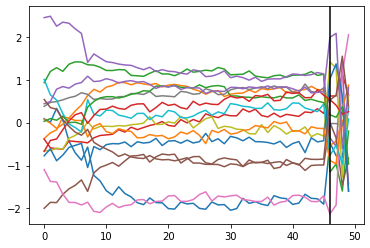

In [97]:
ax = pd.DataFrame(temporal_features[0,:,:]).plot(legend=False)
ax.axvline(x=temporal_hist_selected_vars.shape[1], color="black")

## Static enrichment

This step is responsible for adding static information on the country for which inflation is being nowcasted to the temporal features.

This is achieved by a GRN layer as follows:

$$
\theta(t, n) = \text{GRN}_{\theta}(\tilde{\phi}(t, n), c_e)
$$

In [98]:
def static_enrichment(
    temporal_features:keras.KerasTensor, # $\tilde{\phi}(t, n)$, temporal features of dimension (batch size / num historical + future time steps / embedding size)
    static_context:keras.KerasTensor, # $c_e$, static context enrichment vector of dimensions (batch size / num static vars / embedding size)
    hidden_layer_size:int, # Embedding size
    dropout_rate:float=0. # Dropout rate
):
    "Static enrichment"
    enriched, _ = gated_residual_network(
        temporal_features,
        hidden_layer_size=hidden_layer_size,
        dropout_rate=dropout_rate,
        use_time_distributed=True,
        additional_context=static_context
    )
    return enriched

In [99]:
show_doc(static_enrichment, title_level=3)

---

### static_enrichment

>      static_enrichment
>                         (temporal_features:keras.src.backend.common.keras_tens
>                         or.KerasTensor, static_context:keras.src.backend.commo
>                         n.keras_tensor.KerasTensor, hidden_layer_size:int,
>                         dropout_rate:float=0.0)

Static enrichment

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| temporal_features | keras.KerasTensor |  | $\tilde{\phi}(t, n)$, temporal features of dimension (batch size / num historical + future time steps / embedding size) |
| static_context | keras.KerasTensor |  | $c_e$, static context enrichment vector of dimensions (batch size / num static vars / embedding size) |
| hidden_layer_size | int |  | Embedding size |
| dropout_rate | float | 0.0 | Dropout rate |

#### Example usage, real data

The code below first creates an static context enrichment vector:

In [100]:
#| code-fold: show

static_context_enrichment, _ = gated_residual_network( # c_3
    x=xi_stat, # Network inputs
    hidden_layer_size=hidden_layer_size, # Dimension of the GRN
    output_size=hidden_layer_size, # Size of output layer (if None, same as `hidden_layer_size`)
    dropout_rate=0., # Dropout rate
    use_time_distributed=False, # Apply the GRN across all time steps?
)
static_context_enrichment.shape

TensorShape([32, 1, 16])

... and now it is used with the temporal features that are the output of `seq_to_seq` for the static enrichment.

In [101]:
enriched_temporal_features = static_enrichment(
    temporal_features=temporal_features,
    static_context=static_context_enrichment,
    hidden_layer_size=16
)
temporal_features.shape, enriched_temporal_features.shape

(TensorShape([32, 50, 16]), TensorShape([32, 50, 16]))

## Attention components

* Attention mechanisms use relationships between keys $K \in \mathbf{R}^{N \times d_{attention}}$ and queries $Q \in \mathbf{R}^{N \times d_{attention}}$ to scale a vector of values $V \in \mathbf{R}^{N \times d_V}$: $\text{Attention}(Q, K, V) = A(Q, K) V$
    * $N$ is the number of timesteps going into the attention layer (the number of lags $k$ plus the number of periods to be forecasted $\tau_{\text{max}}$)
    * $A(\cdot)$ is a normalisation function
        * After @vaswani2017attention, the canonical choice for $A(\cdot)$ is the scaled dot-product: $A(Q, K) = \text{Softmax}(\frac{Q K^{T}}{\sqrt{d_{attention}}} )$
    
* The TFT uses a modified attention head to enhance the explainability of the model
* Specifically, the transformer block (multi-head attention) is modified to:
    * share values in each head, and
    * employ additive aggregation of all heads
* More formally, compare the interpretable multi-head attention (used in this paper) with the canonical multi-head attention:
    * $\text{InterpretableMultiHead}(Q, K, V) = \tilde{H} W_{H}$, with:
        * $\begin{aligned}\tilde{H} &= \tilde{A}(Q, K) V W_V \\
        &= \{\frac{1}{m_H} \sum^{m_{H}}_{h=1} A(Q W^{(h)}_Q, K W^{(h)}_K) \} V W_V \\
        &= \frac{1}{m_H} \sum^{m_{H}}_{h=1} \text{Attention}(Q W^{(h)}_Q, K W^{(h)}_K, V W_V)
        \end{aligned}$
    * $\text{MultiHead}(Q, K, V) = [H_1, \dots, H_{m_H}] W_H$, with:
        * $H_h = \text{Attention}(Q W^{(h)}_Q, K W^{(h)}_K, V W_V^{(h)}) $

## Decoder mask for self-attention layer

In [202]:
def get_decoder_mask(
    self_attention_inputs # Inputs to the self-attention layer
):
    "Determines shape of decoder mask"
    len_s = keras.ops.shape(self_attention_inputs)[1] # length of inputs
    bs = keras.ops.shape(self_attention_inputs)[0] # batch shape
    mask = keras.ops.cumsum(keras.ops.eye(len_s), axis=0)

    ### warning: I had to manually implement some batch-wise shape here 
    ### because the new keras `eye` function does not have a batch_size arg.
    ### inspired by: https://github.com/tensorflow/tensorflow/blob/v2.14.0/tensorflow/python/ops/linalg_ops_impl.py#L30
    ### <hack>
    mask = keras.ops.expand_dims(mask, axis=0)    
    mask = keras.ops.tile(mask, (bs, 1, 1))
    ### </hack>

    return mask


In [203]:
#| output: asis
#| echo: false

show_doc(get_decoder_mask, title_level=3)

---

### get_decoder_mask

>      get_decoder_mask (self_attention_inputs)

Determines shape of decoder mask

|    | **Details** |
| -- | ----------- |
| self_attention_inputs | Inputs to the self-attention layer |

#### Example usage

In [204]:
#| code-fold: show

dec = get_decoder_mask(grn)

assert dec.shape == (grn.shape[0], grn.shape[1], grn.shape[1])

Note that it produces an upper-triangular matrix of ones:

In [205]:
#| code-fold: show

dec[0]

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]], dtype=float32)>

#### Example usage, real data

In [206]:
mask = get_decoder_mask(temporal_features)

print("Mask shape: (batch size / num time seos / num time steps)", mask.shape)

mask[0]

Mask shape: (batch size / num time seos / num time steps) (32, 50, 50)


<tf.Tensor: shape=(50, 50), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>

## Scaled dot product attention layer

* This is the same as Eq. (1) of @vaswani2017attention 
    * except that in this case the dimension of the value vector is the same $d_{\text{attn}} = d_{\text{model}} / m_{\text{Heads}}$ as for the query and key vectors
* As discussed in the paper, additive attention outperforms dot product attention for larger $d_{\text{model}}$ values, so the attention is scaled back to smaller values

In [426]:
class ScaledDotProductAttention(keras.Layer):
    def __init__(
        self,
        attention_dropout:float=0.0 # Will be ignored if `training=False`
    ):
        super().__init__()
        self.dropout = keras.layers.Dropout(rate=attention_dropout)
        self.activation = keras.layers.Activation('softmax')

    def __call__(
        self,
        q, # Queries, tensor of shape (?, time, D_model)
        k, # Keys, tensor of shape (?, time, D_model)
        v, # Values, tensor of shape (?, time, D_model)
        mask, # Masking if required (sets Softmax to very large value), tensor of shape (?, time, time)
        training=None, # Whether the layer is being trained or used in inference
    ):
        # returns Tuple (layer outputs, attention weights)
        scale = keras.ops.sqrt(keras.ops.cast(keras.ops.shape(k)[-1], dtype='float32'))
        attention = layers.Dot(axes=(2, 2))([q, k]) / scale
        #attention = keras.ops.einsum("bij,bjk->bik", q, keras.ops.transpose(k, axes=(0, 2, 1))) / scale
        if mask is not None:
            mmask = keras.layers.Lambda(lambda x: (-1e9) * (1. - keras.ops.cast(x, 'float32')))(mask)
            attention = keras.layers.Add()([attention, mmask])
        attention = self.activation(attention)
        if training:
            attention = self.dropout(attention)
        output = layers.Dot(axes=(2, 1))([attention, v])
        #output = keras.ops.einsum("btt,btd->bt", attention, v)
        return output, attention

In [427]:
#| output: asis
#| echo: false

show_doc(ScaledDotProductAttention, title_level=3)

---

### ScaledDotProductAttention

>      ScaledDotProductAttention (attention_dropout:float=0.0)

This is the class from which all layers inherit.

A layer is a callable object that takes as input one or more tensors and
that outputs one or more tensors. It involves *computation*, defined
in the `call()` method, and a *state* (weight variables). State can be
created:

* in `__init__()`, for instance via `self.add_weight()`;
* in the optional `build()` method, which is invoked by the first
  `__call__()` to the layer, and supplies the shape(s) of the input(s),
  which may not have been known at initialization time.

Layers are recursively composable: If you assign a Layer instance as an
attribute of another Layer, the outer layer will start tracking the weights
created by the inner layer. Nested layers should be instantiated in the
`__init__()` method or `build()` method.

Users will just instantiate a layer and then treat it as a callable.

Args:
    trainable: Boolean, whether the layer's variables should be trainable.
    name: String name of the layer.
    dtype: The dtype of the layer's computations and weights. Can also be a
        `keras.mixed_precision.DTypePolicy`,
        which allows the computation and
        weight dtype to differ. Defaults to `None`. `None` means to use
        `keras.mixed_precision.dtype_policy()`,
        which is a `float32` policy unless set to different value
        (via `keras.mixed_precision.set_dtype_policy()`).

Attributes:
    name: The name of the layer (string).
    dtype: Dtype of the layer's weights. Alias of `layer.variable_dtype`.
    variable_dtype: Dtype of the layer's weights.
    compute_dtype: The dtype of the layer's computations.
        Layers automatically cast inputs to this dtype, which causes
        the computations and output to also be in this dtype.
        When mixed precision is used with a
        `keras.mixed_precision.DTypePolicy`, this will be different
        than `variable_dtype`.
    trainable_weights: List of variables to be included in backprop.
    non_trainable_weights: List of variables that should not be
        included in backprop.
    weights: The concatenation of the lists trainable_weights and
        non_trainable_weights (in this order).
    trainable: Whether the layer should be trained (boolean), i.e.
        whether its potentially-trainable weights should be returned
        as part of `layer.trainable_weights`.
    input_spec: Optional (list of) `InputSpec` object(s) specifying the
        constraints on inputs that can be accepted by the layer.

We recommend that descendants of `Layer` implement the following methods:

* `__init__()`: Defines custom layer attributes, and creates layer weights
    that do not depend on input shapes, using `add_weight()`,
    or other state.
* `build(self, input_shape)`: This method can be used to create weights that
    depend on the shape(s) of the input(s), using `add_weight()`, or other
    state. `__call__()` will automatically build the layer
    (if it has not been built yet) by calling `build()`.
* `call(self, *args, **kwargs)`: Called in `__call__` after making
    sure `build()` has been called. `call()` performs the logic of applying
    the layer to the input arguments.
    Two reserved keyword arguments you can optionally use in `call()` are:
        1. `training` (boolean, whether the call is in inference mode or
            training mode).
        2. `mask` (boolean tensor encoding masked timesteps in the input,
            used e.g. in RNN layers).
    A typical signature for this method is `call(self, inputs)`, and user
    could optionally add `training` and `mask` if the layer need them.
* `get_config(self)`: Returns a dictionary containing the configuration
    used to initialize this layer. If the keys differ from the arguments
    in `__init__()`, then override `from_config(self)` as well.
    This method is used when saving
    the layer or a model that contains this layer.

Examples:

Here's a basic example: a layer with two variables, `w` and `b`,
that returns `y = w . x + b`.
It shows how to implement `build()` and `call()`.
Variables set as attributes of a layer are tracked as weights
of the layers (in `layer.weights`).

```python
class SimpleDense(Layer):
    def __init__(self, units=32):
        super().__init__()
        self.units = units

    # Create the state of the layer (weights)
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name="bias",
        )

    # Defines the computation
    def call(self, inputs):
        return ops.matmul(inputs, self.kernel) + self.bias

# Instantiates the layer.
linear_layer = SimpleDense(4)

# This will also call `build(input_shape)` and create the weights.
y = linear_layer(ops.ones((2, 2)))
assert len(linear_layer.weights) == 2

# These weights are trainable, so they're listed in `trainable_weights`:
assert len(linear_layer.trainable_weights) == 2
```

Besides trainable weights, updated via backpropagation during training,
layers can also have non-trainable weights. These weights are meant to
be updated manually during `call()`. Here's a example layer that computes
the running sum of its inputs:

```python
class ComputeSum(Layer):

  def __init__(self, input_dim):
      super(ComputeSum, self).__init__()
      # Create a non-trainable weight.
      self.total = self.add_weight(
        shape=(),
        initializer="zeros",
        trainable=False,
        name="total",
      )

  def call(self, inputs):
      self.total.assign(self.total + ops.sum(inputs))
      return self.total

my_sum = ComputeSum(2)
x = ops.ones((2, 2))
y = my_sum(x)

assert my_sum.weights == [my_sum.total]
assert my_sum.non_trainable_weights == [my_sum.total]
assert my_sum.trainable_weights == []
```

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| attention_dropout | float | 0.0 | Will be ignored if `training=False` |

#### Example usage
Below is an example of how the `ScaledDotProductAttention` layer works:

In [428]:
#| code-fold: show

batch_size = 3
n_timesteps = 5
n_features = 13

# input dimensions: batches / timesteps / features
x_btf = np.random.randn(batch_size*n_timesteps*n_features).reshape([batch_size, n_timesteps, n_features]) 

# using the same vector for q, k and v just to simplify
q=keras.ops.cast(x_btf, 'float32')
k=keras.ops.cast(x_btf, 'float32')
v=keras.ops.cast(x_btf, 'float32')

Testing without masking:

In [429]:
#| code-fold: show

output, attention = ScaledDotProductAttention()(q=q, k=k, v=v, mask=None)
output.shape, attention.shape

(TensorShape([3, 5, 13]), TensorShape([3, 5, 5]))

... and with masking:

In [430]:
#| code-fold: show

output, attention = ScaledDotProductAttention()(q=q, k=k, v=v, mask=get_decoder_mask(q))
output[0], attention[0] # both have shape (batch_size, n_timesteps)

(<tf.Tensor: shape=(5, 13), dtype=float32, numpy=
 array([[-0.91069293,  0.13869703,  0.6191777 ,  2.405255  ,  0.22406949,
          1.2002867 , -1.6223099 , -0.47927773,  1.4562802 , -0.5517716 ,
          0.9108935 ,  0.25956106, -0.16739903],
        [-0.3363618 , -1.043383  , -0.50445455,  0.4604777 , -0.73997223,
          0.40935206, -1.2217413 ,  0.88705325, -1.2263525 ,  0.11927815,
          0.26073894, -0.2970428 ,  0.6344603 ],
        [ 0.3471672 , -1.2793332 ,  1.5128777 ,  2.5097113 ,  0.81119514,
         -0.27628243,  1.3846031 ,  1.1189173 ,  0.09562166, -0.14088446,
          0.6930726 ,  1.2165234 , -0.5287067 ],
        [ 0.74439937, -0.96718305, -0.21848452,  1.2350887 ,  0.85063714,
          0.09248478,  1.2502959 ,  2.016675  ,  0.9196455 ,  0.8205144 ,
         -0.8176799 , -0.7430188 , -0.07861366],
        [-0.6927209 ,  0.16500664,  1.2157094 ,  1.0482123 , -0.6779729 ,
         -0.82269067,  0.45811984,  1.0077097 ,  0.26216462, -0.4875882 ,
          0.84

#### Example usage, real data

In [431]:
#| code-fold: show

mask = get_decoder_mask(enriched_temporal_features)

output, attention = ScaledDotProductAttention()(
    q=enriched_temporal_features,
    k=enriched_temporal_features,
    v=enriched_temporal_features,
    mask=mask
)

print("attention shape: (batch size / num time steps / embedding size)", output.shape)
print("attention shape: (batch size / num time steps / num time steps)", attention.shape)

attention shape: (batch size / num time steps / embedding size) (32, 50, 16)
attention shape: (batch size / num time steps / num time steps) (32, 50, 50)


The attention weights for the future periods are shown below.

In [432]:
attention[0,-xi_fut.shape[1]:]

<tf.Tensor: shape=(4, 50), dtype=float32, numpy=
array([[0.00717947, 0.00922811, 0.00996172, 0.01243274, 0.01602677,
        0.01823673, 0.02067438, 0.01477424, 0.01827877, 0.0184238 ,
        0.01932587, 0.01869928, 0.01876401, 0.01975751, 0.01933356,
        0.0192086 , 0.01917204, 0.02053537, 0.01849028, 0.01763347,
        0.01746607, 0.01774094, 0.01860469, 0.01960696, 0.01711626,
        0.0168783 , 0.01845233, 0.01823577, 0.01643671, 0.01565114,
        0.01858305, 0.01790316, 0.01768436, 0.01909736, 0.0179642 ,
        0.01887446, 0.0171216 , 0.01836189, 0.0187915 , 0.01640354,
        0.01594177, 0.01544374, 0.01622801, 0.01704139, 0.01706547,
        0.01602186, 0.20914678, 0.        , 0.        , 0.        ],
       [0.0059182 , 0.00752979, 0.00799431, 0.00981477, 0.01272475,
        0.01475282, 0.01681138, 0.01246208, 0.01528453, 0.01525417,
        0.0164278 , 0.01596267, 0.01580422, 0.01675451, 0.01612682,
        0.01638885, 0.01634335, 0.01743945, 0.01583842, 0.01481538

## Softmax

A small detour to illustrate the softmax function. 

The $i^{\text{th}}$ element of $\text{Softmax}(x)$, with $x \in \mathbf{R}^K$ is:

$$
\text{Softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^K e^{x_j}}
$$

For example, see the values below for an input vector $x$ ($K=5$ in this example):

In [433]:
#| code-fold: show

x = np.array([-np.Inf, -1., 0., 1., 3.])
keras.layers.Activation('softmax')(x)
print("x = ", x)
print("exp(x) = ", np.exp(x))
print("denominator (sum of exp(x_j), j=1,...,K) = ", sum(np.exp(x)))
print("softmax(x) = ", np.exp(x) / sum(np.exp(x)))
print("sum of softmax(x)_j, j=1,...,K = ", sum(np.exp(x) / sum(np.exp(x))))

x =  [-inf  -1.   0.   1.   3.]
exp(x) =  [ 0.          0.36787944  1.          2.71828183 20.08553692]
denominator (sum of exp(x_j), j=1,...,K) =  24.171698192818155
softmax(x) =  [0.         0.01521943 0.0413707  0.11245721 0.83095266]
sum of softmax(x)_j, j=1,...,K =  1.0


As can be seen above, the softmax function really makes the largest numbers stand out from the rest.

Note also that $-\infty$ results in 0.

## Interpretable Multi-head attention

* When values are shared in each head and then are aggregated additively, each head can still learn different temporal patterns (from their own unique queries and keys), but with the same input values.
    * In other words, they can be interpreted as an ensemble over the attention weights
    * the paper doesn't mention this explicitly, but the ensemble is equally-weighted - maybe there is some performance to be gained by having some way to weight the different attention heads 🤔, such as having a linear layer combining them... will explore in the future

In [449]:
class InterpretableMultiHeadAttention(keras.Layer):
    def __init__(
        self,
        n_head:int,
        d_model:int,
        dropout_rate:float, # Will be ignored if `training=False`
    ):
        super().__init__()
        self.n_head = n_head
        self.d_k = self.d_v = d_model // n_head # the original model divides by number of heads
        self.dropout_rate = dropout_rate

        # using the same value layer facilitates interpretability
        vs_layer = keras.layers.Dense(self.d_v, use_bias=False, name="Shared value")

        # creates list of queries, keys and values across heads
        self.qs_layers = self._build_layers(self.d_k, n_head)
        self.ks_layers = self._build_layers(self.d_k, n_head)
        self.vs_layers = [vs_layer for _ in range(n_head)]

        self.attention = ScaledDotProductAttention()
        self.w_o = keras.layers.Dense(self.d_v, use_bias=False, name="W_v") # W_v in Eqs. (14)-(16), output weight matrix to project internal state to the original TFT

    def __call__(
        self,
        q, # Queries, tensor of shape (?, time, D_model)
        k, # Keys, tensor of shape (?, time, D_model)
        v, # Values, tensor of shape (?, time, D_model)
        mask=None, # Masking if required (sets Softmax to very large value), tensor of shape (?, time, time)
        training=None
    ):
        heads = []
        attns = []
        for i in range(self.n_head):
            qs = self.qs_layers[i](q)
            ks = self.ks_layers[i](q)
            vs = self.vs_layers[i](v)
           
            head, attn = self.attention(qs, ks, vs, mask)
            if training:
                head = keras.layers.Dropout(self.dropout_rate)(head)
            heads.append(head)
            attns.append(attn)
        head = keras.ops.stack(heads) if self.n_head > 1 else heads[0]

        outputs = keras.ops.mean(heads, axis=0) if self.n_head > 1 else head # H_tilde
        outputs = self.w_o(outputs)
        if training:
            outputs = keras.layers.Dropout(self.dropout_rate)(outputs)

        return outputs, attn

    def _build_layers(self, d:int, n_head:int):
        return [keras.layers.Dense(d) for _ in range(n_head)]

In [450]:
#| output: asis
#| echo: false

show_doc(InterpretableMultiHeadAttention, title_level=3)

---

### InterpretableMultiHeadAttention

>      InterpretableMultiHeadAttention (n_head:int, d_model:int,
>                                       dropout_rate:float)

This is the class from which all layers inherit.

A layer is a callable object that takes as input one or more tensors and
that outputs one or more tensors. It involves *computation*, defined
in the `call()` method, and a *state* (weight variables). State can be
created:

* in `__init__()`, for instance via `self.add_weight()`;
* in the optional `build()` method, which is invoked by the first
  `__call__()` to the layer, and supplies the shape(s) of the input(s),
  which may not have been known at initialization time.

Layers are recursively composable: If you assign a Layer instance as an
attribute of another Layer, the outer layer will start tracking the weights
created by the inner layer. Nested layers should be instantiated in the
`__init__()` method or `build()` method.

Users will just instantiate a layer and then treat it as a callable.

Args:
    trainable: Boolean, whether the layer's variables should be trainable.
    name: String name of the layer.
    dtype: The dtype of the layer's computations and weights. Can also be a
        `keras.mixed_precision.DTypePolicy`,
        which allows the computation and
        weight dtype to differ. Defaults to `None`. `None` means to use
        `keras.mixed_precision.dtype_policy()`,
        which is a `float32` policy unless set to different value
        (via `keras.mixed_precision.set_dtype_policy()`).

Attributes:
    name: The name of the layer (string).
    dtype: Dtype of the layer's weights. Alias of `layer.variable_dtype`.
    variable_dtype: Dtype of the layer's weights.
    compute_dtype: The dtype of the layer's computations.
        Layers automatically cast inputs to this dtype, which causes
        the computations and output to also be in this dtype.
        When mixed precision is used with a
        `keras.mixed_precision.DTypePolicy`, this will be different
        than `variable_dtype`.
    trainable_weights: List of variables to be included in backprop.
    non_trainable_weights: List of variables that should not be
        included in backprop.
    weights: The concatenation of the lists trainable_weights and
        non_trainable_weights (in this order).
    trainable: Whether the layer should be trained (boolean), i.e.
        whether its potentially-trainable weights should be returned
        as part of `layer.trainable_weights`.
    input_spec: Optional (list of) `InputSpec` object(s) specifying the
        constraints on inputs that can be accepted by the layer.

We recommend that descendants of `Layer` implement the following methods:

* `__init__()`: Defines custom layer attributes, and creates layer weights
    that do not depend on input shapes, using `add_weight()`,
    or other state.
* `build(self, input_shape)`: This method can be used to create weights that
    depend on the shape(s) of the input(s), using `add_weight()`, or other
    state. `__call__()` will automatically build the layer
    (if it has not been built yet) by calling `build()`.
* `call(self, *args, **kwargs)`: Called in `__call__` after making
    sure `build()` has been called. `call()` performs the logic of applying
    the layer to the input arguments.
    Two reserved keyword arguments you can optionally use in `call()` are:
        1. `training` (boolean, whether the call is in inference mode or
            training mode).
        2. `mask` (boolean tensor encoding masked timesteps in the input,
            used e.g. in RNN layers).
    A typical signature for this method is `call(self, inputs)`, and user
    could optionally add `training` and `mask` if the layer need them.
* `get_config(self)`: Returns a dictionary containing the configuration
    used to initialize this layer. If the keys differ from the arguments
    in `__init__()`, then override `from_config(self)` as well.
    This method is used when saving
    the layer or a model that contains this layer.

Examples:

Here's a basic example: a layer with two variables, `w` and `b`,
that returns `y = w . x + b`.
It shows how to implement `build()` and `call()`.
Variables set as attributes of a layer are tracked as weights
of the layers (in `layer.weights`).

```python
class SimpleDense(Layer):
    def __init__(self, units=32):
        super().__init__()
        self.units = units

    # Create the state of the layer (weights)
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name="bias",
        )

    # Defines the computation
    def call(self, inputs):
        return ops.matmul(inputs, self.kernel) + self.bias

# Instantiates the layer.
linear_layer = SimpleDense(4)

# This will also call `build(input_shape)` and create the weights.
y = linear_layer(ops.ones((2, 2)))
assert len(linear_layer.weights) == 2

# These weights are trainable, so they're listed in `trainable_weights`:
assert len(linear_layer.trainable_weights) == 2
```

Besides trainable weights, updated via backpropagation during training,
layers can also have non-trainable weights. These weights are meant to
be updated manually during `call()`. Here's a example layer that computes
the running sum of its inputs:

```python
class ComputeSum(Layer):

  def __init__(self, input_dim):
      super(ComputeSum, self).__init__()
      # Create a non-trainable weight.
      self.total = self.add_weight(
        shape=(),
        initializer="zeros",
        trainable=False,
        name="total",
      )

  def call(self, inputs):
      self.total.assign(self.total + ops.sum(inputs))
      return self.total

my_sum = ComputeSum(2)
x = ops.ones((2, 2))
y = my_sum(x)

assert my_sum.weights == [my_sum.total]
assert my_sum.non_trainable_weights == [my_sum.total]
assert my_sum.trainable_weights == []
```

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| n_head | int |  |
| d_model | int |  |
| dropout_rate | float | Will be ignored if `training=False` |

#### Example usage

In [451]:
#| code-fold: show

imha = InterpretableMultiHeadAttention(n_head=8, d_model=16, dropout_rate=0.)

In [452]:
#| code-fold: show

grn.shape # B, T, F

TensorShape([32, 4, 17])

In [453]:
#| code-fold: show

mask = get_decoder_mask(grn)
mask.shape # shape (batch size / num time steps / num time steps)

TensorShape([32, 4, 4])

In [454]:
#| code-fold: show

output, attn = imha(grn, grn, grn, mask)
output.shape, attn.shape

(TensorShape([32, 4, 2]), TensorShape([32, 4, 4]))

#### Exampel usage, real data

In [455]:
#| code-fold: show

mask = get_decoder_mask(enriched_temporal_features)

output, attention = InterpretableMultiHeadAttention(
    n_head=1,
    d_model=16,
    dropout_rate=0.
)(
    q=enriched_temporal_features,
    k=enriched_temporal_features,
    v=enriched_temporal_features,
    mask=mask
)

print("attention shape: (batch size / num time steps / embedding size)", output.shape)
print("attention shape: (batch size / num time steps / num time steps)", attention.shape)

attention shape: (batch size / num time steps / embedding size) (32, 50, 16)
attention shape: (batch size / num time steps / num time steps) (32, 50, 50)


## Putting it all together: TFT

In [606]:
class TemporalFusionTransformer(keras.Model):
    def __init__(
        self,
        quantiles=[0.05, 0.25, 0.5, 0.75, 0.95],
        hidden_layer_size:int=16,
        n_head:int=4,
        dropout_rate:float=0.1,
        random_state:int=1985
    ):
        super().__init__()
        self.quantiles = quantiles
        self.hidden_layer_size = hidden_layer_size
        self.output_size = hidden_layer_size ### check this later, and define concretely what output size is
        self.n_head = n_head
        self.dropout_rate = dropout_rate
        self.random_state = random_state

        keras.utils.set_random_seed(self.random_state)

        self_attention = InterpretableMultiHeadAttention(
            n_head=self.n_head,
            d_model=self.hidden_layer_size,
            dropout_rate=self.dropout_rate
        )

    def call(
        self,
        inputs
    ):
        "Creates the model architecture"

        # embedding the inputs
        xi_hist, xi_stat, xi_fut = embed_input_batch(
            inputs, 
            hidden_layer_size=self.hidden_layer_size
        )

        # selecing the static covariates
        static_selected_vars, static_selection_weights = static_variable_selection(
            xi_stat, 
            hidden_layer_size=hidden_layer_size, 
            dropout_rate=0.
        )

        # create context vectors from static data
        static_context_variable_selection, _ = gated_residual_network(
            static_selected_vars,
            self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False
        )
        static_context_enrichment, _ = gated_residual_network(
            static_selected_vars,
            self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False
        )
        static_context_state_h, _ = gated_residual_network(
            static_selected_vars,
            self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False
        )
        static_context_state_c, _ = gated_residual_network(
            static_selected_vars,
            self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False
        )

        # temporal variable selection
        temporal_hist_selected_vars, temporal_hist_selection_weights = temporal_variable_selection(
            embedding=xi_hist,
            context=static_context_variable_selection,
            hidden_layer_size=hidden_layer_size, 
            dropout_rate=0.
        )

        temporal_fut_selected_vars, temporal_fut_selection_weights = temporal_variable_selection(
            embedding=xi_fut,
            context=static_context_variable_selection,
            hidden_layer_size=hidden_layer_size, 
            dropout_rate=self.dropout_rate
        )

        # sequence-to-sequence encoding
        temporal_features = seq_to_seq(
            hidden_layer_size=hidden_layer_size,
            dropout_rate=self.dropout_rate,
            historical_features=temporal_hist_selected_vars,
            future_features=temporal_fut_selected_vars,
            static_context_state_h=static_context_variable_selection,
            static_context_state_c=static_context_variable_selection
        )

        # static enrichment
        expanded_context = keras.ops.expand_dims(
            static_context_enrichment,
            axis=1
        )

        enriched_temporal_features = static_enrichment(
            temporal_features=temporal_features,
            static_context=expanded_context,
            hidden_layer_size=self.hidden_layer_size
        )

        mask = get_decoder_mask(enriched_temporal_features)

        features, self.attn_ = self.self_attention(
            q=enriched_temporal_features,
            k=enriched_temporal_features,
            v=enriched_temporal_features,
            mask=mask
        )

        # compare pre-attention features with post
        features, _ = apply_gating_layer(
            features,
            self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            activation=None
        )
        features = add_and_norm([features, enriched_temporal_features])

        # non-linear processing of self-attention output
        decoder, _ = gated_residual_network(
            features,
            hidden_layer_size=self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            use_time_distributed=True
        )

        # final skip connection
        decoder, _ = apply_gating_layer(
            decoder, 
            self.hidden_layer_size, 
            activation=None
        )
        transformer_layer = add_and_norm([decoder, temporal_features])

        # define the outputs
        output_len = self.output_size * len(self.quantiles)
        return layers.TimeDistributed(layers.Dense(output_len))(
            transformer_layer[:,xi_hist.shape[1]:,:]
        )

In [607]:
cont_hist, cat_hist, stat, fut, y = batch_breakdown(batch)

tft = TemporalFusionTransformer()
tft.compile()
output = tft.fit([cont_hist, cat_hist, stat, fut], y)

OperatorNotAllowedInGraphError: Exception encountered when calling TemporalFusionTransformer.call().

[1mIterating over a symbolic `tf.Tensor` is not allowed: AutoGraph is disabled in this function. Try decorating it directly with @tf.function.[0m

Arguments received by TemporalFusionTransformer.call():
  • inputs=('tf.Tensor(shape=(32, 46, 469), dtype=float32)', 'tf.Tensor(shape=(32, 46, 6), dtype=int64)', 'tf.Tensor(shape=(32, 1), dtype=int64)', 'tf.Tensor(shape=(32, 4, 6), dtype=int64)')

In [424]:
isinstance(output.xi_stat_, keras.KerasTensor)

AttributeError: 'NoneType' object has no attribute 'xi_stat_'

In [349]:
keras.Model([output.xi_hist_, output.xi_stat_, output.xi_fut_], output.outputs_)

ValueError: When providing `inputs` as a list/tuple, all values in the list/tuple must be KerasTensors. Received: inputs=[<tf.Tensor: shape=(32, 46, 16, 475), dtype=float32, numpy=
array([[[[ 0.00000000e+00,  0.00000000e+00,  2.18496472e-02, ...,
          -2.20401771e-02, -1.64263621e-02,  4.27503847e-02],
         [ 0.00000000e+00,  0.00000000e+00, -2.68033855e-02, ...,
          -2.04859860e-02, -2.68309470e-02, -4.97769229e-02],
         [ 0.00000000e+00,  0.00000000e+00, -3.77858616e-02, ...,
           2.44789459e-02,  1.35815144e-03,  1.92725994e-02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00, -1.43559482e-02, ...,
          -2.18223333e-02, -1.33654475e-02,  2.21703202e-03],
         [ 0.00000000e+00,  0.00000000e+00,  5.48760407e-02, ...,
           1.31265558e-02,  4.89929952e-02, -2.26508863e-02],
         [ 0.00000000e+00,  0.00000000e+00,  5.11630066e-02, ...,
           1.65799297e-02,  1.54378302e-02,  1.46477707e-02]],

        [[ 0.00000000e+00,  0.00000000e+00,  2.18496472e-02, ...,
           9.83031839e-03, -1.64263621e-02,  4.27503847e-02],
         [ 0.00000000e+00,  0.00000000e+00, -2.68033855e-02, ...,
          -5.38470596e-03, -2.68309470e-02, -4.97769229e-02],
         [ 0.00000000e+00,  0.00000000e+00, -3.77858616e-02, ...,
           2.19633691e-02,  1.35815144e-03,  1.92725994e-02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00, -1.43559482e-02, ...,
          -1.08414888e-03, -1.33654475e-02,  2.21703202e-03],
         [ 0.00000000e+00,  0.00000000e+00,  5.48760407e-02, ...,
           2.18555667e-02,  4.89929952e-02, -2.26508863e-02],
         [ 0.00000000e+00,  0.00000000e+00,  5.11630066e-02, ...,
          -2.32400186e-02,  1.54378302e-02,  1.46477707e-02]],

        [[ 0.00000000e+00,  0.00000000e+00,  2.18496472e-02, ...,
           9.83031839e-03,  5.67354262e-04,  4.27503847e-02],
         [ 0.00000000e+00,  0.00000000e+00, -2.68033855e-02, ...,
          -5.38470596e-03,  4.25073840e-02, -4.97769229e-02],
         [ 0.00000000e+00,  0.00000000e+00, -3.77858616e-02, ...,
           2.19633691e-02,  3.37014236e-02,  1.92725994e-02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00, -1.43559482e-02, ...,
          -1.08414888e-03,  3.10928263e-02,  2.21703202e-03],
         [ 0.00000000e+00,  0.00000000e+00,  5.48760407e-02, ...,
           2.18555667e-02,  4.32596244e-02, -2.26508863e-02],
         [ 0.00000000e+00,  0.00000000e+00,  5.11630066e-02, ...,
          -2.32400186e-02, -1.31756067e-03,  1.46477707e-02]],

        ...,

        [[ 0.00000000e+00,  0.00000000e+00,  5.68091460e-02, ...,
          -2.20401771e-02,  2.05167048e-02,  1.25189684e-02],
         [ 0.00000000e+00,  0.00000000e+00, -6.96888790e-02, ...,
          -2.04859860e-02,  3.69186327e-03, -1.02877021e-02],
         [ 0.00000000e+00,  0.00000000e+00, -9.82433483e-02, ...,
           2.44789459e-02,  3.53249051e-02,  3.46392132e-02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00, -3.73255052e-02, ...,
          -2.18223333e-02, -2.39134431e-02,  4.14256006e-03],
         [ 0.00000000e+00,  0.00000000e+00,  1.42677858e-01, ...,
           1.31265558e-02,  5.61147928e-03, -3.30035910e-02],
         [ 0.00000000e+00,  0.00000000e+00,  1.33023962e-01, ...,
           1.65799297e-02,  1.35014541e-02, -4.47083265e-04]],

        [[ 0.00000000e+00,  0.00000000e+00,  5.68091460e-02, ...,
          -2.20401771e-02,  2.05167048e-02,  1.25189684e-02],
         [ 0.00000000e+00,  0.00000000e+00, -6.96888790e-02, ...,
          -2.04859860e-02,  3.69186327e-03, -1.02877021e-02],
         [ 0.00000000e+00,  0.00000000e+00, -9.82433483e-02, ...,
           2.44789459e-02,  3.53249051e-02,  3.46392132e-02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00, -3.73255052e-02, ...,
          -2.18223333e-02, -2.39134431e-02,  4.14256006e-03],
         [ 0.00000000e+00,  0.00000000e+00,  1.42677858e-01, ...,
           1.31265558e-02,  5.61147928e-03, -3.30035910e-02],
         [ 0.00000000e+00,  0.00000000e+00,  1.33023962e-01, ...,
           1.65799297e-02,  1.35014541e-02, -4.47083265e-04]],

        [[ 0.00000000e+00,  0.00000000e+00,  5.68091460e-02, ...,
           9.83031839e-03,  2.05167048e-02,  1.25189684e-02],
         [ 0.00000000e+00,  0.00000000e+00, -6.96888790e-02, ...,
          -5.38470596e-03,  3.69186327e-03, -1.02877021e-02],
         [ 0.00000000e+00,  0.00000000e+00, -9.82433483e-02, ...,
           2.19633691e-02,  3.53249051e-02,  3.46392132e-02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00, -3.73255052e-02, ...,
          -1.08414888e-03, -2.39134431e-02,  4.14256006e-03],
         [ 0.00000000e+00,  0.00000000e+00,  1.42677858e-01, ...,
           2.18555667e-02,  5.61147928e-03, -3.30035910e-02],
         [ 0.00000000e+00,  0.00000000e+00,  1.33023962e-01, ...,
          -2.32400186e-02,  1.35014541e-02, -4.47083265e-04]]],


       [[[ 2.16661006e-01, -2.91725099e-01,  8.38718638e-02, ...,
           1.24730095e-02,  8.92139971e-04,  4.27503847e-02],
         [-2.26650238e-01,  2.83668548e-01, -1.02887236e-01, ...,
          -4.51336987e-02,  1.48208179e-02, -4.97769229e-02],
         [-4.37238097e-01, -3.26896787e-01, -1.45044461e-01, ...,
          -3.13115604e-02,  2.56952085e-02,  1.92725994e-02],
         ...,
         [-2.79530417e-02,  5.57351485e-02, -5.51066138e-02, ...,
           3.75657566e-02, -4.15609963e-02,  2.21703202e-03],
         [-2.09556788e-01, -3.65116417e-01,  2.10646674e-01, ...,
           2.21996568e-02,  1.09329000e-02, -2.26508863e-02],
         [-2.00707108e-01,  1.33638725e-01,  1.96393862e-01, ...,
           8.15007836e-03,  3.75181176e-02,  1.46477707e-02]],

        [[ 2.16661006e-01, -2.91725099e-01,  8.38718638e-02, ...,
           1.24730095e-02,  5.53978607e-03,  4.27503847e-02],
         [-2.26650238e-01,  2.83668548e-01, -1.02887236e-01, ...,
          -4.51336987e-02,  2.94634365e-02, -4.97769229e-02],
         [-4.37238097e-01, -3.26896787e-01, -1.45044461e-01, ...,
          -3.13115604e-02,  3.68326195e-02,  1.92725994e-02],
         ...,
         [-2.79530417e-02,  5.57351485e-02, -5.51066138e-02, ...,
           3.75657566e-02, -2.71530747e-02,  2.21703202e-03],
         [-2.09556788e-01, -3.65116417e-01,  2.10646674e-01, ...,
           2.21996568e-02, -4.37963754e-04, -2.26508863e-02],
         [-2.00707108e-01,  1.33638725e-01,  1.96393862e-01, ...,
           8.15007836e-03,  1.52104832e-02,  1.46477707e-02]],

        [[ 2.16661006e-01, -2.91725099e-01,  8.38718638e-02, ...,
           1.24730095e-02,  5.53978607e-03,  4.27503847e-02],
         [-2.26650238e-01,  2.83668548e-01, -1.02887236e-01, ...,
          -4.51336987e-02,  2.94634365e-02, -4.97769229e-02],
         [-4.37238097e-01, -3.26896787e-01, -1.45044461e-01, ...,
          -3.13115604e-02,  3.68326195e-02,  1.92725994e-02],
         ...,
         [-2.79530417e-02,  5.57351485e-02, -5.51066138e-02, ...,
           3.75657566e-02, -2.71530747e-02,  2.21703202e-03],
         [-2.09556788e-01, -3.65116417e-01,  2.10646674e-01, ...,
           2.21996568e-02, -4.37963754e-04, -2.26508863e-02],
         [-2.00707108e-01,  1.33638725e-01,  1.96393862e-01, ...,
           8.15007836e-03,  1.52104832e-02,  1.46477707e-02]],

        ...,

        [[ 2.46406436e-01, -2.53465533e-01,  1.14192337e-01, ...,
           1.24730095e-02,  3.86908166e-02, -2.38197334e-02],
         [-2.57767111e-01,  2.46465608e-01, -1.40081942e-01, ...,
          -4.51336987e-02,  1.80264562e-03, -3.30200195e-02],
         [-4.97266620e-01, -2.84024507e-01, -1.97479412e-01, ...,
          -3.13115604e-02,  5.43904305e-03,  2.26814672e-03],
         ...,
         [-3.17907222e-02,  4.84255217e-02, -7.50281736e-02, ...,
           3.75657566e-02, -3.40189487e-02,  9.97791439e-03],
         [-2.38326877e-01, -3.17231625e-01,  2.86797434e-01, ...,
           2.21996568e-02,  4.86984886e-02,  2.46389844e-02],
         [-2.28262231e-01,  1.16112098e-01,  2.67392099e-01, ...,
           8.15007836e-03,  2.40348279e-04,  4.31314595e-02]],

        [[ 2.46406436e-01, -2.53465533e-01,  1.14192337e-01, ...,
           1.24730095e-02,  3.86908166e-02, -2.38197334e-02],
         [-2.57767111e-01,  2.46465608e-01, -1.40081942e-01, ...,
          -4.51336987e-02,  1.80264562e-03, -3.30200195e-02],
         [-4.97266620e-01, -2.84024507e-01, -1.97479412e-01, ...,
          -3.13115604e-02,  5.43904305e-03,  2.26814672e-03],
         ...,
         [-3.17907222e-02,  4.84255217e-02, -7.50281736e-02, ...,
           3.75657566e-02, -3.40189487e-02,  9.97791439e-03],
         [-2.38326877e-01, -3.17231625e-01,  2.86797434e-01, ...,
           2.21996568e-02,  4.86984886e-02,  2.46389844e-02],
         [-2.28262231e-01,  1.16112098e-01,  2.67392099e-01, ...,
           8.15007836e-03,  2.40348279e-04,  4.31314595e-02]],

        [[ 2.46406436e-01, -2.53465533e-01,  1.14192337e-01, ...,
           1.24730095e-02,  3.86908166e-02, -2.38197334e-02],
         [-2.57767111e-01,  2.46465608e-01, -1.40081942e-01, ...,
          -4.51336987e-02,  1.80264562e-03, -3.30200195e-02],
         [-4.97266620e-01, -2.84024507e-01, -1.97479412e-01, ...,
          -3.13115604e-02,  5.43904305e-03,  2.26814672e-03],
         ...,
         [-3.17907222e-02,  4.84255217e-02, -7.50281736e-02, ...,
           3.75657566e-02, -3.40189487e-02,  9.97791439e-03],
         [-2.38326877e-01, -3.17231625e-01,  2.86797434e-01, ...,
           2.21996568e-02,  4.86984886e-02,  2.46389844e-02],
         [-2.28262231e-01,  1.16112098e-01,  2.67392099e-01, ...,
           8.15007836e-03,  2.40348279e-04,  4.31314595e-02]]],


       [[[-6.32491410e-02,  0.00000000e+00, -1.03694744e-01, ...,
          -2.20401771e-02,  2.05167048e-02,  1.25189684e-02],
         [ 6.61652684e-02,  0.00000000e+00,  1.27204344e-01, ...,
          -2.04859860e-02,  3.69186327e-03, -1.02877021e-02],
         [ 1.27641499e-01,  0.00000000e+00,  1.79325327e-01, ...,
           2.44789459e-02,  3.53249051e-02,  3.46392132e-02],
         ...,
         [ 8.16024095e-03,  0.00000000e+00,  6.81309104e-02, ...,
          -2.18223333e-02, -2.39134431e-02,  4.14256006e-03],
         [ 6.11752346e-02,  0.00000000e+00, -2.60432422e-01, ...,
           1.31265558e-02,  5.61147928e-03, -3.30035910e-02],
         [ 5.85917756e-02,  0.00000000e+00, -2.42811009e-01, ...,
           1.65799297e-02,  1.35014541e-02, -4.47083265e-04]],

        [[-6.32491410e-02,  0.00000000e+00, -1.03694744e-01, ...,
          -2.20401771e-02,  2.05167048e-02,  1.25189684e-02],
         [ 6.61652684e-02,  0.00000000e+00,  1.27204344e-01, ...,
          -2.04859860e-02,  3.69186327e-03, -1.02877021e-02],
         [ 1.27641499e-01,  0.00000000e+00,  1.79325327e-01, ...,
           2.44789459e-02,  3.53249051e-02,  3.46392132e-02],
         ...,
         [ 8.16024095e-03,  0.00000000e+00,  6.81309104e-02, ...,
          -2.18223333e-02, -2.39134431e-02,  4.14256006e-03],
         [ 6.11752346e-02,  0.00000000e+00, -2.60432422e-01, ...,
           1.31265558e-02,  5.61147928e-03, -3.30035910e-02],
         [ 5.85917756e-02,  0.00000000e+00, -2.42811009e-01, ...,
           1.65799297e-02,  1.35014541e-02, -4.47083265e-04]],

        [[-6.32491410e-02,  0.00000000e+00, -1.03694744e-01, ...,
          -2.20401771e-02,  2.05167048e-02,  1.25189684e-02],
         [ 6.61652684e-02,  0.00000000e+00,  1.27204344e-01, ...,
          -2.04859860e-02,  3.69186327e-03, -1.02877021e-02],
         [ 1.27641499e-01,  0.00000000e+00,  1.79325327e-01, ...,
           2.44789459e-02,  3.53249051e-02,  3.46392132e-02],
         ...,
         [ 8.16024095e-03,  0.00000000e+00,  6.81309104e-02, ...,
          -2.18223333e-02, -2.39134431e-02,  4.14256006e-03],
         [ 6.11752346e-02,  0.00000000e+00, -2.60432422e-01, ...,
           1.31265558e-02,  5.61147928e-03, -3.30035910e-02],
         [ 5.85917756e-02,  0.00000000e+00, -2.42811009e-01, ...,
           1.65799297e-02,  1.35014541e-02, -4.47083265e-04]],

        ...,

        [[-3.26196194e-01,  0.00000000e+00, -8.19586292e-02, ...,
          -2.20401771e-02, -3.92038114e-02, -8.01931694e-03],
         [ 3.41235608e-01,  0.00000000e+00,  1.00540228e-01, ...,
          -2.04859860e-02,  6.72934204e-03,  3.29489224e-02],
         [ 6.58288300e-01,  0.00000000e+00,  1.41735807e-01, ...,
           2.44789459e-02, -4.75015640e-02,  1.73096694e-02],
         ...,
         [ 4.20849919e-02,  0.00000000e+00,  5.38495518e-02, ...,
          -2.18223333e-02,  1.82582401e-02,  2.05442943e-02],
         [ 3.15500379e-01,  0.00000000e+00, -2.05841526e-01, ...,
           1.31265558e-02,  1.61223449e-02,  2.99942978e-02],
         [ 3.02176654e-01,  0.00000000e+00, -1.91913843e-01, ...,
           1.65799297e-02,  3.08091380e-02, -6.43799454e-03]],

        [[-3.26196194e-01,  0.00000000e+00, -8.19586292e-02, ...,
          -2.20401771e-02, -3.92038114e-02, -8.01931694e-03],
         [ 3.41235608e-01,  0.00000000e+00,  1.00540228e-01, ...,
          -2.04859860e-02,  6.72934204e-03,  3.29489224e-02],
         [ 6.58288300e-01,  0.00000000e+00,  1.41735807e-01, ...,
           2.44789459e-02, -4.75015640e-02,  1.73096694e-02],
         ...,
         [ 4.20849919e-02,  0.00000000e+00,  5.38495518e-02, ...,
          -2.18223333e-02,  1.82582401e-02,  2.05442943e-02],
         [ 3.15500379e-01,  0.00000000e+00, -2.05841526e-01, ...,
           1.31265558e-02,  1.61223449e-02,  2.99942978e-02],
         [ 3.02176654e-01,  0.00000000e+00, -1.91913843e-01, ...,
           1.65799297e-02,  3.08091380e-02, -6.43799454e-03]],

        [[-3.26196194e-01,  0.00000000e+00, -8.19586292e-02, ...,
          -2.20401771e-02,  4.53199409e-02, -8.01931694e-03],
         [ 3.41235608e-01,  0.00000000e+00,  1.00540228e-01, ...,
          -2.04859860e-02, -4.00886536e-02,  3.29489224e-02],
         [ 6.58288300e-01,  0.00000000e+00,  1.41735807e-01, ...,
           2.44789459e-02, -6.62088394e-04,  1.73096694e-02],
         ...,
         [ 4.20849919e-02,  0.00000000e+00,  5.38495518e-02, ...,
          -2.18223333e-02, -2.66220458e-02,  2.05442943e-02],
         [ 3.15500379e-01,  0.00000000e+00, -2.05841526e-01, ...,
           1.31265558e-02,  2.03120708e-03,  2.99942978e-02],
         [ 3.02176654e-01,  0.00000000e+00, -1.91913843e-01, ...,
           1.65799297e-02, -1.56689286e-02, -6.43799454e-03]]],


       ...,


       [[[ 0.00000000e+00,  0.00000000e+00, -1.42128253e-02, ...,
          -4.47353125e-02, -1.12035051e-02, -2.38197334e-02],
         [ 0.00000000e+00,  0.00000000e+00,  1.74351465e-02, ...,
          -2.82676574e-02, -4.59331386e-02, -3.30200195e-02],
         [ 0.00000000e+00,  0.00000000e+00,  2.45790612e-02, ...,
          -4.75537181e-02, -4.95409630e-02,  2.26814672e-03],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  9.33830068e-03, ...,
           1.85793526e-02, -6.95384666e-03,  9.97791439e-03],
         [ 0.00000000e+00,  0.00000000e+00, -3.56959328e-02, ...,
           3.60204689e-02,  4.86005098e-04,  2.46389844e-02],
         [ 0.00000000e+00,  0.00000000e+00, -3.32806669e-02, ...,
           4.00578640e-02,  3.26169617e-02,  4.31314595e-02]],

        [[ 0.00000000e+00,  0.00000000e+00, -1.42128253e-02, ...,
          -4.47353125e-02, -1.12035051e-02, -2.38197334e-02],
         [ 0.00000000e+00,  0.00000000e+00,  1.74351465e-02, ...,
          -2.82676574e-02, -4.59331386e-02, -3.30200195e-02],
         [ 0.00000000e+00,  0.00000000e+00,  2.45790612e-02, ...,
          -4.75537181e-02, -4.95409630e-02,  2.26814672e-03],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  9.33830068e-03, ...,
           1.85793526e-02, -6.95384666e-03,  9.97791439e-03],
         [ 0.00000000e+00,  0.00000000e+00, -3.56959328e-02, ...,
           3.60204689e-02,  4.86005098e-04,  2.46389844e-02],
         [ 0.00000000e+00,  0.00000000e+00, -3.32806669e-02, ...,
           4.00578640e-02,  3.26169617e-02,  4.31314595e-02]],

        [[ 0.00000000e+00,  0.00000000e+00, -1.42128253e-02, ...,
          -4.47353125e-02, -1.12035051e-02, -2.38197334e-02],
         [ 0.00000000e+00,  0.00000000e+00,  1.74351465e-02, ...,
          -2.82676574e-02, -4.59331386e-02, -3.30200195e-02],
         [ 0.00000000e+00,  0.00000000e+00,  2.45790612e-02, ...,
          -4.75537181e-02, -4.95409630e-02,  2.26814672e-03],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  9.33830068e-03, ...,
           1.85793526e-02, -6.95384666e-03,  9.97791439e-03],
         [ 0.00000000e+00,  0.00000000e+00, -3.56959328e-02, ...,
           3.60204689e-02,  4.86005098e-04,  2.46389844e-02],
         [ 0.00000000e+00,  0.00000000e+00, -3.32806669e-02, ...,
           4.00578640e-02,  3.26169617e-02,  4.31314595e-02]],

        ...,

        [[ 0.00000000e+00,  0.00000000e+00, -1.13281801e-01, ...,
          -4.47353125e-02,  1.25151873e-03,  3.79983336e-03],
         [ 0.00000000e+00,  0.00000000e+00,  1.38964966e-01, ...,
          -2.82676574e-02, -3.49746570e-02,  3.25029753e-02],
         [ 0.00000000e+00,  0.00000000e+00,  1.95904776e-01, ...,
          -4.75537181e-02, -1.94798596e-02,  2.38646381e-02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  7.44299218e-02, ...,
           1.85793526e-02, -1.45874508e-02,  2.59615108e-03],
         [ 0.00000000e+00,  0.00000000e+00, -2.84510612e-01, ...,
           3.60204689e-02,  4.46969979e-02, -2.23942995e-02],
         [ 0.00000000e+00,  0.00000000e+00, -2.65259981e-01, ...,
           4.00578640e-02, -4.49797288e-02, -1.87073722e-02]],

        [[ 0.00000000e+00,  0.00000000e+00, -1.13281801e-01, ...,
          -4.47353125e-02,  1.25151873e-03,  3.79983336e-03],
         [ 0.00000000e+00,  0.00000000e+00,  1.38964966e-01, ...,
          -2.82676574e-02, -3.49746570e-02,  3.25029753e-02],
         [ 0.00000000e+00,  0.00000000e+00,  1.95904776e-01, ...,
          -4.75537181e-02, -1.94798596e-02,  2.38646381e-02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  7.44299218e-02, ...,
           1.85793526e-02, -1.45874508e-02,  2.59615108e-03],
         [ 0.00000000e+00,  0.00000000e+00, -2.84510612e-01, ...,
           3.60204689e-02,  4.46969979e-02, -2.23942995e-02],
         [ 0.00000000e+00,  0.00000000e+00, -2.65259981e-01, ...,
           4.00578640e-02, -4.49797288e-02, -1.87073722e-02]],

        [[ 0.00000000e+00,  0.00000000e+00, -1.13281801e-01, ...,
          -4.47353125e-02,  4.84226681e-02,  3.79983336e-03],
         [ 0.00000000e+00,  0.00000000e+00,  1.38964966e-01, ...,
          -2.82676574e-02, -8.83784145e-03,  3.25029753e-02],
         [ 0.00000000e+00,  0.00000000e+00,  1.95904776e-01, ...,
          -4.75537181e-02,  3.24785970e-02,  2.38646381e-02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  7.44299218e-02, ...,
           1.85793526e-02,  8.43828917e-03,  2.59615108e-03],
         [ 0.00000000e+00,  0.00000000e+00, -2.84510612e-01, ...,
           3.60204689e-02,  4.64776419e-02, -2.23942995e-02],
         [ 0.00000000e+00,  0.00000000e+00, -2.65259981e-01, ...,
           4.00578640e-02, -3.96575779e-03, -1.87073722e-02]]],


       [[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.24730095e-02,  3.86908166e-02, -2.38197334e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -4.51336987e-02,  1.80264562e-03, -3.30200195e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -3.13115604e-02,  5.43904305e-03,  2.26814672e-03],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.75657566e-02, -3.40189487e-02,  9.97791439e-03],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           2.21996568e-02,  4.86984886e-02,  2.46389844e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           8.15007836e-03,  2.40348279e-04,  4.31314595e-02]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.24730095e-02, -3.35268863e-02, -2.38197334e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -4.51336987e-02, -4.21854258e-02, -3.30200195e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -3.13115604e-02,  1.17443502e-04,  2.26814672e-03],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.75657566e-02, -4.37151305e-02,  9.97791439e-03],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           2.21996568e-02,  3.14581729e-02,  2.46389844e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           8.15007836e-03,  2.97062732e-02,  4.31314595e-02]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.24730095e-02, -3.35268863e-02, -2.38197334e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -4.51336987e-02, -4.21854258e-02, -3.30200195e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -3.13115604e-02,  1.17443502e-04,  2.26814672e-03],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.75657566e-02, -4.37151305e-02,  9.97791439e-03],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           2.21996568e-02,  3.14581729e-02,  2.46389844e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           8.15007836e-03,  2.97062732e-02,  4.31314595e-02]],

        ...,

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.24730095e-02,  3.10289897e-02,  3.79983336e-03],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -4.51336987e-02, -1.81411877e-02,  3.25029753e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -3.13115604e-02, -4.50921319e-02,  2.38646381e-02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.75657566e-02,  1.55819580e-03,  2.59615108e-03],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           2.21996568e-02,  4.69363444e-02, -2.23942995e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           8.15007836e-03,  7.64248520e-03, -1.87073722e-02]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.24730095e-02,  3.10289897e-02,  3.79983336e-03],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -4.51336987e-02, -1.81411877e-02,  3.25029753e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -3.13115604e-02, -4.50921319e-02,  2.38646381e-02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.75657566e-02,  1.55819580e-03,  2.59615108e-03],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           2.21996568e-02,  4.69363444e-02, -2.23942995e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           8.15007836e-03,  7.64248520e-03, -1.87073722e-02]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.24730095e-02,  3.10289897e-02,  3.79983336e-03],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -4.51336987e-02, -1.81411877e-02,  3.25029753e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -3.13115604e-02, -4.50921319e-02,  2.38646381e-02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.75657566e-02,  1.55819580e-03,  2.59615108e-03],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           2.21996568e-02,  4.69363444e-02, -2.23942995e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           8.15007836e-03,  7.64248520e-03, -1.87073722e-02]]],


       [[[ 5.46917617e-01, -9.17004287e-01,  2.35914171e-01, ...,
           1.24730095e-02,  8.92139971e-04,  4.27503847e-02],
         [-5.72133482e-01,  8.91679466e-01, -2.89400488e-01, ...,
          -4.51336987e-02,  1.48208179e-02, -4.97769229e-02],
         [-1.10372066e+00, -1.02756250e+00, -4.07980055e-01, ...,
          -3.13115604e-02,  2.56952085e-02,  1.92725994e-02],
         ...,
         [-7.05619007e-02,  1.75197035e-01, -1.55003488e-01, ...,
           3.75657566e-02, -4.15609963e-02,  2.21703202e-03],
         [-5.28984487e-01, -1.14770150e+00,  5.92505455e-01, ...,
           2.21996568e-02,  1.09329000e-02, -2.26508863e-02],
         [-5.06645203e-01,  4.20077980e-01,  5.52415252e-01, ...,
           8.15007836e-03,  3.75181176e-02,  1.46477707e-02]],

        [[ 5.46917617e-01, -9.17004287e-01,  2.35914171e-01, ...,
           1.24730095e-02,  5.53978607e-03,  4.27503847e-02],
         [-5.72133482e-01,  8.91679466e-01, -2.89400488e-01, ...,
          -4.51336987e-02,  2.94634365e-02, -4.97769229e-02],
         [-1.10372066e+00, -1.02756250e+00, -4.07980055e-01, ...,
          -3.13115604e-02,  3.68326195e-02,  1.92725994e-02],
         ...,
         [-7.05619007e-02,  1.75197035e-01, -1.55003488e-01, ...,
           3.75657566e-02, -2.71530747e-02,  2.21703202e-03],
         [-5.28984487e-01, -1.14770150e+00,  5.92505455e-01, ...,
           2.21996568e-02, -4.37963754e-04, -2.26508863e-02],
         [-5.06645203e-01,  4.20077980e-01,  5.52415252e-01, ...,
           8.15007836e-03,  1.52104832e-02,  1.46477707e-02]],

        [[ 5.46917617e-01, -9.17004287e-01,  2.35914171e-01, ...,
           1.24730095e-02,  5.53978607e-03,  4.27503847e-02],
         [-5.72133482e-01,  8.91679466e-01, -2.89400488e-01, ...,
          -4.51336987e-02,  2.94634365e-02, -4.97769229e-02],
         [-1.10372066e+00, -1.02756250e+00, -4.07980055e-01, ...,
          -3.13115604e-02,  3.68326195e-02,  1.92725994e-02],
         ...,
         [-7.05619007e-02,  1.75197035e-01, -1.55003488e-01, ...,
           3.75657566e-02, -2.71530747e-02,  2.21703202e-03],
         [-5.28984487e-01, -1.14770150e+00,  5.92505455e-01, ...,
           2.21996568e-02, -4.37963754e-04, -2.26508863e-02],
         [-5.06645203e-01,  4.20077980e-01,  5.52415252e-01, ...,
           8.15007836e-03,  1.52104832e-02,  1.46477707e-02]],

        ...,

        [[ 5.20474613e-01, -6.07757032e-01,  1.57721862e-01, ...,
           1.24730095e-02,  3.86908166e-02, -2.38197334e-02],
         [-5.44471264e-01,  5.90972662e-01, -1.93480447e-01, ...,
          -4.51336987e-02,  1.80264562e-03, -3.30200195e-02],
         [-1.05035663e+00, -6.81030989e-01, -2.72757530e-01, ...,
          -3.13115604e-02,  5.43904305e-03,  2.26814672e-03],
         ...,
         [-6.71502873e-02,  1.16114207e-01, -1.03628524e-01, ...,
           3.75657566e-02, -3.40189487e-02,  9.97791439e-03],
         [-5.03408492e-01, -7.60654688e-01,  3.96123141e-01, ...,
           2.21996568e-02,  4.86984886e-02,  2.46389844e-02],
         [-4.82149303e-01,  2.78412372e-01,  3.69320571e-01, ...,
           8.15007836e-03,  2.40348279e-04,  4.31314595e-02]],

        [[ 5.20474613e-01, -6.07757032e-01,  1.57721862e-01, ...,
           1.24730095e-02,  3.86908166e-02, -2.38197334e-02],
         [-5.44471264e-01,  5.90972662e-01, -1.93480447e-01, ...,
          -4.51336987e-02,  1.80264562e-03, -3.30200195e-02],
         [-1.05035663e+00, -6.81030989e-01, -2.72757530e-01, ...,
          -3.13115604e-02,  5.43904305e-03,  2.26814672e-03],
         ...,
         [-6.71502873e-02,  1.16114207e-01, -1.03628524e-01, ...,
           3.75657566e-02, -3.40189487e-02,  9.97791439e-03],
         [-5.03408492e-01, -7.60654688e-01,  3.96123141e-01, ...,
           2.21996568e-02,  4.86984886e-02,  2.46389844e-02],
         [-4.82149303e-01,  2.78412372e-01,  3.69320571e-01, ...,
           8.15007836e-03,  2.40348279e-04,  4.31314595e-02]],

        [[ 5.20474613e-01, -6.07757032e-01,  1.57721862e-01, ...,
           1.24730095e-02,  3.86908166e-02, -2.38197334e-02],
         [-5.44471264e-01,  5.90972662e-01, -1.93480447e-01, ...,
          -4.51336987e-02,  1.80264562e-03, -3.30200195e-02],
         [-1.05035663e+00, -6.81030989e-01, -2.72757530e-01, ...,
          -3.13115604e-02,  5.43904305e-03,  2.26814672e-03],
         ...,
         [-6.71502873e-02,  1.16114207e-01, -1.03628524e-01, ...,
           3.75657566e-02, -3.40189487e-02,  9.97791439e-03],
         [-5.03408492e-01, -7.60654688e-01,  3.96123141e-01, ...,
           2.21996568e-02,  4.86984886e-02,  2.46389844e-02],
         [-4.82149303e-01,  2.78412372e-01,  3.69320571e-01, ...,
           8.15007836e-03,  2.40348279e-04,  4.31314595e-02]]]],
      dtype=float32)>, <tf.Tensor: shape=(32, 1, 16), dtype=float32, numpy=
array([[[ 0.01367773,  0.01393903,  0.02413628,  0.04123585,
         -0.0079174 ,  0.03013668,  0.02351352,  0.03384661,
         -0.02560337, -0.04117769, -0.0068952 , -0.04605459,
          0.03050618,  0.03388815, -0.00991892,  0.00033727]],

       [[ 0.03163742,  0.03941795, -0.02040954, -0.04377819,
         -0.02589905,  0.02433037,  0.00262005, -0.04274675,
         -0.04424676, -0.02528241,  0.03051526, -0.01966147,
          0.02623994,  0.00499401, -0.03329001,  0.04403193]],

       [[ 0.01236486,  0.00743322,  0.01660272, -0.01560928,
         -0.03851102,  0.01152166, -0.01449959,  0.01699063,
          0.02760727,  0.00426737,  0.03049031,  0.00379971,
          0.00074186,  0.03068015, -0.02378773, -0.01574974]],

       [[-0.02569238,  0.02731929, -0.01831498, -0.0273936 ,
         -0.04096366, -0.00804909, -0.00094604, -0.00423449,
          0.00449251, -0.00823537, -0.01123286, -0.02276496,
          0.02101711,  0.01543199,  0.04557383, -0.04866995]],

       [[-0.04882399, -0.00769752, -0.02448298, -0.02443039,
         -0.03561131,  0.01982493,  0.00782708, -0.04334041,
          0.01473654,  0.0386772 ,  0.0417198 ,  0.01584746,
          0.03912615, -0.04004706,  0.01512542,  0.00289905]],

       [[-0.02569238,  0.02731929, -0.01831498, -0.0273936 ,
         -0.04096366, -0.00804909, -0.00094604, -0.00423449,
          0.00449251, -0.00823537, -0.01123286, -0.02276496,
          0.02101711,  0.01543199,  0.04557383, -0.04866995]],

       [[-0.04882399, -0.00769752, -0.02448298, -0.02443039,
         -0.03561131,  0.01982493,  0.00782708, -0.04334041,
          0.01473654,  0.0386772 ,  0.0417198 ,  0.01584746,
          0.03912615, -0.04004706,  0.01512542,  0.00289905]],

       [[ 0.01236486,  0.00743322,  0.01660272, -0.01560928,
         -0.03851102,  0.01152166, -0.01449959,  0.01699063,
          0.02760727,  0.00426737,  0.03049031,  0.00379971,
          0.00074186,  0.03068015, -0.02378773, -0.01574974]],

       [[-0.0409057 , -0.03831873,  0.00202967, -0.04380018,
         -0.03911445, -0.02669935,  0.04757234,  0.03601602,
         -0.01144142, -0.00086079, -0.00354493,  0.02639282,
         -0.00484949,  0.03563858, -0.0273814 ,  0.01993407]],

       [[ 0.01236486,  0.00743322,  0.01660272, -0.01560928,
         -0.03851102,  0.01152166, -0.01449959,  0.01699063,
          0.02760727,  0.00426737,  0.03049031,  0.00379971,
          0.00074186,  0.03068015, -0.02378773, -0.01574974]],

       [[-0.02569238,  0.02731929, -0.01831498, -0.0273936 ,
         -0.04096366, -0.00804909, -0.00094604, -0.00423449,
          0.00449251, -0.00823537, -0.01123286, -0.02276496,
          0.02101711,  0.01543199,  0.04557383, -0.04866995]],

       [[-0.02569238,  0.02731929, -0.01831498, -0.0273936 ,
         -0.04096366, -0.00804909, -0.00094604, -0.00423449,
          0.00449251, -0.00823537, -0.01123286, -0.02276496,
          0.02101711,  0.01543199,  0.04557383, -0.04866995]],

       [[ 0.01236486,  0.00743322,  0.01660272, -0.01560928,
         -0.03851102,  0.01152166, -0.01449959,  0.01699063,
          0.02760727,  0.00426737,  0.03049031,  0.00379971,
          0.00074186,  0.03068015, -0.02378773, -0.01574974]],

       [[-0.0409057 , -0.03831873,  0.00202967, -0.04380018,
         -0.03911445, -0.02669935,  0.04757234,  0.03601602,
         -0.01144142, -0.00086079, -0.00354493,  0.02639282,
         -0.00484949,  0.03563858, -0.0273814 ,  0.01993407]],

       [[ 0.01367773,  0.01393903,  0.02413628,  0.04123585,
         -0.0079174 ,  0.03013668,  0.02351352,  0.03384661,
         -0.02560337, -0.04117769, -0.0068952 , -0.04605459,
          0.03050618,  0.03388815, -0.00991892,  0.00033727]],

       [[ 0.01236486,  0.00743322,  0.01660272, -0.01560928,
         -0.03851102,  0.01152166, -0.01449959,  0.01699063,
          0.02760727,  0.00426737,  0.03049031,  0.00379971,
          0.00074186,  0.03068015, -0.02378773, -0.01574974]],

       [[-0.02569238,  0.02731929, -0.01831498, -0.0273936 ,
         -0.04096366, -0.00804909, -0.00094604, -0.00423449,
          0.00449251, -0.00823537, -0.01123286, -0.02276496,
          0.02101711,  0.01543199,  0.04557383, -0.04866995]],

       [[ 0.01236486,  0.00743322,  0.01660272, -0.01560928,
         -0.03851102,  0.01152166, -0.01449959,  0.01699063,
          0.02760727,  0.00426737,  0.03049031,  0.00379971,
          0.00074186,  0.03068015, -0.02378773, -0.01574974]],

       [[-0.04882399, -0.00769752, -0.02448298, -0.02443039,
         -0.03561131,  0.01982493,  0.00782708, -0.04334041,
          0.01473654,  0.0386772 ,  0.0417198 ,  0.01584746,
          0.03912615, -0.04004706,  0.01512542,  0.00289905]],

       [[ 0.01367773,  0.01393903,  0.02413628,  0.04123585,
         -0.0079174 ,  0.03013668,  0.02351352,  0.03384661,
         -0.02560337, -0.04117769, -0.0068952 , -0.04605459,
          0.03050618,  0.03388815, -0.00991892,  0.00033727]],

       [[-0.0409057 , -0.03831873,  0.00202967, -0.04380018,
         -0.03911445, -0.02669935,  0.04757234,  0.03601602,
         -0.01144142, -0.00086079, -0.00354493,  0.02639282,
         -0.00484949,  0.03563858, -0.0273814 ,  0.01993407]],

       [[ 0.01236486,  0.00743322,  0.01660272, -0.01560928,
         -0.03851102,  0.01152166, -0.01449959,  0.01699063,
          0.02760727,  0.00426737,  0.03049031,  0.00379971,
          0.00074186,  0.03068015, -0.02378773, -0.01574974]],

       [[ 0.01236486,  0.00743322,  0.01660272, -0.01560928,
         -0.03851102,  0.01152166, -0.01449959,  0.01699063,
          0.02760727,  0.00426737,  0.03049031,  0.00379971,
          0.00074186,  0.03068015, -0.02378773, -0.01574974]],

       [[-0.04882399, -0.00769752, -0.02448298, -0.02443039,
         -0.03561131,  0.01982493,  0.00782708, -0.04334041,
          0.01473654,  0.0386772 ,  0.0417198 ,  0.01584746,
          0.03912615, -0.04004706,  0.01512542,  0.00289905]],

       [[ 0.01236486,  0.00743322,  0.01660272, -0.01560928,
         -0.03851102,  0.01152166, -0.01449959,  0.01699063,
          0.02760727,  0.00426737,  0.03049031,  0.00379971,
          0.00074186,  0.03068015, -0.02378773, -0.01574974]],

       [[-0.04882399, -0.00769752, -0.02448298, -0.02443039,
         -0.03561131,  0.01982493,  0.00782708, -0.04334041,
          0.01473654,  0.0386772 ,  0.0417198 ,  0.01584746,
          0.03912615, -0.04004706,  0.01512542,  0.00289905]],

       [[ 0.01236486,  0.00743322,  0.01660272, -0.01560928,
         -0.03851102,  0.01152166, -0.01449959,  0.01699063,
          0.02760727,  0.00426737,  0.03049031,  0.00379971,
          0.00074186,  0.03068015, -0.02378773, -0.01574974]],

       [[-0.02569238,  0.02731929, -0.01831498, -0.0273936 ,
         -0.04096366, -0.00804909, -0.00094604, -0.00423449,
          0.00449251, -0.00823537, -0.01123286, -0.02276496,
          0.02101711,  0.01543199,  0.04557383, -0.04866995]],

       [[-0.02569238,  0.02731929, -0.01831498, -0.0273936 ,
         -0.04096366, -0.00804909, -0.00094604, -0.00423449,
          0.00449251, -0.00823537, -0.01123286, -0.02276496,
          0.02101711,  0.01543199,  0.04557383, -0.04866995]],

       [[-0.02569238,  0.02731929, -0.01831498, -0.0273936 ,
         -0.04096366, -0.00804909, -0.00094604, -0.00423449,
          0.00449251, -0.00823537, -0.01123286, -0.02276496,
          0.02101711,  0.01543199,  0.04557383, -0.04866995]],

       [[ 0.01367773,  0.01393903,  0.02413628,  0.04123585,
         -0.0079174 ,  0.03013668,  0.02351352,  0.03384661,
         -0.02560337, -0.04117769, -0.0068952 , -0.04605459,
          0.03050618,  0.03388815, -0.00991892,  0.00033727]],

       [[ 0.03163742,  0.03941795, -0.02040954, -0.04377819,
         -0.02589905,  0.02433037,  0.00262005, -0.04274675,
         -0.04424676, -0.02528241,  0.03051526, -0.01966147,
          0.02623994,  0.00499401, -0.03329001,  0.04403193]]],
      dtype=float32)>, <tf.Tensor: shape=(32, 4, 16, 6), dtype=float32, numpy=
array([[[[ 0.0109511 ,  0.03610087,  0.04610339, -0.0415049 ,
          -0.0442022 , -0.0219568 ],
         [ 0.02496533,  0.01486589,  0.02270514, -0.00181576,
          -0.03953576, -0.04920017],
         [-0.00219219,  0.03600432,  0.0255234 , -0.01554136,
          -0.01413125,  0.01171279],
         ...,
         [-0.00881938, -0.03511069,  0.01581821,  0.02001537,
          -0.03203366, -0.01598939],
         [-0.01923521,  0.00602571,  0.00322897,  0.03115794,
           0.0410418 , -0.04700213],
         [-0.02291131, -0.0089618 ,  0.04931578,  0.02401818,
          -0.01816624,  0.0070635 ]],

        [[ 0.0109511 ,  0.01549411, -0.02396277, -0.0415049 ,
          -0.0442022 , -0.0219568 ],
         [ 0.02496533,  0.00398028,  0.03505779, -0.00181576,
          -0.03953576, -0.04920017],
         [-0.00219219, -0.00540942,  0.01230038, -0.01554136,
          -0.01413125,  0.01171279],
         ...,
         [-0.00881938, -0.00636424,  0.0203029 ,  0.02001537,
          -0.03203366, -0.01598939],
         [-0.01923521,  0.01308158,  0.02314356,  0.03115794,
           0.0410418 , -0.04700213],
         [-0.02291131, -0.01997076, -0.02627478,  0.02401818,
          -0.01816624,  0.0070635 ]],

        [[-0.01464139,  0.0307782 ,  0.02635983, -0.0415049 ,
          -0.03789721, -0.0219568 ],
         [-0.01272694,  0.02138226, -0.02253085, -0.00181576,
           0.04093063, -0.04920017],
         [ 0.04102187, -0.0024279 ,  0.03122833, -0.01554136,
           0.04717064,  0.01171279],
         ...,
         [-0.00574001,  0.01064354,  0.01328823,  0.02001537,
          -0.01265565, -0.01598939],
         [ 0.03085097,  0.02246407,  0.01324657,  0.03115794,
          -0.02854909, -0.04700213],
         [-0.01981063,  0.04882339,  0.04388405,  0.02401818,
           0.04668147,  0.0070635 ]],

        [[-0.04530204,  0.01823926,  0.03100557, -0.0415049 ,
          -0.03789721, -0.0219568 ],
         [ 0.01262579,  0.01525148, -0.01548349, -0.00181576,
           0.04093063, -0.04920017],
         [ 0.02978021, -0.03750343, -0.04254699, -0.01554136,
           0.04717064,  0.01171279],
         ...,
         [ 0.0301326 , -0.00217909, -0.00525505,  0.02001537,
          -0.01265565, -0.01598939],
         [ 0.01674945,  0.04102986, -0.01329303,  0.03115794,
          -0.02854909, -0.04700213],
         [ 0.00466435, -0.02306916,  0.01388456,  0.02401818,
           0.04668147,  0.0070635 ]]],


       [[[ 0.0109511 ,  0.01549411, -0.01852662, -0.0415049 ,
           0.00115145,  0.03259665],
         [ 0.02496533,  0.00398028, -0.04488045, -0.00181576,
           0.00079449, -0.03106465],
         [-0.00219219, -0.00540942,  0.0220547 , -0.01554136,
           0.03316077,  0.04812158],
         ...,
         [-0.00881938, -0.00636424, -0.0010466 ,  0.02001537,
          -0.02866749, -0.04862437],
         [-0.01923521,  0.01308158, -0.03747282,  0.03115794,
          -0.0421314 ,  0.01488401],
         [-0.02291131, -0.01997076, -0.03976776,  0.02401818,
           0.02408816,  0.00926337]],

        [[ 0.0109511 ,  0.0307782 ,  0.02197887, -0.0415049 ,
           0.00115145,  0.03259665],
         [ 0.02496533,  0.02138226,  0.00905072, -0.00181576,
           0.00079449, -0.03106465],
         [-0.00219219, -0.0024279 ,  0.01132591, -0.01554136,
           0.03316077,  0.04812158],
         ...,
         [-0.00881938,  0.01064354,  0.01189481,  0.02001537,
          -0.02866749, -0.04862437],
         [-0.01923521,  0.02246407, -0.03007541,  0.03115794,
          -0.0421314 ,  0.01488401],
         [-0.02291131,  0.04882339, -0.04720589,  0.02401818,
           0.02408816,  0.00926337]],

        [[ 0.0109511 ,  0.01823926, -0.00884878, -0.0415049 ,
           0.00115145,  0.03259665],
         [ 0.02496533,  0.01525148,  0.01131616, -0.00181576,
           0.00079449, -0.03106465],
         [-0.00219219, -0.03750343, -0.01960427, -0.01554136,
           0.03316077,  0.04812158],
         ...,
         [-0.00881938, -0.00217909, -0.03508303,  0.02001537,
          -0.02866749, -0.04862437],
         [-0.01923521,  0.04102986,  0.04107027,  0.03115794,
          -0.0421314 ,  0.01488401],
         [-0.02291131, -0.02306916,  0.04211284,  0.02401818,
           0.02408816,  0.00926337]],

        [[-0.01464139,  0.01823926,  0.0121373 , -0.0415049 ,
          -0.03157008,  0.03259665],
         [-0.01272694,  0.01525148, -0.00716174, -0.00181576,
           0.02283997, -0.03106465],
         [ 0.04102187, -0.03750343, -0.01020783, -0.01554136,
           0.02776856,  0.04812158],
         ...,
         [-0.00574001, -0.00217909,  0.00673987,  0.02001537,
           0.03199127, -0.04862437],
         [ 0.03085097,  0.04102986,  0.04944333,  0.03115794,
           0.01427462,  0.01488401],
         [-0.01981063, -0.02306916,  0.01709734,  0.02401818,
          -0.00409435,  0.00926337]]],


       [[[ 0.0109511 ,  0.03610087,  0.04514042, -0.0415049 ,
           0.01403424,  0.04724621],
         [ 0.02496533,  0.01486589,  0.01813307, -0.00181576,
          -0.02638553, -0.00070966],
         [-0.00219219,  0.03600432, -0.02706952, -0.01554136,
           0.01807951,  0.01644113],
         ...,
         [-0.00881938, -0.03511069, -0.00645033,  0.02001537,
          -0.02907404,  0.01911739],
         [-0.01923521,  0.00602571,  0.01413261,  0.03115794,
           0.04855694, -0.00331102],
         [-0.02291131, -0.0089618 , -0.00632196,  0.02401818,
          -0.00690227, -0.03273822]],

        [[ 0.0109511 ,  0.01549411,  0.03509459, -0.0415049 ,
           0.01403424,  0.04724621],
         [ 0.02496533,  0.00398028,  0.00942203, -0.00181576,
          -0.02638553, -0.00070966],
         [-0.00219219, -0.00540942,  0.04982712, -0.01554136,
           0.01807951,  0.01644113],
         ...,
         [-0.00881938, -0.00636424, -0.02962065,  0.02001537,
          -0.02907404,  0.01911739],
         [-0.01923521,  0.01308158,  0.04161841,  0.03115794,
           0.04855694, -0.00331102],
         [-0.02291131, -0.01997076, -0.04849439,  0.02401818,
          -0.00690227, -0.03273822]],

        [[ 0.0109511 ,  0.0307782 ,  0.03840746, -0.0415049 ,
           0.01403424,  0.04724621],
         [ 0.02496533,  0.02138226,  0.04042898, -0.00181576,
          -0.02638553, -0.00070966],
         [-0.00219219, -0.0024279 , -0.02784744, -0.01554136,
           0.01807951,  0.01644113],
         ...,
         [-0.00881938,  0.01064354,  0.02672299,  0.02001537,
          -0.02907404,  0.01911739],
         [-0.01923521,  0.02246407, -0.01181998,  0.03115794,
           0.04855694, -0.00331102],
         [-0.02291131,  0.04882339, -0.04315611,  0.02401818,
          -0.00690227, -0.03273822]],

        [[-0.01464139,  0.01823926, -0.02569838, -0.0415049 ,
           0.03645152,  0.04724621],
         [-0.01272694,  0.01525148,  0.04290444, -0.00181576,
          -0.03959513, -0.00070966],
         [ 0.04102187, -0.03750343,  0.00307394, -0.01554136,
          -0.01577292,  0.01644113],
         ...,
         [-0.00574001, -0.00217909,  0.03049273,  0.02001537,
           0.01513233,  0.01911739],
         [ 0.03085097,  0.04102986, -0.04064763,  0.03115794,
          -0.03964852, -0.00331102],
         [-0.01981063, -0.02306916,  0.02360066,  0.02401818,
          -0.03139696, -0.03273822]]],


       ...,


       [[[ 0.0109511 ,  0.01549411,  0.03276683, -0.0415049 ,
           0.0062134 ,  0.01837734],
         [ 0.02496533,  0.00398028, -0.0083123 , -0.00181576,
          -0.04349118,  0.01095492],
         [-0.00219219, -0.00540942, -0.00579277, -0.01554136,
           0.04967863, -0.00158539],
         ...,
         [-0.00881938, -0.00636424,  0.03292259,  0.02001537,
           0.0084153 , -0.00638894],
         [-0.01923521,  0.01308158, -0.04975696,  0.03115794,
          -0.02603719, -0.01321005],
         [-0.02291131, -0.01997076,  0.0361602 ,  0.02401818,
           0.03942511,  0.0459193 ]],

        [[ 0.0109511 ,  0.0307782 , -0.01529831, -0.0415049 ,
           0.0062134 ,  0.01837734],
         [ 0.02496533,  0.02138226, -0.00872497, -0.00181576,
          -0.04349118,  0.01095492],
         [-0.00219219, -0.0024279 , -0.04114704, -0.01554136,
           0.04967863, -0.00158539],
         ...,
         [-0.00881938,  0.01064354,  0.00551413,  0.02001537,
           0.0084153 , -0.00638894],
         [-0.01923521,  0.02246407, -0.02044476,  0.03115794,
          -0.02603719, -0.01321005],
         [-0.02291131,  0.04882339, -0.03344472,  0.02401818,
           0.03942511,  0.0459193 ]],

        [[-0.01464139,  0.01823926,  0.0411718 , -0.0415049 ,
           0.03226994,  0.01837734],
         [-0.01272694,  0.01525148, -0.01918457, -0.00181576,
           0.00333351,  0.01095492],
         [ 0.04102187, -0.03750343,  0.01298601, -0.01554136,
           0.03894334, -0.00158539],
         ...,
         [-0.00574001, -0.00217909,  0.03813598,  0.02001537,
          -0.0278582 , -0.00638894],
         [ 0.03085097,  0.04102986, -0.02579714,  0.03115794,
           0.00945396, -0.01321005],
         [-0.01981063, -0.02306916,  0.03364439,  0.02401818,
          -0.01677152,  0.0459193 ]],

        [[-0.04530204,  0.01823926,  0.00978957, -0.0415049 ,
           0.03226994,  0.01837734],
         [ 0.01262579,  0.01525148,  0.03797907, -0.00181576,
           0.00333351,  0.01095492],
         [ 0.02978021, -0.03750343,  0.00144423, -0.01554136,
           0.03894334, -0.00158539],
         ...,
         [ 0.0301326 , -0.00217909,  0.02456481,  0.02001537,
          -0.0278582 , -0.00638894],
         [ 0.01674945,  0.04102986, -0.00677131,  0.03115794,
           0.00945396, -0.01321005],
         [ 0.00466435, -0.02306916, -0.0119756 ,  0.02401818,
          -0.01677152,  0.0459193 ]]],


       [[[ 0.0109511 ,  0.01549411,  0.03276683, -0.0415049 ,
           0.03226994,  0.01837734],
         [ 0.02496533,  0.00398028, -0.0083123 , -0.00181576,
           0.00333351,  0.01095492],
         [-0.00219219, -0.00540942, -0.00579277, -0.01554136,
           0.03894334, -0.00158539],
         ...,
         [-0.00881938, -0.00636424,  0.03292259,  0.02001537,
          -0.0278582 , -0.00638894],
         [-0.01923521,  0.01308158, -0.04975696,  0.03115794,
           0.00945396, -0.01321005],
         [-0.02291131, -0.01997076,  0.0361602 ,  0.02401818,
          -0.01677152,  0.0459193 ]],

        [[ 0.0109511 ,  0.0307782 , -0.01529831, -0.0415049 ,
           0.03226994,  0.01837734],
         [ 0.02496533,  0.02138226, -0.00872497, -0.00181576,
           0.00333351,  0.01095492],
         [-0.00219219, -0.0024279 , -0.04114704, -0.01554136,
           0.03894334, -0.00158539],
         ...,
         [-0.00881938,  0.01064354,  0.00551413,  0.02001537,
          -0.0278582 , -0.00638894],
         [-0.01923521,  0.02246407, -0.02044476,  0.03115794,
           0.00945396, -0.01321005],
         [-0.02291131,  0.04882339, -0.03344472,  0.02401818,
          -0.01677152,  0.0459193 ]],

        [[ 0.0109511 ,  0.01823926,  0.0411718 , -0.0415049 ,
           0.03226994,  0.01837734],
         [ 0.02496533,  0.01525148, -0.01918457, -0.00181576,
           0.00333351,  0.01095492],
         [-0.00219219, -0.03750343,  0.01298601, -0.01554136,
           0.03894334, -0.00158539],
         ...,
         [-0.00881938, -0.00217909,  0.03813598,  0.02001537,
          -0.0278582 , -0.00638894],
         [-0.01923521,  0.04102986, -0.02579714,  0.03115794,
           0.00945396, -0.01321005],
         [-0.02291131, -0.02306916,  0.03364439,  0.02401818,
          -0.01677152,  0.0459193 ]],

        [[ 0.0109511 ,  0.01823926,  0.00978957, -0.0415049 ,
           0.03226994,  0.01837734],
         [ 0.02496533,  0.01525148,  0.03797907, -0.00181576,
           0.00333351,  0.01095492],
         [-0.00219219, -0.03750343,  0.00144423, -0.01554136,
           0.03894334, -0.00158539],
         ...,
         [-0.00881938, -0.00217909,  0.02456481,  0.02001537,
          -0.0278582 , -0.00638894],
         [-0.01923521,  0.04102986, -0.00677131,  0.03115794,
           0.00945396, -0.01321005],
         [-0.02291131, -0.02306916, -0.0119756 ,  0.02401818,
          -0.01677152,  0.0459193 ]]],


       [[[ 0.0109511 ,  0.01549411, -0.01852662, -0.0415049 ,
           0.00115145,  0.03259665],
         [ 0.02496533,  0.00398028, -0.04488045, -0.00181576,
           0.00079449, -0.03106465],
         [-0.00219219, -0.00540942,  0.0220547 , -0.01554136,
           0.03316077,  0.04812158],
         ...,
         [-0.00881938, -0.00636424, -0.0010466 ,  0.02001537,
          -0.02866749, -0.04862437],
         [-0.01923521,  0.01308158, -0.03747282,  0.03115794,
          -0.0421314 ,  0.01488401],
         [-0.02291131, -0.01997076, -0.03976776,  0.02401818,
           0.02408816,  0.00926337]],

        [[ 0.0109511 ,  0.0307782 ,  0.02197887, -0.0415049 ,
           0.00115145,  0.03259665],
         [ 0.02496533,  0.02138226,  0.00905072, -0.00181576,
           0.00079449, -0.03106465],
         [-0.00219219, -0.0024279 ,  0.01132591, -0.01554136,
           0.03316077,  0.04812158],
         ...,
         [-0.00881938,  0.01064354,  0.01189481,  0.02001537,
          -0.02866749, -0.04862437],
         [-0.01923521,  0.02246407, -0.03007541,  0.03115794,
          -0.0421314 ,  0.01488401],
         [-0.02291131,  0.04882339, -0.04720589,  0.02401818,
           0.02408816,  0.00926337]],

        [[ 0.0109511 ,  0.01823926, -0.00884878, -0.0415049 ,
           0.00115145,  0.03259665],
         [ 0.02496533,  0.01525148,  0.01131616, -0.00181576,
           0.00079449, -0.03106465],
         [-0.00219219, -0.03750343, -0.01960427, -0.01554136,
           0.03316077,  0.04812158],
         ...,
         [-0.00881938, -0.00217909, -0.03508303,  0.02001537,
          -0.02866749, -0.04862437],
         [-0.01923521,  0.04102986,  0.04107027,  0.03115794,
          -0.0421314 ,  0.01488401],
         [-0.02291131, -0.02306916,  0.04211284,  0.02401818,
           0.02408816,  0.00926337]],

        [[ 0.0109511 ,  0.01823926,  0.0121373 , -0.0415049 ,
           0.00115145,  0.03259665],
         [ 0.02496533,  0.01525148, -0.00716174, -0.00181576,
           0.00079449, -0.03106465],
         [-0.00219219, -0.03750343, -0.01020783, -0.01554136,
           0.03316077,  0.04812158],
         ...,
         [-0.00881938, -0.00217909,  0.00673987,  0.02001537,
          -0.02866749, -0.04862437],
         [-0.01923521,  0.04102986,  0.04944333,  0.03115794,
          -0.0421314 ,  0.01488401],
         [-0.02291131, -0.02306916,  0.01709734,  0.02401818,
           0.02408816,  0.00926337]]]], dtype=float32)>] including invalid value [[[[ 0.00000000e+00  0.00000000e+00  2.18496472e-02 ... -2.20401771e-02
    -1.64263621e-02  4.27503847e-02]
   [ 0.00000000e+00  0.00000000e+00 -2.68033855e-02 ... -2.04859860e-02
    -2.68309470e-02 -4.97769229e-02]
   [ 0.00000000e+00  0.00000000e+00 -3.77858616e-02 ...  2.44789459e-02
     1.35815144e-03  1.92725994e-02]
   ...
   [ 0.00000000e+00  0.00000000e+00 -1.43559482e-02 ... -2.18223333e-02
    -1.33654475e-02  2.21703202e-03]
   [ 0.00000000e+00  0.00000000e+00  5.48760407e-02 ...  1.31265558e-02
     4.89929952e-02 -2.26508863e-02]
   [ 0.00000000e+00  0.00000000e+00  5.11630066e-02 ...  1.65799297e-02
     1.54378302e-02  1.46477707e-02]]

  [[ 0.00000000e+00  0.00000000e+00  2.18496472e-02 ...  9.83031839e-03
    -1.64263621e-02  4.27503847e-02]
   [ 0.00000000e+00  0.00000000e+00 -2.68033855e-02 ... -5.38470596e-03
    -2.68309470e-02 -4.97769229e-02]
   [ 0.00000000e+00  0.00000000e+00 -3.77858616e-02 ...  2.19633691e-02
     1.35815144e-03  1.92725994e-02]
   ...
   [ 0.00000000e+00  0.00000000e+00 -1.43559482e-02 ... -1.08414888e-03
    -1.33654475e-02  2.21703202e-03]
   [ 0.00000000e+00  0.00000000e+00  5.48760407e-02 ...  2.18555667e-02
     4.89929952e-02 -2.26508863e-02]
   [ 0.00000000e+00  0.00000000e+00  5.11630066e-02 ... -2.32400186e-02
     1.54378302e-02  1.46477707e-02]]

  [[ 0.00000000e+00  0.00000000e+00  2.18496472e-02 ...  9.83031839e-03
     5.67354262e-04  4.27503847e-02]
   [ 0.00000000e+00  0.00000000e+00 -2.68033855e-02 ... -5.38470596e-03
     4.25073840e-02 -4.97769229e-02]
   [ 0.00000000e+00  0.00000000e+00 -3.77858616e-02 ...  2.19633691e-02
     3.37014236e-02  1.92725994e-02]
   ...
   [ 0.00000000e+00  0.00000000e+00 -1.43559482e-02 ... -1.08414888e-03
     3.10928263e-02  2.21703202e-03]
   [ 0.00000000e+00  0.00000000e+00  5.48760407e-02 ...  2.18555667e-02
     4.32596244e-02 -2.26508863e-02]
   [ 0.00000000e+00  0.00000000e+00  5.11630066e-02 ... -2.32400186e-02
    -1.31756067e-03  1.46477707e-02]]

  ...

  [[ 0.00000000e+00  0.00000000e+00  5.68091460e-02 ... -2.20401771e-02
     2.05167048e-02  1.25189684e-02]
   [ 0.00000000e+00  0.00000000e+00 -6.96888790e-02 ... -2.04859860e-02
     3.69186327e-03 -1.02877021e-02]
   [ 0.00000000e+00  0.00000000e+00 -9.82433483e-02 ...  2.44789459e-02
     3.53249051e-02  3.46392132e-02]
   ...
   [ 0.00000000e+00  0.00000000e+00 -3.73255052e-02 ... -2.18223333e-02
    -2.39134431e-02  4.14256006e-03]
   [ 0.00000000e+00  0.00000000e+00  1.42677858e-01 ...  1.31265558e-02
     5.61147928e-03 -3.30035910e-02]
   [ 0.00000000e+00  0.00000000e+00  1.33023962e-01 ...  1.65799297e-02
     1.35014541e-02 -4.47083265e-04]]

  [[ 0.00000000e+00  0.00000000e+00  5.68091460e-02 ... -2.20401771e-02
     2.05167048e-02  1.25189684e-02]
   [ 0.00000000e+00  0.00000000e+00 -6.96888790e-02 ... -2.04859860e-02
     3.69186327e-03 -1.02877021e-02]
   [ 0.00000000e+00  0.00000000e+00 -9.82433483e-02 ...  2.44789459e-02
     3.53249051e-02  3.46392132e-02]
   ...
   [ 0.00000000e+00  0.00000000e+00 -3.73255052e-02 ... -2.18223333e-02
    -2.39134431e-02  4.14256006e-03]
   [ 0.00000000e+00  0.00000000e+00  1.42677858e-01 ...  1.31265558e-02
     5.61147928e-03 -3.30035910e-02]
   [ 0.00000000e+00  0.00000000e+00  1.33023962e-01 ...  1.65799297e-02
     1.35014541e-02 -4.47083265e-04]]

  [[ 0.00000000e+00  0.00000000e+00  5.68091460e-02 ...  9.83031839e-03
     2.05167048e-02  1.25189684e-02]
   [ 0.00000000e+00  0.00000000e+00 -6.96888790e-02 ... -5.38470596e-03
     3.69186327e-03 -1.02877021e-02]
   [ 0.00000000e+00  0.00000000e+00 -9.82433483e-02 ...  2.19633691e-02
     3.53249051e-02  3.46392132e-02]
   ...
   [ 0.00000000e+00  0.00000000e+00 -3.73255052e-02 ... -1.08414888e-03
    -2.39134431e-02  4.14256006e-03]
   [ 0.00000000e+00  0.00000000e+00  1.42677858e-01 ...  2.18555667e-02
     5.61147928e-03 -3.30035910e-02]
   [ 0.00000000e+00  0.00000000e+00  1.33023962e-01 ... -2.32400186e-02
     1.35014541e-02 -4.47083265e-04]]]


 [[[ 2.16661006e-01 -2.91725099e-01  8.38718638e-02 ...  1.24730095e-02
     8.92139971e-04  4.27503847e-02]
   [-2.26650238e-01  2.83668548e-01 -1.02887236e-01 ... -4.51336987e-02
     1.48208179e-02 -4.97769229e-02]
   [-4.37238097e-01 -3.26896787e-01 -1.45044461e-01 ... -3.13115604e-02
     2.56952085e-02  1.92725994e-02]
   ...
   [-2.79530417e-02  5.57351485e-02 -5.51066138e-02 ...  3.75657566e-02
    -4.15609963e-02  2.21703202e-03]
   [-2.09556788e-01 -3.65116417e-01  2.10646674e-01 ...  2.21996568e-02
     1.09329000e-02 -2.26508863e-02]
   [-2.00707108e-01  1.33638725e-01  1.96393862e-01 ...  8.15007836e-03
     3.75181176e-02  1.46477707e-02]]

  [[ 2.16661006e-01 -2.91725099e-01  8.38718638e-02 ...  1.24730095e-02
     5.53978607e-03  4.27503847e-02]
   [-2.26650238e-01  2.83668548e-01 -1.02887236e-01 ... -4.51336987e-02
     2.94634365e-02 -4.97769229e-02]
   [-4.37238097e-01 -3.26896787e-01 -1.45044461e-01 ... -3.13115604e-02
     3.68326195e-02  1.92725994e-02]
   ...
   [-2.79530417e-02  5.57351485e-02 -5.51066138e-02 ...  3.75657566e-02
    -2.71530747e-02  2.21703202e-03]
   [-2.09556788e-01 -3.65116417e-01  2.10646674e-01 ...  2.21996568e-02
    -4.37963754e-04 -2.26508863e-02]
   [-2.00707108e-01  1.33638725e-01  1.96393862e-01 ...  8.15007836e-03
     1.52104832e-02  1.46477707e-02]]

  [[ 2.16661006e-01 -2.91725099e-01  8.38718638e-02 ...  1.24730095e-02
     5.53978607e-03  4.27503847e-02]
   [-2.26650238e-01  2.83668548e-01 -1.02887236e-01 ... -4.51336987e-02
     2.94634365e-02 -4.97769229e-02]
   [-4.37238097e-01 -3.26896787e-01 -1.45044461e-01 ... -3.13115604e-02
     3.68326195e-02  1.92725994e-02]
   ...
   [-2.79530417e-02  5.57351485e-02 -5.51066138e-02 ...  3.75657566e-02
    -2.71530747e-02  2.21703202e-03]
   [-2.09556788e-01 -3.65116417e-01  2.10646674e-01 ...  2.21996568e-02
    -4.37963754e-04 -2.26508863e-02]
   [-2.00707108e-01  1.33638725e-01  1.96393862e-01 ...  8.15007836e-03
     1.52104832e-02  1.46477707e-02]]

  ...

  [[ 2.46406436e-01 -2.53465533e-01  1.14192337e-01 ...  1.24730095e-02
     3.86908166e-02 -2.38197334e-02]
   [-2.57767111e-01  2.46465608e-01 -1.40081942e-01 ... -4.51336987e-02
     1.80264562e-03 -3.30200195e-02]
   [-4.97266620e-01 -2.84024507e-01 -1.97479412e-01 ... -3.13115604e-02
     5.43904305e-03  2.26814672e-03]
   ...
   [-3.17907222e-02  4.84255217e-02 -7.50281736e-02 ...  3.75657566e-02
    -3.40189487e-02  9.97791439e-03]
   [-2.38326877e-01 -3.17231625e-01  2.86797434e-01 ...  2.21996568e-02
     4.86984886e-02  2.46389844e-02]
   [-2.28262231e-01  1.16112098e-01  2.67392099e-01 ...  8.15007836e-03
     2.40348279e-04  4.31314595e-02]]

  [[ 2.46406436e-01 -2.53465533e-01  1.14192337e-01 ...  1.24730095e-02
     3.86908166e-02 -2.38197334e-02]
   [-2.57767111e-01  2.46465608e-01 -1.40081942e-01 ... -4.51336987e-02
     1.80264562e-03 -3.30200195e-02]
   [-4.97266620e-01 -2.84024507e-01 -1.97479412e-01 ... -3.13115604e-02
     5.43904305e-03  2.26814672e-03]
   ...
   [-3.17907222e-02  4.84255217e-02 -7.50281736e-02 ...  3.75657566e-02
    -3.40189487e-02  9.97791439e-03]
   [-2.38326877e-01 -3.17231625e-01  2.86797434e-01 ...  2.21996568e-02
     4.86984886e-02  2.46389844e-02]
   [-2.28262231e-01  1.16112098e-01  2.67392099e-01 ...  8.15007836e-03
     2.40348279e-04  4.31314595e-02]]

  [[ 2.46406436e-01 -2.53465533e-01  1.14192337e-01 ...  1.24730095e-02
     3.86908166e-02 -2.38197334e-02]
   [-2.57767111e-01  2.46465608e-01 -1.40081942e-01 ... -4.51336987e-02
     1.80264562e-03 -3.30200195e-02]
   [-4.97266620e-01 -2.84024507e-01 -1.97479412e-01 ... -3.13115604e-02
     5.43904305e-03  2.26814672e-03]
   ...
   [-3.17907222e-02  4.84255217e-02 -7.50281736e-02 ...  3.75657566e-02
    -3.40189487e-02  9.97791439e-03]
   [-2.38326877e-01 -3.17231625e-01  2.86797434e-01 ...  2.21996568e-02
     4.86984886e-02  2.46389844e-02]
   [-2.28262231e-01  1.16112098e-01  2.67392099e-01 ...  8.15007836e-03
     2.40348279e-04  4.31314595e-02]]]


 [[[-6.32491410e-02  0.00000000e+00 -1.03694744e-01 ... -2.20401771e-02
     2.05167048e-02  1.25189684e-02]
   [ 6.61652684e-02  0.00000000e+00  1.27204344e-01 ... -2.04859860e-02
     3.69186327e-03 -1.02877021e-02]
   [ 1.27641499e-01  0.00000000e+00  1.79325327e-01 ...  2.44789459e-02
     3.53249051e-02  3.46392132e-02]
   ...
   [ 8.16024095e-03  0.00000000e+00  6.81309104e-02 ... -2.18223333e-02
    -2.39134431e-02  4.14256006e-03]
   [ 6.11752346e-02  0.00000000e+00 -2.60432422e-01 ...  1.31265558e-02
     5.61147928e-03 -3.30035910e-02]
   [ 5.85917756e-02  0.00000000e+00 -2.42811009e-01 ...  1.65799297e-02
     1.35014541e-02 -4.47083265e-04]]

  [[-6.32491410e-02  0.00000000e+00 -1.03694744e-01 ... -2.20401771e-02
     2.05167048e-02  1.25189684e-02]
   [ 6.61652684e-02  0.00000000e+00  1.27204344e-01 ... -2.04859860e-02
     3.69186327e-03 -1.02877021e-02]
   [ 1.27641499e-01  0.00000000e+00  1.79325327e-01 ...  2.44789459e-02
     3.53249051e-02  3.46392132e-02]
   ...
   [ 8.16024095e-03  0.00000000e+00  6.81309104e-02 ... -2.18223333e-02
    -2.39134431e-02  4.14256006e-03]
   [ 6.11752346e-02  0.00000000e+00 -2.60432422e-01 ...  1.31265558e-02
     5.61147928e-03 -3.30035910e-02]
   [ 5.85917756e-02  0.00000000e+00 -2.42811009e-01 ...  1.65799297e-02
     1.35014541e-02 -4.47083265e-04]]

  [[-6.32491410e-02  0.00000000e+00 -1.03694744e-01 ... -2.20401771e-02
     2.05167048e-02  1.25189684e-02]
   [ 6.61652684e-02  0.00000000e+00  1.27204344e-01 ... -2.04859860e-02
     3.69186327e-03 -1.02877021e-02]
   [ 1.27641499e-01  0.00000000e+00  1.79325327e-01 ...  2.44789459e-02
     3.53249051e-02  3.46392132e-02]
   ...
   [ 8.16024095e-03  0.00000000e+00  6.81309104e-02 ... -2.18223333e-02
    -2.39134431e-02  4.14256006e-03]
   [ 6.11752346e-02  0.00000000e+00 -2.60432422e-01 ...  1.31265558e-02
     5.61147928e-03 -3.30035910e-02]
   [ 5.85917756e-02  0.00000000e+00 -2.42811009e-01 ...  1.65799297e-02
     1.35014541e-02 -4.47083265e-04]]

  ...

  [[-3.26196194e-01  0.00000000e+00 -8.19586292e-02 ... -2.20401771e-02
    -3.92038114e-02 -8.01931694e-03]
   [ 3.41235608e-01  0.00000000e+00  1.00540228e-01 ... -2.04859860e-02
     6.72934204e-03  3.29489224e-02]
   [ 6.58288300e-01  0.00000000e+00  1.41735807e-01 ...  2.44789459e-02
    -4.75015640e-02  1.73096694e-02]
   ...
   [ 4.20849919e-02  0.00000000e+00  5.38495518e-02 ... -2.18223333e-02
     1.82582401e-02  2.05442943e-02]
   [ 3.15500379e-01  0.00000000e+00 -2.05841526e-01 ...  1.31265558e-02
     1.61223449e-02  2.99942978e-02]
   [ 3.02176654e-01  0.00000000e+00 -1.91913843e-01 ...  1.65799297e-02
     3.08091380e-02 -6.43799454e-03]]

  [[-3.26196194e-01  0.00000000e+00 -8.19586292e-02 ... -2.20401771e-02
    -3.92038114e-02 -8.01931694e-03]
   [ 3.41235608e-01  0.00000000e+00  1.00540228e-01 ... -2.04859860e-02
     6.72934204e-03  3.29489224e-02]
   [ 6.58288300e-01  0.00000000e+00  1.41735807e-01 ...  2.44789459e-02
    -4.75015640e-02  1.73096694e-02]
   ...
   [ 4.20849919e-02  0.00000000e+00  5.38495518e-02 ... -2.18223333e-02
     1.82582401e-02  2.05442943e-02]
   [ 3.15500379e-01  0.00000000e+00 -2.05841526e-01 ...  1.31265558e-02
     1.61223449e-02  2.99942978e-02]
   [ 3.02176654e-01  0.00000000e+00 -1.91913843e-01 ...  1.65799297e-02
     3.08091380e-02 -6.43799454e-03]]

  [[-3.26196194e-01  0.00000000e+00 -8.19586292e-02 ... -2.20401771e-02
     4.53199409e-02 -8.01931694e-03]
   [ 3.41235608e-01  0.00000000e+00  1.00540228e-01 ... -2.04859860e-02
    -4.00886536e-02  3.29489224e-02]
   [ 6.58288300e-01  0.00000000e+00  1.41735807e-01 ...  2.44789459e-02
    -6.62088394e-04  1.73096694e-02]
   ...
   [ 4.20849919e-02  0.00000000e+00  5.38495518e-02 ... -2.18223333e-02
    -2.66220458e-02  2.05442943e-02]
   [ 3.15500379e-01  0.00000000e+00 -2.05841526e-01 ...  1.31265558e-02
     2.03120708e-03  2.99942978e-02]
   [ 3.02176654e-01  0.00000000e+00 -1.91913843e-01 ...  1.65799297e-02
    -1.56689286e-02 -6.43799454e-03]]]


 ...


 [[[ 0.00000000e+00  0.00000000e+00 -1.42128253e-02 ... -4.47353125e-02
    -1.12035051e-02 -2.38197334e-02]
   [ 0.00000000e+00  0.00000000e+00  1.74351465e-02 ... -2.82676574e-02
    -4.59331386e-02 -3.30200195e-02]
   [ 0.00000000e+00  0.00000000e+00  2.45790612e-02 ... -4.75537181e-02
    -4.95409630e-02  2.26814672e-03]
   ...
   [ 0.00000000e+00  0.00000000e+00  9.33830068e-03 ...  1.85793526e-02
    -6.95384666e-03  9.97791439e-03]
   [ 0.00000000e+00  0.00000000e+00 -3.56959328e-02 ...  3.60204689e-02
     4.86005098e-04  2.46389844e-02]
   [ 0.00000000e+00  0.00000000e+00 -3.32806669e-02 ...  4.00578640e-02
     3.26169617e-02  4.31314595e-02]]

  [[ 0.00000000e+00  0.00000000e+00 -1.42128253e-02 ... -4.47353125e-02
    -1.12035051e-02 -2.38197334e-02]
   [ 0.00000000e+00  0.00000000e+00  1.74351465e-02 ... -2.82676574e-02
    -4.59331386e-02 -3.30200195e-02]
   [ 0.00000000e+00  0.00000000e+00  2.45790612e-02 ... -4.75537181e-02
    -4.95409630e-02  2.26814672e-03]
   ...
   [ 0.00000000e+00  0.00000000e+00  9.33830068e-03 ...  1.85793526e-02
    -6.95384666e-03  9.97791439e-03]
   [ 0.00000000e+00  0.00000000e+00 -3.56959328e-02 ...  3.60204689e-02
     4.86005098e-04  2.46389844e-02]
   [ 0.00000000e+00  0.00000000e+00 -3.32806669e-02 ...  4.00578640e-02
     3.26169617e-02  4.31314595e-02]]

  [[ 0.00000000e+00  0.00000000e+00 -1.42128253e-02 ... -4.47353125e-02
    -1.12035051e-02 -2.38197334e-02]
   [ 0.00000000e+00  0.00000000e+00  1.74351465e-02 ... -2.82676574e-02
    -4.59331386e-02 -3.30200195e-02]
   [ 0.00000000e+00  0.00000000e+00  2.45790612e-02 ... -4.75537181e-02
    -4.95409630e-02  2.26814672e-03]
   ...
   [ 0.00000000e+00  0.00000000e+00  9.33830068e-03 ...  1.85793526e-02
    -6.95384666e-03  9.97791439e-03]
   [ 0.00000000e+00  0.00000000e+00 -3.56959328e-02 ...  3.60204689e-02
     4.86005098e-04  2.46389844e-02]
   [ 0.00000000e+00  0.00000000e+00 -3.32806669e-02 ...  4.00578640e-02
     3.26169617e-02  4.31314595e-02]]

  ...

  [[ 0.00000000e+00  0.00000000e+00 -1.13281801e-01 ... -4.47353125e-02
     1.25151873e-03  3.79983336e-03]
   [ 0.00000000e+00  0.00000000e+00  1.38964966e-01 ... -2.82676574e-02
    -3.49746570e-02  3.25029753e-02]
   [ 0.00000000e+00  0.00000000e+00  1.95904776e-01 ... -4.75537181e-02
    -1.94798596e-02  2.38646381e-02]
   ...
   [ 0.00000000e+00  0.00000000e+00  7.44299218e-02 ...  1.85793526e-02
    -1.45874508e-02  2.59615108e-03]
   [ 0.00000000e+00  0.00000000e+00 -2.84510612e-01 ...  3.60204689e-02
     4.46969979e-02 -2.23942995e-02]
   [ 0.00000000e+00  0.00000000e+00 -2.65259981e-01 ...  4.00578640e-02
    -4.49797288e-02 -1.87073722e-02]]

  [[ 0.00000000e+00  0.00000000e+00 -1.13281801e-01 ... -4.47353125e-02
     1.25151873e-03  3.79983336e-03]
   [ 0.00000000e+00  0.00000000e+00  1.38964966e-01 ... -2.82676574e-02
    -3.49746570e-02  3.25029753e-02]
   [ 0.00000000e+00  0.00000000e+00  1.95904776e-01 ... -4.75537181e-02
    -1.94798596e-02  2.38646381e-02]
   ...
   [ 0.00000000e+00  0.00000000e+00  7.44299218e-02 ...  1.85793526e-02
    -1.45874508e-02  2.59615108e-03]
   [ 0.00000000e+00  0.00000000e+00 -2.84510612e-01 ...  3.60204689e-02
     4.46969979e-02 -2.23942995e-02]
   [ 0.00000000e+00  0.00000000e+00 -2.65259981e-01 ...  4.00578640e-02
    -4.49797288e-02 -1.87073722e-02]]

  [[ 0.00000000e+00  0.00000000e+00 -1.13281801e-01 ... -4.47353125e-02
     4.84226681e-02  3.79983336e-03]
   [ 0.00000000e+00  0.00000000e+00  1.38964966e-01 ... -2.82676574e-02
    -8.83784145e-03  3.25029753e-02]
   [ 0.00000000e+00  0.00000000e+00  1.95904776e-01 ... -4.75537181e-02
     3.24785970e-02  2.38646381e-02]
   ...
   [ 0.00000000e+00  0.00000000e+00  7.44299218e-02 ...  1.85793526e-02
     8.43828917e-03  2.59615108e-03]
   [ 0.00000000e+00  0.00000000e+00 -2.84510612e-01 ...  3.60204689e-02
     4.64776419e-02 -2.23942995e-02]
   [ 0.00000000e+00  0.00000000e+00 -2.65259981e-01 ...  4.00578640e-02
    -3.96575779e-03 -1.87073722e-02]]]


 [[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.24730095e-02
     3.86908166e-02 -2.38197334e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.51336987e-02
     1.80264562e-03 -3.30200195e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.13115604e-02
     5.43904305e-03  2.26814672e-03]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.75657566e-02
    -3.40189487e-02  9.97791439e-03]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.21996568e-02
     4.86984886e-02  2.46389844e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.15007836e-03
     2.40348279e-04  4.31314595e-02]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.24730095e-02
    -3.35268863e-02 -2.38197334e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.51336987e-02
    -4.21854258e-02 -3.30200195e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.13115604e-02
     1.17443502e-04  2.26814672e-03]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.75657566e-02
    -4.37151305e-02  9.97791439e-03]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.21996568e-02
     3.14581729e-02  2.46389844e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.15007836e-03
     2.97062732e-02  4.31314595e-02]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.24730095e-02
    -3.35268863e-02 -2.38197334e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.51336987e-02
    -4.21854258e-02 -3.30200195e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.13115604e-02
     1.17443502e-04  2.26814672e-03]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.75657566e-02
    -4.37151305e-02  9.97791439e-03]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.21996568e-02
     3.14581729e-02  2.46389844e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.15007836e-03
     2.97062732e-02  4.31314595e-02]]

  ...

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.24730095e-02
     3.10289897e-02  3.79983336e-03]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.51336987e-02
    -1.81411877e-02  3.25029753e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.13115604e-02
    -4.50921319e-02  2.38646381e-02]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.75657566e-02
     1.55819580e-03  2.59615108e-03]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.21996568e-02
     4.69363444e-02 -2.23942995e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.15007836e-03
     7.64248520e-03 -1.87073722e-02]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.24730095e-02
     3.10289897e-02  3.79983336e-03]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.51336987e-02
    -1.81411877e-02  3.25029753e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.13115604e-02
    -4.50921319e-02  2.38646381e-02]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.75657566e-02
     1.55819580e-03  2.59615108e-03]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.21996568e-02
     4.69363444e-02 -2.23942995e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.15007836e-03
     7.64248520e-03 -1.87073722e-02]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.24730095e-02
     3.10289897e-02  3.79983336e-03]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.51336987e-02
    -1.81411877e-02  3.25029753e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.13115604e-02
    -4.50921319e-02  2.38646381e-02]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.75657566e-02
     1.55819580e-03  2.59615108e-03]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.21996568e-02
     4.69363444e-02 -2.23942995e-02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.15007836e-03
     7.64248520e-03 -1.87073722e-02]]]


 [[[ 5.46917617e-01 -9.17004287e-01  2.35914171e-01 ...  1.24730095e-02
     8.92139971e-04  4.27503847e-02]
   [-5.72133482e-01  8.91679466e-01 -2.89400488e-01 ... -4.51336987e-02
     1.48208179e-02 -4.97769229e-02]
   [-1.10372066e+00 -1.02756250e+00 -4.07980055e-01 ... -3.13115604e-02
     2.56952085e-02  1.92725994e-02]
   ...
   [-7.05619007e-02  1.75197035e-01 -1.55003488e-01 ...  3.75657566e-02
    -4.15609963e-02  2.21703202e-03]
   [-5.28984487e-01 -1.14770150e+00  5.92505455e-01 ...  2.21996568e-02
     1.09329000e-02 -2.26508863e-02]
   [-5.06645203e-01  4.20077980e-01  5.52415252e-01 ...  8.15007836e-03
     3.75181176e-02  1.46477707e-02]]

  [[ 5.46917617e-01 -9.17004287e-01  2.35914171e-01 ...  1.24730095e-02
     5.53978607e-03  4.27503847e-02]
   [-5.72133482e-01  8.91679466e-01 -2.89400488e-01 ... -4.51336987e-02
     2.94634365e-02 -4.97769229e-02]
   [-1.10372066e+00 -1.02756250e+00 -4.07980055e-01 ... -3.13115604e-02
     3.68326195e-02  1.92725994e-02]
   ...
   [-7.05619007e-02  1.75197035e-01 -1.55003488e-01 ...  3.75657566e-02
    -2.71530747e-02  2.21703202e-03]
   [-5.28984487e-01 -1.14770150e+00  5.92505455e-01 ...  2.21996568e-02
    -4.37963754e-04 -2.26508863e-02]
   [-5.06645203e-01  4.20077980e-01  5.52415252e-01 ...  8.15007836e-03
     1.52104832e-02  1.46477707e-02]]

  [[ 5.46917617e-01 -9.17004287e-01  2.35914171e-01 ...  1.24730095e-02
     5.53978607e-03  4.27503847e-02]
   [-5.72133482e-01  8.91679466e-01 -2.89400488e-01 ... -4.51336987e-02
     2.94634365e-02 -4.97769229e-02]
   [-1.10372066e+00 -1.02756250e+00 -4.07980055e-01 ... -3.13115604e-02
     3.68326195e-02  1.92725994e-02]
   ...
   [-7.05619007e-02  1.75197035e-01 -1.55003488e-01 ...  3.75657566e-02
    -2.71530747e-02  2.21703202e-03]
   [-5.28984487e-01 -1.14770150e+00  5.92505455e-01 ...  2.21996568e-02
    -4.37963754e-04 -2.26508863e-02]
   [-5.06645203e-01  4.20077980e-01  5.52415252e-01 ...  8.15007836e-03
     1.52104832e-02  1.46477707e-02]]

  ...

  [[ 5.20474613e-01 -6.07757032e-01  1.57721862e-01 ...  1.24730095e-02
     3.86908166e-02 -2.38197334e-02]
   [-5.44471264e-01  5.90972662e-01 -1.93480447e-01 ... -4.51336987e-02
     1.80264562e-03 -3.30200195e-02]
   [-1.05035663e+00 -6.81030989e-01 -2.72757530e-01 ... -3.13115604e-02
     5.43904305e-03  2.26814672e-03]
   ...
   [-6.71502873e-02  1.16114207e-01 -1.03628524e-01 ...  3.75657566e-02
    -3.40189487e-02  9.97791439e-03]
   [-5.03408492e-01 -7.60654688e-01  3.96123141e-01 ...  2.21996568e-02
     4.86984886e-02  2.46389844e-02]
   [-4.82149303e-01  2.78412372e-01  3.69320571e-01 ...  8.15007836e-03
     2.40348279e-04  4.31314595e-02]]

  [[ 5.20474613e-01 -6.07757032e-01  1.57721862e-01 ...  1.24730095e-02
     3.86908166e-02 -2.38197334e-02]
   [-5.44471264e-01  5.90972662e-01 -1.93480447e-01 ... -4.51336987e-02
     1.80264562e-03 -3.30200195e-02]
   [-1.05035663e+00 -6.81030989e-01 -2.72757530e-01 ... -3.13115604e-02
     5.43904305e-03  2.26814672e-03]
   ...
   [-6.71502873e-02  1.16114207e-01 -1.03628524e-01 ...  3.75657566e-02
    -3.40189487e-02  9.97791439e-03]
   [-5.03408492e-01 -7.60654688e-01  3.96123141e-01 ...  2.21996568e-02
     4.86984886e-02  2.46389844e-02]
   [-4.82149303e-01  2.78412372e-01  3.69320571e-01 ...  8.15007836e-03
     2.40348279e-04  4.31314595e-02]]

  [[ 5.20474613e-01 -6.07757032e-01  1.57721862e-01 ...  1.24730095e-02
     3.86908166e-02 -2.38197334e-02]
   [-5.44471264e-01  5.90972662e-01 -1.93480447e-01 ... -4.51336987e-02
     1.80264562e-03 -3.30200195e-02]
   [-1.05035663e+00 -6.81030989e-01 -2.72757530e-01 ... -3.13115604e-02
     5.43904305e-03  2.26814672e-03]
   ...
   [-6.71502873e-02  1.16114207e-01 -1.03628524e-01 ...  3.75657566e-02
    -3.40189487e-02  9.97791439e-03]
   [-5.03408492e-01 -7.60654688e-01  3.96123141e-01 ...  2.21996568e-02
     4.86984886e-02  2.46389844e-02]
   [-4.82149303e-01  2.78412372e-01  3.69320571e-01 ...  8.15007836e-03
     2.40348279e-04  4.31314595e-02]]]] of type <class 'tensorflow.python.framework.ops.EagerTensor'>

AttributeError: 'TemporalFusionTransformer' object has no attribute 'shape'

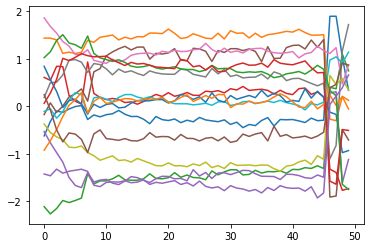

In [328]:
ax = pd.DataFrame(output[0,:,:]).plot(legend=False)

___

In [90]:
class TemporalFusionTransformer():
    def __init__(
        self,
        # Data params
        time_steps:int,
        input_size:int,
        output_size:int,
        category_counts:int,
        n_workers:int, # Number of multiprocessing workers

        # TFT params
        input_obs_loc,
        static_input_loc,
        known_regular_input_idx,
        known_categorical_input_idx,
        column_definition,

        # Network params
        quantile:list=[0.1, 0.5, 0.9], # List of quantiles the model should forecast
        hidden_layer_size:int=30, # Size of hidden layer
        dropout_rate:float=0.0, # Dropout ratio (between 0.0, inclusive, and less than 1.0)
        num_encoder_steps:int=4,
        num_stacks:int=4,
        num_heads:int=4,
        
        # Training params
        max_gradient_norm:float=1.0, # 
        learning_rate:float=0.001,
        minibatch_size:int=64,
        num_epochs:int=100,
        early_stopping_patience:int=5,
        use_gpu:bool=True
    ):
        self.time_steps = time_steps
        self.input_size = input_size
        self.output_size = output_size # Number of periods to be forecasted
        self.category_counts = category_counts
        self.n_workers = n_workers # Number of multiprocessing workers
        
        self.input_obs_loc = input_obs_loc
        self.static_input_loc = static_input_loc
        self.known_regular_input_idx = known_regular_input_idx
        self.known_categorical_input_idx = known_categorical_input_idx
        self.column_definition = column_definition

        self.quantile = quantile # List of quantiles the model should forecast
        self.hidden_layer_size = hidden_layer_size # Size of hidden layer
        self.dropout_rate = dropout_rate # Dropout ratio (between 0.0, inclusive, and less than 1.0)
        self.num_encoder_steps = num_encoder_steps
        self.num_stacks = num_stacks
        self.num_heads = num_heads
        
        self.max_gradient_norm = max_gradient_norm
        self.learning_rate = learning_rate
        self.minibatch_size = minibatch_size
        self.num_epochs = num_epochs
        self.early_stopping_patience = early_stopping_patience
        self.use_gpu = use_gpu

        self.model = self.build_model()

    def __get_tft_embeddings(
        self,
        all_inputs # Input tensor of dimensions (batch, time steps, num variables)
    ):
        # Transform raw inputs to embeddings
        # For continuous variables: linear transformation
        # For categorical variables: embeddings
        
        num_categorical_variables = len(self.category_counts)
        num_regular_variables = self.input_size - num_categorical_variables

        embedding_sizes = [
            self.hidden_layer_size
            for i, size in enumerate(self.category_counts)
        ]

        embeddings = [
            keras.Sequential([
                layers.InputLayer([self.time_steps]),
                layers.Embedding(
                    self.category_counts[i],
                    embedding_sizes[i],
                    input_length=self.time_steps,
                    dtype='float32'
                )
            ])
            for i in range(num_categorical_variables)
        ]

        regular_inputs, categorical_inputs = \
            all_inputs[:, :, :num_regular_variables], \
            all_inputs[:, :, num_regular_variables:]

        embedded_inputs = [
            embeddings[i](categorical_inputs[Ellipsis, i])
            for i in range(num_categorical_variables)
        ]

        # static inputs
        if self._static_input_loc:
            st_inp_dense = [
                layers.Dense(self.hidden_layer_size)(
                    regular_inputs[:, 0, i:i + 1]
                )
                for i in range(num_regular_variables)
                if i in self._static_input_loc
            ]
            st_inp_embed = [
                embedded_inputs[i][:, 0, :]
                for i in range(num_categorical_variables)
                if  i + num_regular_variables in self._static_input_loc
            ]
            static_inputs = st_inp_dense + st_inp_embed
        else:
            static_inputs = None

        # Targets
        past_inputs = keras.ops.stack([
            dense_layer(
                size=self.hidden_layer_size,
                activation=None,
                use_time_distributed=True
            )(regular_inputs[Ellipsis, i:i + 1])
        ], axis=-1)

        # past inputs: observed but not known a priori
        wired_embeddings = [
            embeddings[i](categorical_inputs[:,:,i])
            for i in range(num_categorical_variables)
            if i not in self._known_categorical_input_idx \
                and i + num_regular_variables not in self._input_obs_loc    
        ]
        unknown_inputs = [
            dense_layer(
                size=self.hidden_layer_size,
                activation=None,
                use_time_distributed=True
            )(regular_inputs[Ellipsis, i:i + 1])
            for i in range(regular_inputs.shape[-1])
            if i not in self._known_categorical_input_idx \
                and i + num_regular_variables not in self._input_obs_loc    
        ]
        if wired_embeddings + unknown_inputs:
            unknown_inputs = keras.ops.stack(wired_embeddings + unknown_inputs, axis=-1)
        else:
            unkown_inputs = None

        # a priori known inputs
        known_regular_inputs = [
            dense_layer(
                size=self.hidden_layer_size,
                activation=None,
                use_time_distributed=True
            )(regular_inputs[Ellipsis, i:i + 1])
            for i in self._known_regular_input_idx
            if i not in self._static_input_loc
        ]
        known_categorical_inputs = [
            embedded_inputs[i]
            for i in self._known_categorical_input_idx
            if i + num_regular_variables not in self._static_input_loc
        ]
        known_combined_layer = keras.ops.stack(
            known_regular_inputs + known_categorical_inputs,
            axis=-1
        )

        return unknown_inputs, known_combined_layer, past_inputs, static_inputs

    def _build_base_graph(self):
        # Build the graph, defining the layers of the TFT
        

        ### <TFTInputs>
        all_inputs = layers.Input(
            shape=(self.time_steps, self.input_size) # Argument `shape` does not include batch size
        )
        unknown_inputs, known_combined_layer, past_inputs, static_inputs \
            = self.__get_tft_embeddings(all_inputs)
        ### </TFTInputs>

        # first we isolate the known future inputs and observed past inputs
        if unknown_inputs is not None:
            historical_inputs = keras.ops.concatenate([
                unknown_inputs[:, :self.num_encoder_steps, :],
                known_combined_layer[:, :self.num_encoder_steps, :],
                past_inputs[:, :self.num_encoder_steps, :]
            ], axis=1)
        else:
            historical_inputs = keras.ops.concatenate([
                known_combined_layer[:, :self.num_encoder_steps, :],
                past_inputs[:, :self.num_encoder_steps, :]
            ])
        
        # and then we isolate the known future inputs
        future_inputs = known_combined_layer[:, :self.num_encoder_steps, :]

        # static vars
        static_encoder, static_weights = static_variable_selection(static_inputs)

        # Static covariate encoders
        # These integrate static features into the network through encoding of context vectors
        # that condition the time-varying dynamics
        self.static_context_variable_selection = gated_residual_network( # c_s
            x=static_encoder, # Network inputs
            hidden_layer_size=self.hidden_layer_size, # Dimension of the GRN
            output_size=self.hidden_layer_size, # Size of output layer (if None, same as `hidden_layer_size`)
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=False, # Apply the GRN across all time steps?
        )
        self.static_context_enrichment = gated_residual_network( # c_3
            x=static_encoder, # Network inputs
            hidden_layer_size=self.hidden_layer_size, # Dimension of the GRN
            output_size=self.hidden_layer_size, # Size of output layer (if None, same as `hidden_layer_size`)
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=False, # Apply the GRN across all time steps?
        )
        self.static_context_state_h = gated_residual_network( # c_h
            x=static_encoder, # Network inputs
            hidden_layer_size=self.hidden_layer_size, # Dimension of the GRN
            output_size=self.hidden_layer_size, # Size of output layer (if None, same as `hidden_layer_size`)
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=False, # Apply the GRN across all time steps?
        )
        self.static_context_state_c = gated_residual_network( # c_c
            x=static_encoder, # Network inputs
            hidden_layer_size=self.hidden_layer_size, # Dimension of the GRN
            output_size=self.hidden_layer_size, # Size of output layer (if None, same as `hidden_layer_size`)
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=False, # Apply the GRN across all time steps?
        )

        historical_features, historical_flags, _ = temporal_variable_selection(
            embedding=historical_inputs,
            context=self.static_context_variable_selection,
            hidden_layer_size=self.hidden_layer_size,
            dropout_rate=self.dropout_rate)
        future_features, future_flags, _ = temporal_variable_selection(
            embedding=future_inputs,
            context=self.static_context_variable_selection,
            hidden_layer_size=self.hidden_layer_size,
            dropout_rate=self.dropout_rate)

        # Locality enhancement (Section 4.5.1 in paper) with seq-to-seq layer

        temporal_feature_layer = seq_to_seq(
            hidden_layer_size=self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            historical_features=historical_features,
            future_features=future_features,
            static_context_state_c=self.static_context_state_c,
            static_context_state_h=self.static_context_state_h
        )
        # Temporal Fusion Decoder (TFT, Purple box in Fig. 2)
        # contains three steps
        # TFT 1st step: Static enrichment
        #   - enhances the temporal features with static metadata (Eq. 18)
        
        expanded_static_context_c_e = keras.ops.expand_dims(
            self.static_context_enrichment,
            axis=1
        )
        enriched = gated_residual_network( # $\theta(t, n) = \text{GRN}_{\theta}(\tilde{\theta}(t, n), c_e)
            x=temporal_feature_layer, # from t-k to t+\tau_max
            hidden_layer_size=self.hidden_layer_size,
            output_size=self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            use_time_distributed=True,
            additional_context=expanded_static_context_c_e,
            return_gate=False
        )

        # TFT 2nd step: Temporal self-attention

        self_attention_layer = InterpretableMultiHeadAttention(
            n_head=self.num_heads,
            d_model=self.hidden_layer_size,
            dropout=self.dropout_rate # Will be ignored if `training=False`
        )
        mask = get_decoder_mask(enriched)
        post_attn, self_attention = self_attention_layer( # $B(t) = \text{IMHA}(\Theta(t), \Theta(t), \Theta(t))$
            q=enriched,
            k=enriched,
            v=enriched,
            mask=mask
        )
        post_attn, _ = apply_gating_layer( # $\text{GLU}_{\delta}(\beta(t, n))$
            x=post_attn, # Input tensors (batch first)
            hidden_layer_size=self.hidden_layer_size, # Dimension of the GLU
            dropout_rate=self.dropout_rate, # Dropout rate
            use_time_distributed=True, # Apply the GLU across all time steps?
            activation=None # Activation function
        )

        # skip connection: decides how much of the attention layer is used
        post_attn = add_and_norm([post_attn, enriched]) # \delta(t, n) = \text{LayerNorm}(\theta(t, n) + $\text{GLU}_{\delta}(\beta(t, n)))$

        # TFT 3rd step: Position-wise feed-forward
        decoder = gated_residual_network(
            x=post_attn,
            hidden_layer_size=self.hidden_layer_size,
            output_size=self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            use_time_distributed=True,
            additional_context=None,
            return_gate=False
        )

        # final skip connection
        decoder, _ = apply_gating_layer(
            x=decoder, # Input tensors (batch first)
            hidden_layer_size=self.hidden_layer_size, # Dimension of the GLU
            dropout_rate=self.dropout_rate, # Dropout rate
            activation=None # Activation function
        )
        # the temporal feature layer here is to help the model decide
        # how much to skip the Temporal Fusion Decoder altogether
        transformer_layer = add_and_norm([decoder, temporal_feature_layer])

        # the function also returns the attention components
        # for explainability analyses
        attention_components = {
            "temporal_attention_weights": self_attention,
            "variable_selection_weights_static_inputs": static_weights[Ellipsis, 0],
            "variable_selection_weights_past_inputs": historical_flags[Ellipsis, 0, :],
            "variable_selection_weights_future_inputs": future_flags[Ellipsis, 0, :]
        }

        return transformer_layer, all_inputs, attention_components

    def build_model(self):
        # Build model and define training losses

        transformer_layer, all_inputs, self._attention_components = self._build_base_graph()
        outputs = keras.layers.TimeDistributed(
            keras.layers.Dense(self.output_size * len(self.quantiles))
        )(transformer_layer[Ellipsis, self.num_encoder_steps:, :])
        model = keras.Model(inputs=all_inputs, outputs=outputs)

# Using the TFT model

## Data

In this example, we will use a simple inflation panel dataset.

In [51]:
from gingado.utils import list_all_dataflows, load_SDMX_data

In [52]:
# dflows = list_all_dataflows()
# dflows[dflows == 'BIS long consumer prices']

In [53]:
df_cpi = load_SDMX_data(
    sources={'BIS': 'WS_LONG_CPI'},
    keys={'FREQ': 'M'},
    params={'startPeriod': 2002}
)

Querying data from BIS's dataflow 'WS_LONG_CPI' - BIS long consumer prices...


In [54]:
df_cpi = df_cpi['2002-01-01':'2023-09-01']
cpi_cols = df_cpi.dropna(how='all', axis=1).columns

In [55]:
# keep only one observation per country, retaining only the ones ending in 628 (in opposition to 771)
df_infl = df_cpi[[c for c in cpi_cols if '628' in c and c != 'BIS__WS_LONG_CPI_M__AE__628']].pct_change(periods=1).dropna(how='all')

Clean the titles from the metadata

In [56]:
df_infl.columns = [c.split('__')[2] for c in df_infl.columns]

<AxesSubplot:xlabel='TIME_PERIOD'>

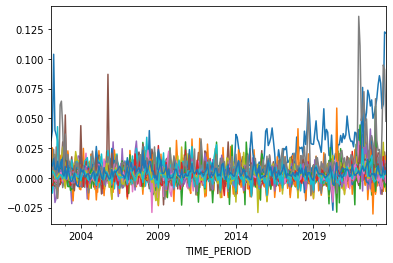

In [57]:
df_infl.plot(legend=False)

In [58]:
train_cutoff = '2013-01-01'
valid_cutoff = '2020-01-01'
df_infl_train, df_infl_valid, df_infl_test = df_infl[:train_cutoff], df_infl[train_cutoff:valid_cutoff], df_infl[valid_cutoff:]
df_infl_train = df_infl_train[:-1]
df_infl_valid = df_infl_valid[:-1]

In [59]:
df_infl_valid

,AR,AT,AU,BE,BG,BR,CA,CH,CL,CN,...,SA,SE,SG,SI,SK,TH,TR,US,XM,ZA
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.011371,-0.004469,0.003922,-0.000302,0.004121,0.0086,0.000825,-0.002611,0.003548,0.010002,...,0.010963,-0.008296,0.001889,-0.008048,0.006035,0.001570,0.016461,0.002957,-0.010392,0.001548
2013-02-01,0.004931,0.002245,0.000000,0.003220,0.000504,0.0060,0.011542,0.002955,0.001187,0.010999,...,0.000863,0.004455,0.010049,0.008114,-0.000245,0.002194,0.002999,0.008190,0.003670,0.010819
2013-03-01,0.007262,0.007839,0.000000,0.001404,-0.005390,0.0047,0.001630,0.002172,0.005572,-0.009005,...,-0.000216,0.004021,-0.005378,0.003018,0.000585,0.000626,0.006624,0.002615,0.011784,0.012233
2013-04-01,0.007275,0.001111,0.003906,-0.000401,-0.004348,0.0055,-0.001627,0.000336,-0.001756,0.002002,...,0.000000,-0.001970,-0.014831,0.007021,0.000362,0.001563,0.004204,-0.001040,-0.000904,0.003021
2013-05-01,0.006900,0.002220,0.000000,0.001503,-0.001421,0.0037,0.002445,0.001100,-0.000532,-0.006002,...,-0.000108,0.001624,0.003553,0.002988,0.001026,0.002497,0.001456,0.001780,0.001105,-0.001506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,0.038697,0.001017,0.000000,-0.000184,0.000682,0.0011,-0.001460,-0.000102,0.001855,0.007004,...,0.001940,-0.004199,0.006246,0.003708,0.002069,-0.001894,0.008587,-0.000051,0.001430,0.003304
2019-09-01,0.058082,0.004065,0.000000,-0.004590,-0.003423,-0.0004,-0.004386,-0.001096,0.000097,0.008996,...,0.002343,0.004665,-0.000619,-0.001894,0.001304,0.000899,0.009933,0.000783,0.002189,0.002195
2019-10-01,0.031973,0.003036,0.006932,0.003596,0.008009,0.0010,0.002937,-0.002249,0.008185,0.009000,...,0.000508,0.000268,-0.002167,0.000664,-0.000954,-0.001496,0.020022,0.002286,0.001425,0.000000


### Data preparation

This crucial step involves:
* measuring the mean and standard deviation of the inflation of each country in the training dataset
* using the values above to standardise the training, validation and testing datasets

In [60]:
train_scale = {
    'mean': df_infl_train.mean(axis=0),
    'std': df_infl_train.std(axis=0)
}

In [61]:
def normalise_df(df, scale=train_scale):
    norm_dfs = []
    for cty in df.columns.tolist():
        norm_dfs.append((df[cty] - scale['mean'][cty]) / scale['std'][cty])
    return pd.concat(norm_dfs, axis=1)

In [62]:
def renormalise_df(df, scale=train_scale):
    renorm_dfs = []
    for cty in df.columns.tolist():
        renorm_dfs.append((df[cty] * scale['std'][cty]) + scale['mean'][cty])
    return pd.concat(renorm_dfs, axis=1)

In [63]:
# the code below check that it is working:
# (renormalise_df(normalise_df(df_infl_train, train_scale)) - df_infl_train)

In [64]:
df_infl_train_n = normalise_df(df_infl_train)
df_infl_valid_n = normalise_df(df_infl_valid)
df_infl_test_n = normalise_df(df_infl_test)

<AxesSubplot:xlabel='TIME_PERIOD'>

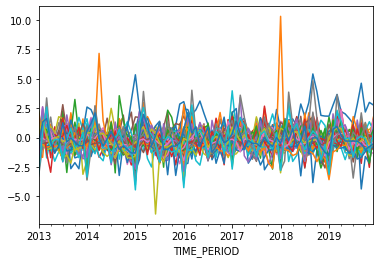

In [65]:
df_infl_valid_n.plot(legend=False)

## A simple dense layer

This first model is autoregressive: it takes in $p$ lags of an inflation series $\pi_i$ (in other words, $\pi_{i, t-p}, ..., \pi_{i, t-1}$) to predict the period $\pi_{i,t}$.

Note that the model is very simple:
* each country's inflation series is only predicted by its past values
* the fully connected linear layer learns to pick up any meaningful non-linear interactions between lags, but there is no intrinsic meaning in the order of the lags
* this network will always take in as input a $p$-sized vector of lagged data

### Data formatting

Let's create a simple function that will take a data frame and return a (input, output) tuple for the model.

In [66]:
def dense_layer_io(
    df, # Pandas DataFrame with the data
    idx:[Int], # DataFrame indedx
    col:[str], # Column name
    p:Int # Number of lags
):
    # Return an (input, output) tuple for a dense_layer model
    
    assert len(idx) == len(col)

    batch_X, batch_y = [], []
    for i in range(len(idx)):
        X = df.iloc[idx[i]:(idx[i]+p)][[col[i]]].values.reshape(-1)
        if np.isnan(X).any():
            continue
        batch_X.append(X)
        batch_y.append(df.iloc[idx[i]+p][[col[i]]].values)
    
    return np.vstack(batch_X), np.vstack(batch_y)

    #return df.iloc[idx:(idx+p)][[col]].values.reshape(-1), df.iloc[idx+p+1][[col]].values

In [67]:
dense_layer_io(df=df_infl_train, idx=[3, 4, 5], col=['BR', 'BR', 'BR'], p=4)

(array([[0.00209779, 0.00419757, 0.01190234, 0.00649815],
        [0.00419757, 0.01190234, 0.00649815, 0.00719811],
        [0.01190234, 0.00649815, 0.00719811, 0.01310222]]),
 array([[0.00719811],
        [0.01310222],
        [0.03020224]]))

In [68]:
def random_select(df, p, n_samples):
    max_index = len(df) - p
    rand_idx, rand_col = [], []
    for _ in range(n_samples):
        rand_idx.append(random.randint(0, max_index-2)) # instead of -1 only, we also need to account for the target value
        rand_col.append(random.choice(df.columns))
    return rand_idx, rand_col

In [69]:
n_samples = 1000 # with replacement

In [70]:
p = 24

idx, col = random_select(df_infl_train_n, p=p, n_samples=n_samples)
train_samples = dense_layer_io(df=df_infl_train_n, idx=idx, col=col, p=p)

idx, col = random_select(df_infl_valid_n, p=p, n_samples=n_samples)
valid_samples = dense_layer_io(df=df_infl_valid_n, idx=idx, col=col, p=p)

### Model

In [71]:
#nn_linear = dense_layer(size=p)

nn_linear = keras.Sequential([
    layers.Input((p,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1)
])

In [72]:
nn_linear.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 32)                │        800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_73 (Dense)                │ (None, 5)                 │        165 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_74 (Dense)                │ (None, 1)                 │          6 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 971 (3.79 KB)

 Trainable params: 971 (3.79 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
nn_linear.layers[0].get_weights()

[array([[-3.36906016e-02, -2.88324773e-01, -2.84295440e-01,
          2.31350482e-01, -3.20674628e-01, -1.83200002e-01,
         -1.95912763e-01, -7.73634017e-02, -2.85202980e-01,
         -1.55477569e-01,  3.32024693e-02, -1.44766390e-01,
          2.23105848e-01, -2.07514614e-01,  1.08735025e-01,
          3.08961987e-01, -7.22835660e-02, -2.22998381e-01,
         -2.91681319e-01, -1.17042854e-01, -1.81359798e-01,
          2.41613448e-01,  8.85717869e-02,  2.45229602e-01,
          1.63039237e-01, -2.43400902e-01, -2.63005853e-01,
          2.15264857e-01, -2.30350137e-01, -1.22503296e-01,
         -5.46252131e-02, -2.35365748e-01],
        [ 1.49490029e-01,  2.23501921e-01,  2.71095991e-01,
          6.57997727e-02,  1.80384755e-01,  2.44235754e-01,
          2.07131445e-01, -1.69277489e-02,  2.77400017e-01,
         -3.16308737e-02,  2.97998846e-01,  2.85730064e-01,
          9.21469033e-02, -1.84848845e-01,  2.45206833e-01,
         -2.45289177e-01, -9.04566944e-02, -2.62988836e-

In [74]:
nn_linear.layers[1].get_weights()

[array([[ 0.15292168, -0.16990212,  0.1281966 ,  0.27158642, -0.03940159],
        [-0.15453587,  0.2788571 ,  0.2552446 ,  0.25929612, -0.00359258],
        [-0.04698193, -0.20610996, -0.06019381,  0.28337908,  0.24271864],
        [-0.0391607 ,  0.08948445, -0.13492781, -0.12533885,  0.2997132 ],
        [-0.23169163,  0.36373395,  0.34082317,  0.26588422,  0.26191086],
        [-0.36926153, -0.01567453,  0.0540325 ,  0.17088872, -0.01088232],
        [ 0.1419006 ,  0.32993674,  0.33136892, -0.30035973, -0.2816222 ],
        [-0.13628483,  0.05728358,  0.37226915, -0.06942928,  0.05167452],
        [-0.10657454, -0.21881884,  0.18417943, -0.07534087,  0.00190434],
        [ 0.3011253 ,  0.20400947,  0.16668934,  0.03312525, -0.04623201],
        [-0.4018473 , -0.10559717, -0.07911232, -0.12266144, -0.10475075],
        [ 0.20681262,  0.1647101 ,  0.3922428 , -0.03395784, -0.16400559],
        [-0.15442729,  0.14109057, -0.3058731 , -0.17111626, -0.30476466],
        [-0.03832418,  0.

In [75]:
nn_linear.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

In [76]:
assert nn_linear(train_samples[0]).shape == train_samples[1].shape

In [77]:
history_dense = nn_linear.fit(
    x=train_samples[0],
    y=train_samples[1],
    batch_size=10,
    epochs=500,
    validation_data=valid_samples,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

Epoch 1/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5049 - rmse: 1.2204 - val_loss: 0.8227 - val_rmse: 0.9070
Epoch 2/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7948 - rmse: 0.8912 - val_loss: 0.6989 - val_rmse: 0.8360
Epoch 3/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6696 - rmse: 0.8179 - val_loss: 0.6515 - val_rmse: 0.8072
Epoch 4/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5777 - rmse: 0.7596 - val_loss: 0.6414 - val_rmse: 0.8008
Epoch 5/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5003 - rmse: 0.7059 - val_loss: 0.6341 - val_rmse: 0.7963
Epoch 6/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5090 - rmse: 0.7119 - val_loss: 0.6387 - val_rmse: 0.7992
Epoch 7/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4530 - rmse: 0.6703 - val_loss: 0.6431 - val_rmse: 0.8020
Epoch 8/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5003 - rmse: 0.7064 - val_loss: 0.6310 - val_rmse: 0.7944
Epoch 9/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

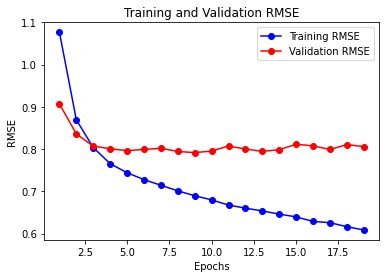

In [78]:
train_loss = history_dense.history['rmse']
val_loss = history_dense.history['val_rmse']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training RMSE')
plt.plot(epochs, val_loss, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

## LSTM neural network

In [79]:
def lstm_io(
    df, # Pandas DataFrame with the data
    idx:[Int], # DataFrame indedx
    col:[str], # Column name
    p:Int # Number of lags
):
    # Return an (input, output) tuple for a dense_layer model
    
    assert len(idx) == len(col)

    batch_X, batch_y = [], []
    for i in range(len(idx)):
        X = df.iloc[idx[i]:(idx[i]+p)].values
        X[np.isnan(X)] = 0
        batch_X.append(X)
        batch_y.append(df.iloc[idx[i]+p][[col[i]]].values)
    
    return np.vstack(batch_X), np.vstack(batch_y)

In [80]:
lstm = layers.LSTM(units=64, return_sequences=True, return_state=False)
fl = layers.Flatten()

In [81]:
train_samples[0][:5].shape

(5, 24)

In [82]:
nn_lstm = keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, return_state=False, dropout=0.1),
    #layers.LSTM(units=1, return_sequences=False, return_state=False, dropout=0.1),
    layers.Flatten(),
    layers.Dense(15, activation='relu'),
    layers.Dense(1)
])

In [83]:
assert nn_lstm(np.expand_dims(train_samples[0], axis=-1)).shape == train_samples[1].shape

In [84]:
nn_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (990, 24, 64)             │     16,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_2 (Flatten)             │ (990, 1536)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_75 (Dense)                │ (990, 15)                 │     23,055 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_76 (Dense)                │ (990, 1)                  │         16 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 39,967 (156.12 KB)

 Trainable params: 39,967 (156.12 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
nn_lstm.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

In [86]:
history_lstm = nn_lstm.fit(
    x=train_samples[0],
    y=train_samples[1],
    batch_size=10,
    epochs=500,
    validation_data=valid_samples,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

Epoch 1/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8201 - rmse: 0.9051 - val_loss: 0.7144 - val_rmse: 0.8452
Epoch 2/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6628 - rmse: 0.8124 - val_loss: 0.6550 - val_rmse: 0.8093
Epoch 3/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6222 - rmse: 0.7883 - val_loss: 0.6021 - val_rmse: 0.7759
Epoch 4/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5253 - rmse: 0.7243 - val_loss: 0.5815 - val_rmse: 0.7626
Epoch 5/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5773 - rmse: 0.7591 - val_loss: 0.5524 - val_rmse: 0.7432
Epoch 6/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5435 - rmse: 0.7370 - val_loss: 0.5926 - val_rmse: 0.7698
Epoch 7/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5108 - rmse: 0.7140 - val_loss: 0.5727 - val_rmse: 0.7568
Epoch 8/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5354 - rmse: 0.7308 - val_loss: 0.5272 - val_rmse: 0.7261
Epoch 9/500
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/st

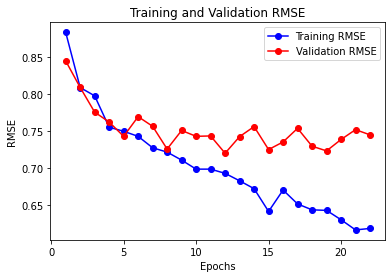

In [87]:
train_loss = history_lstm.history['rmse']
val_loss = history_lstm.history['val_rmse']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training RMSE')
plt.plot(epochs, val_loss, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

## LSTM with other countries' inflation data

The difference between this and the previous one is that it is not only autoregressive, but also considers past data from other countries.

### Data formatting

In [100]:
def lstm_cty_io(
    df, # Pandas DataFrame with the data
    idx:[Int], # DataFrame indedx
    col:[str], # Column name
    p:Int # Number of lags
):
    # Return an (input, output) tuple for a dense_layer model
    
    assert len(idx) == len(col)

    batch_X, batch_y = [], []
    for i in range(len(idx)):
        X = df.iloc[idx[i]:(idx[i]+p)].values
        X[np.isnan(X)] = 0
        batch_X.append(X)
        batch_y.append(df.iloc[idx[i]+p][[col[i]]].values)
    
    return np.stack(batch_X, axis=0), np.vstack(batch_y)  #np.vstack(batch_X), np.vstack(batch_y)

In [101]:
lstm_cty_io(df=df_infl_train, idx=[3, 4, 5], col=['BR', 'BR', 'BR'], p=4)[0].shape

(3, 4, 61)

In [102]:
p = 24

idx, col = random_select(df_infl_train_n, p=p, n_samples=n_samples)
train_samples = lstm_cty_io(df=df_infl_train_n, idx=idx, col=col, p=p)

idx, col = random_select(df_infl_valid_n, p=p, n_samples=n_samples)
valid_samples = lstm_cty_io(df=df_infl_valid_n, idx=idx, col=col, p=p)

In [103]:
train_samples[0].shape

(1000, 24, 61)

### Model

In [137]:
nn_lstm_cty = keras.Sequential([
    layers.LSTM(units=1052, return_sequences=True, return_state=False, dropout=0.1),
    layers.LSTM(units=64, return_sequences=True, return_state=False, dropout=0.1),
    #layers.LSTM(units=1, return_sequences=False, return_state=False, dropout=0.1),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

In [138]:
nn_lstm_cty.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_13 (LSTM)                  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_8 (Flatten)             │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_87 (Dense)                │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_88 (Dense)                │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [139]:
assert nn_lstm_cty(train_samples[0]).shape == train_samples[1].shape

In [140]:
nn_lstm_cty.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

In [141]:
train_samples[0].shape

(1000, 24, 61)

In [142]:
history_lstm_cty = nn_lstm_cty.fit(
    x=train_samples[0],
    y=train_samples[1],
    batch_size=20,
    epochs=500,
    validation_data=valid_samples,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 423ms/step - loss: 0.9400 - rmse: 0.9688 - val_loss: 1.2223 - val_rmse: 1.1056
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 407ms/step - loss: 0.8863 - rmse: 0.9410 - val_loss: 1.4539 - val_rmse: 1.2058
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 397ms/step - loss: 0.9242 - rmse: 0.9611 - val_loss: 1.1974 - val_rmse: 1.0943
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 430ms/step - loss: 0.8625 - rmse: 0.9282 - val_loss: 1.0799 - val_rmse: 1.0392
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 387ms/step - loss: 0.7870 - rmse: 0.8866 - val_loss: 1.0528 - val_rmse: 1.0261
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 343ms/step - loss: 0.7795 - rmse: 0.8811 - val_loss: 1.0447 - val_rmse: 1.0221
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 446ms/step - loss: 0.8111 - rmse: 0.9004 - val_loss: 1.1703 - val_rmse: 1.0818
Epoch 8/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 487ms/step - loss: 0.7684 - rmse: 0.8756 - val_loss: 1.0712 - val_rmse: 1.0350
Epoch 9/500
50/50 ━━━━━━

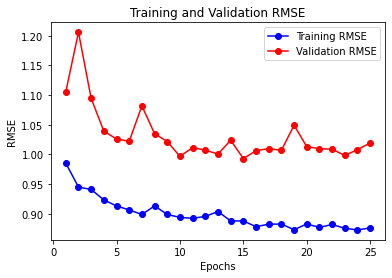

In [143]:
train_loss = history_lstm_cty.history['rmse']
val_loss = history_lstm_cty.history['val_rmse']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training RMSE')
plt.plot(epochs, val_loss, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

## Model with date features

Repeating date features (eg, day in the week, month, quarter and year, week in the month, quarter and year, month in the quarter and year, and quarter in year) can be embedded and included in the model.

In [99]:
#nn_lstm_datefeat = layers.LSTM()

## Creating a TFT model

In [ ]:
tft = TemporalFusionTransformer(
    time_steps=12,
    input_size=20,
    output_size=4,
    category_counts=5,
    n_workers=2, # Number of multiprocessing workers

    # TFT params
    input_obs_loc=24,
    static_input_loc=24,
    known_regular_input_idx=24,
    known_categorical_input_idx=24,
    column_definition=None,
)

In [ ]:
tft.time_steps

# Test

In [ ]:
batch_size = 3
n_timesteps = 4

univariate_x = np.ones(shape=(batch_size, n_timesteps))
univariate_x = keras.ops.expand_dims(univariate_x, axis=-1)
univariate_x.shape

TensorShape([3, 4, 1])

In [ ]:
lstm = layers.LSTM(
    units=6,
    return_sequences=True,
    return_state=False,
)

In [ ]:
transf_x = lstm(univariate_x)
transf_x.shape, keras.ops.concatenate([transf_x, transf_x], axis=1).shape

(TensorShape([3, 4, 6]), TensorShape([3, 8, 6]))

In [ ]:
transf_x.shape

TensorShape([3, 14])

# References {.unnumbered}